In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from pipeline_config import (
    dataloaders_conf,
    aug_config,
    train_conf,
    model_config, 
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Prepare train, validation and test data

In [7]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 649.73it/s]
100%|██████████| 720/720 [00:08<00:00, 88.26it/s]
8280it [00:00, 94473.76it/s]
7920it [00:00, 215564.29it/s]
720it [00:00, 766.30it/s]
100%|██████████| 720/720 [00:08<00:00, 89.61it/s]
8280it [00:00, 233043.47it/s]
720it [00:00, 792.40it/s]
100%|██████████| 720/720 [00:08<00:00, 89.26it/s]
8280it [00:00, 235433.78it/s]
700it [00:00, 830.58it/s]
100%|██████████| 700/700 [00:07<00:00, 94.95it/s] 
8280it [00:00, 245351.98it/s]
509it [00:00, 1147.53it/s]
100%|██████████| 509/509 [00:02<00:00, 189.77it/s]
3664it [00:00, 250716.68it/s]
700it [00:00, 844.74it/s]
100%|██████████| 700/700 [00:07<00:00, 95.77it/s] 
8280it [00:00, 242792.78it/s]
700it [00:00, 837.52it/s]
100%|██████████| 700/700 [00:07<00:00, 96.06it/s] 
8280it [00:00, 226914.67it/s]
710it [00:01, 369.14it/s]
100%|██████████| 710/710 [00:07<00:00, 94.80it/s] 
8280it [00:00, 241682.70it/s]
710it [00:01, 399.17it/s]
100%|██████████| 710/710 [00:07<00:00, 93.43it/s] 
8280it [00:00, 227186.32it/s]
710it [00:

In [8]:
len(data_train), len(data_val), len(data_test)

(8280, 7920, 11)

In [9]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [10]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [11]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [12]:
device = 'cuda:0'

In [13]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

## Dump experiment results

In [67]:
import pickle
import json

In [16]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'wb') as f:
#     pickle.dump(results, f)

In [68]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [14]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))
# model = model.to('cpu').to(device)

<All keys matched successfully>

## Train and validation losses

In [18]:
from itertools import chain

In [19]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [20]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

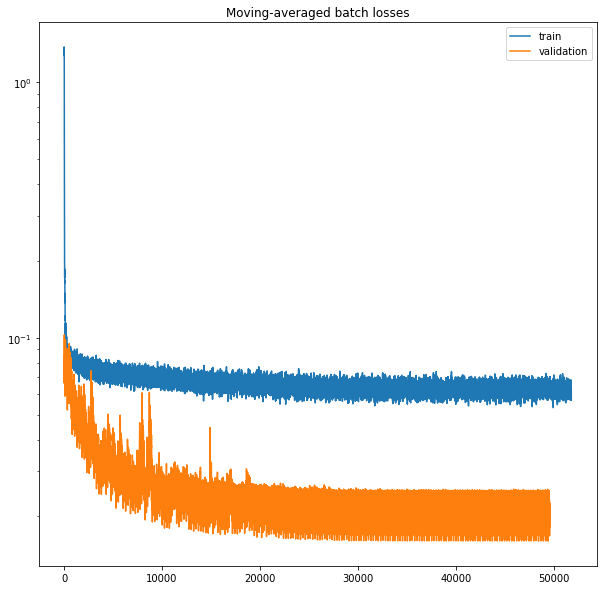

In [21]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [22]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

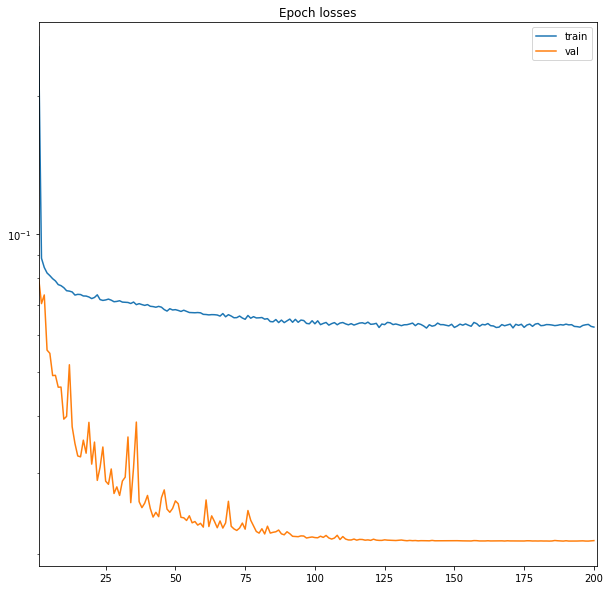

In [23]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Predicted samples

In [15]:
import os

In [16]:
import torch

In [17]:
from visualization_utils import output_to_binary, plot_sample

In [18]:
threshold = 0.5
to_plot = 10
# device = model_conf['device']

carb96558


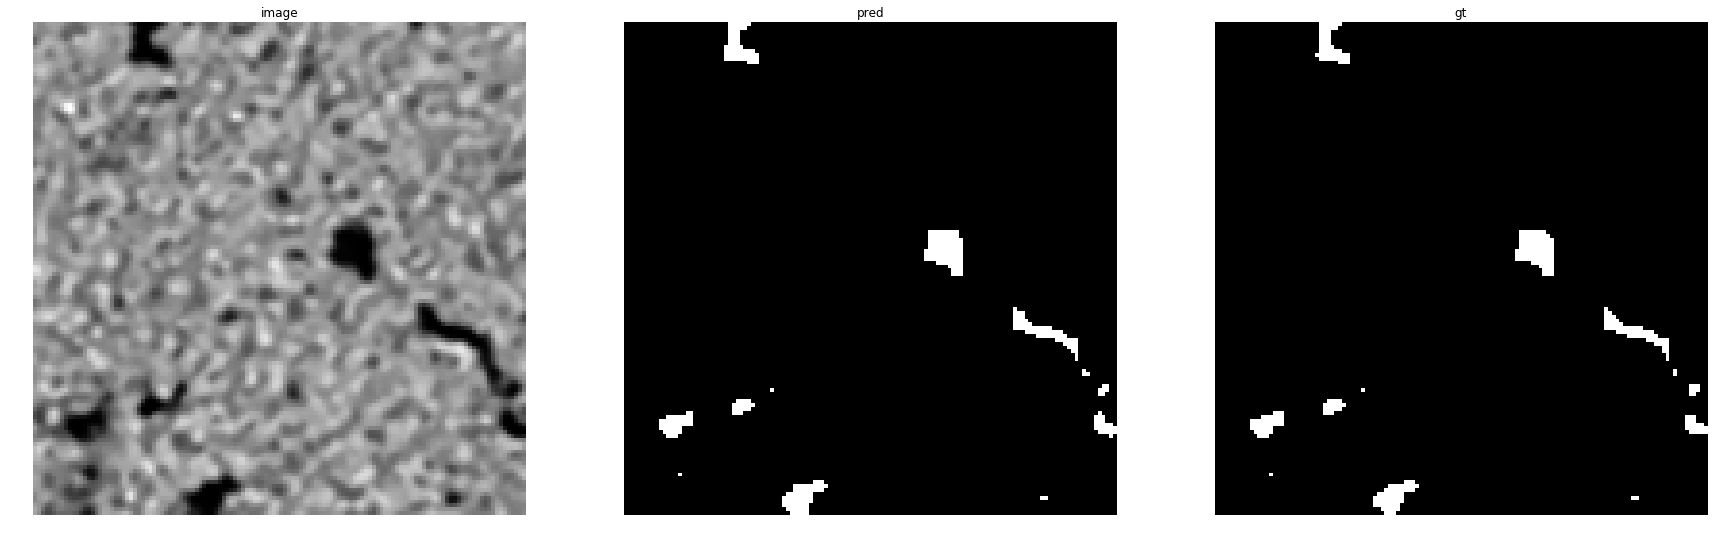

accuracy    : 0.9989013671875
precision   : 0.9562841530054644
recall      : 0.9943181818181818
f1          : 0.9749303621169917
pr_auc      : 0.9980469839634029
iou         : 0.9510869565217391


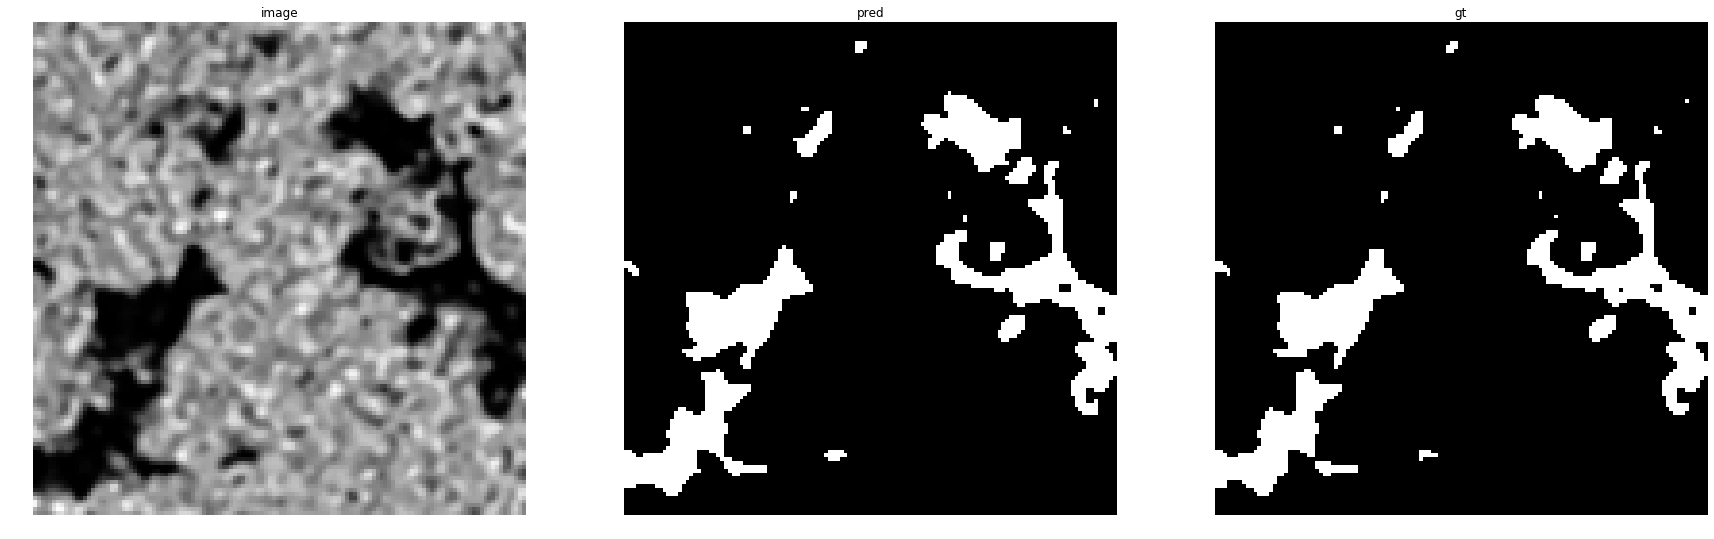

accuracy    : 0.99468994140625
precision   : 0.962043795620438
recall      : 0.9954682779456193
f1          : 0.9784706755753526
pr_auc      : 0.9989074924695407
iou         : 0.9578488372093024


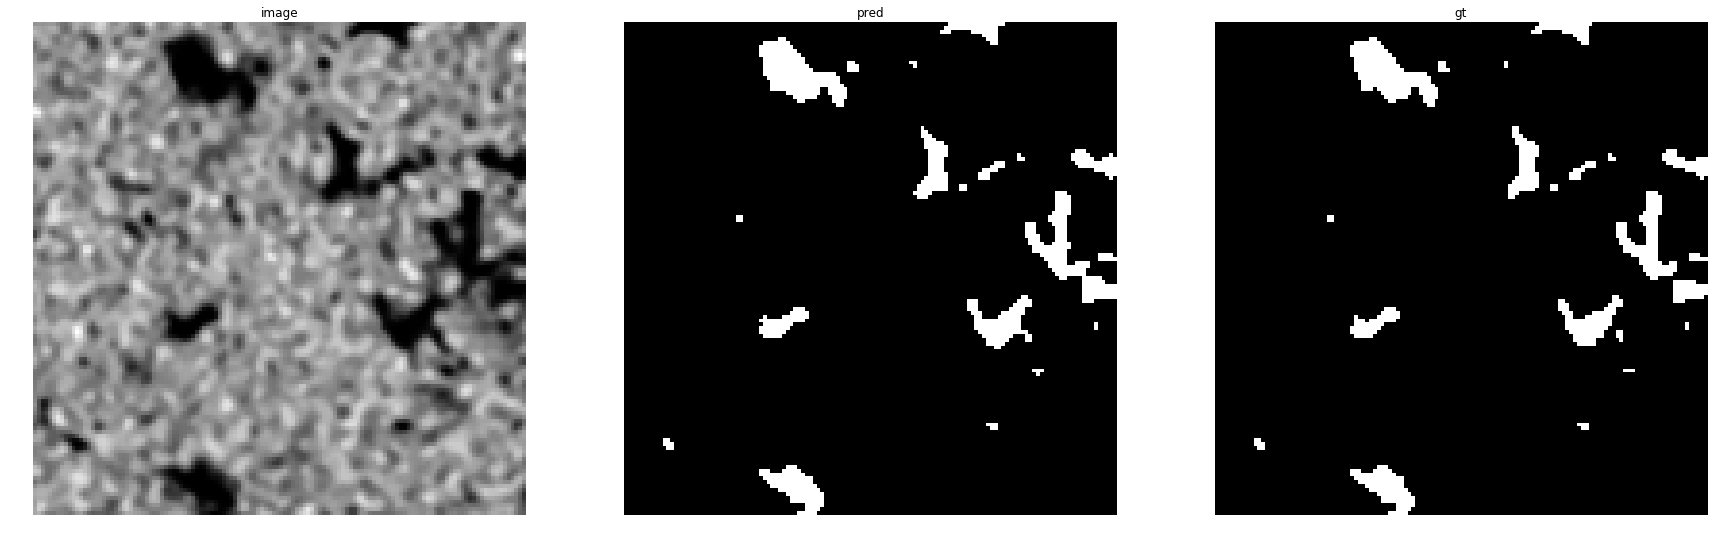

accuracy    : 0.9964599609375
precision   : 0.9437367303609342
recall      : 0.9944071588366891
f1          : 0.968409586056645
pr_auc      : 0.9971249211979478
iou         : 0.938753959873284


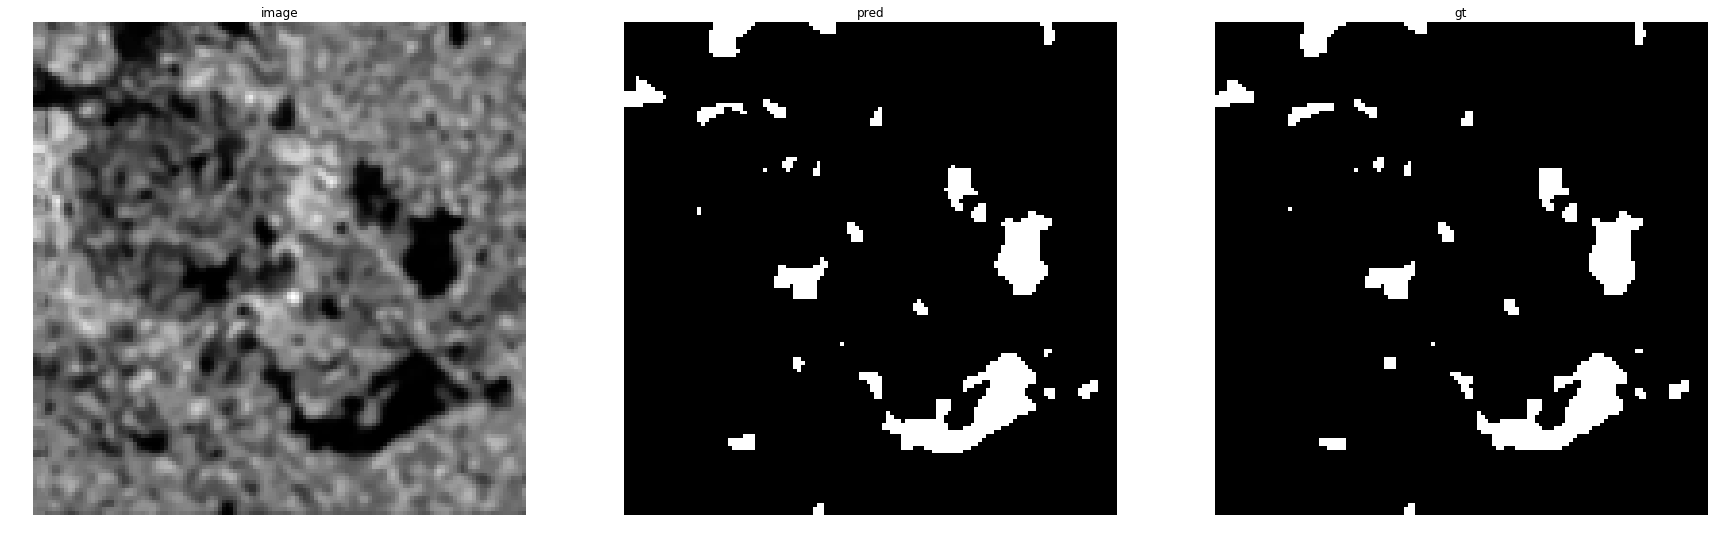

accuracy    : 0.99456787109375
precision   : 0.9368421052631579
recall      : 0.9843317972350231
f1          : 0.9600000000000001
pr_auc      : 0.9971171455873964
iou         : 0.9230769230769231


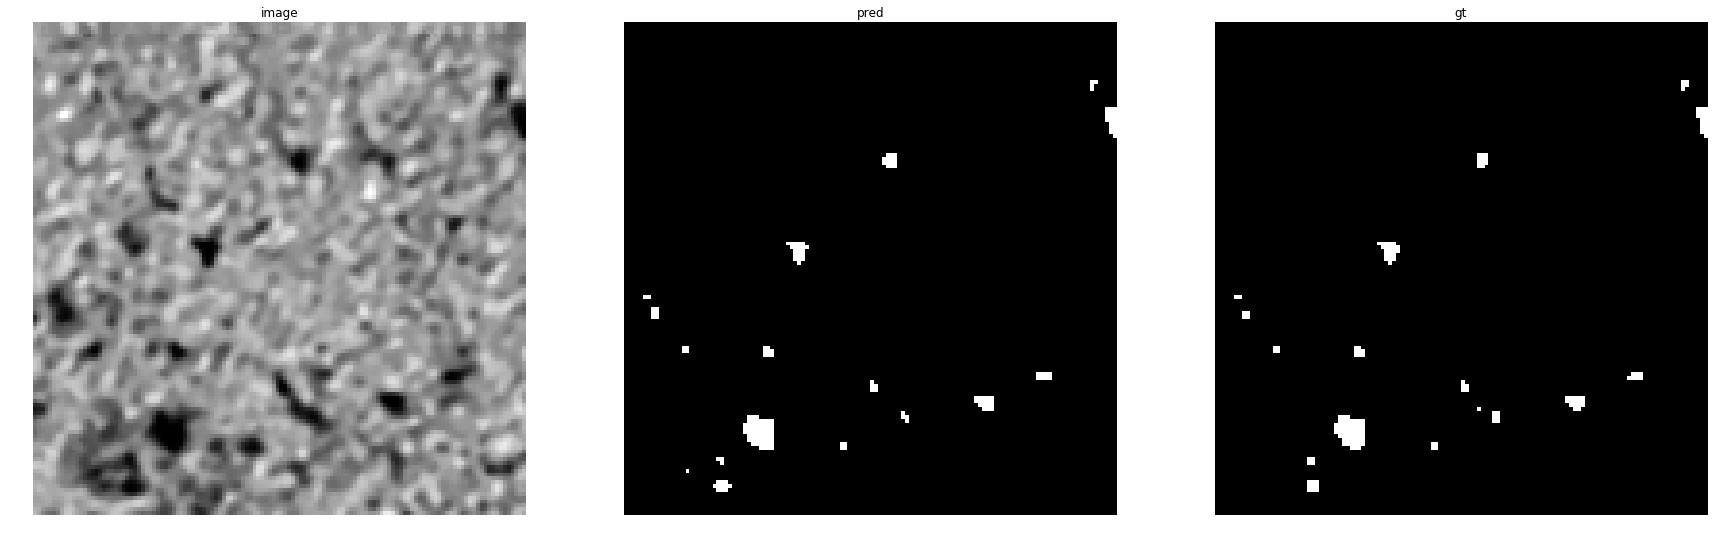

accuracy    : 0.99884033203125
precision   : 0.9308510638297872
recall      : 0.9668508287292817
f1          : 0.9485094850948509
pr_auc      : 0.994012616708128
iou         : 0.9020618556701031


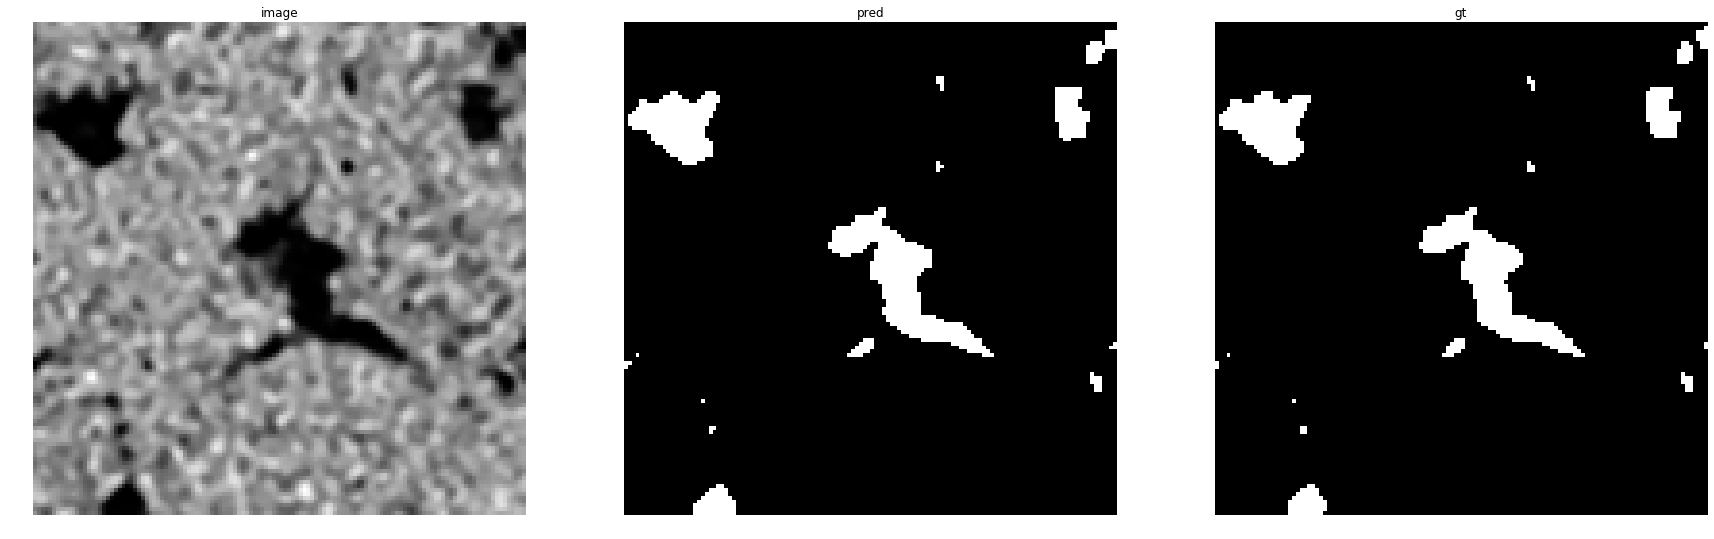

accuracy    : 0.9971923828125
precision   : 0.9600778967867576
recall      : 0.9949545913218971
f1          : 0.9772051536174431
pr_auc      : 0.9985527021960066
iou         : 0.9554263565891473


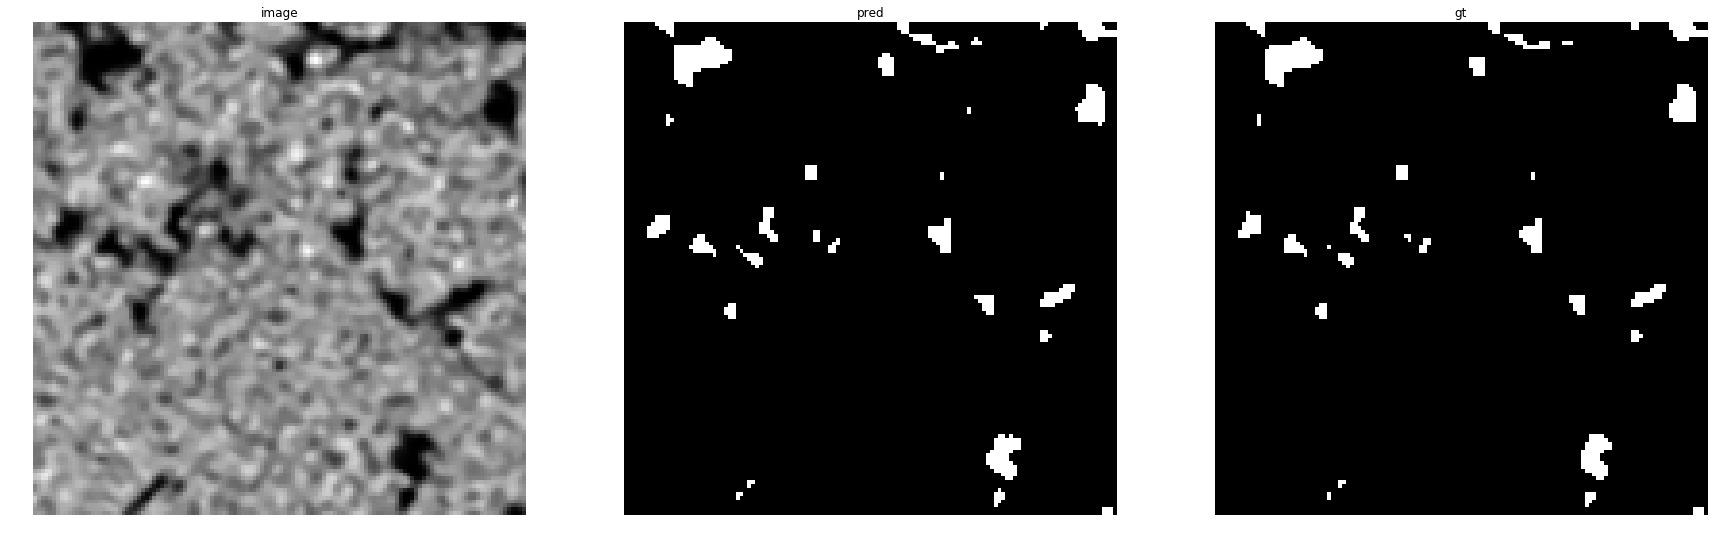

accuracy    : 0.99749755859375
precision   : 0.9428571428571428
recall      : 0.9876760563380281
f1          : 0.9647463456577815
pr_auc      : 0.9960025570985848
iou         : 0.9318936877076412


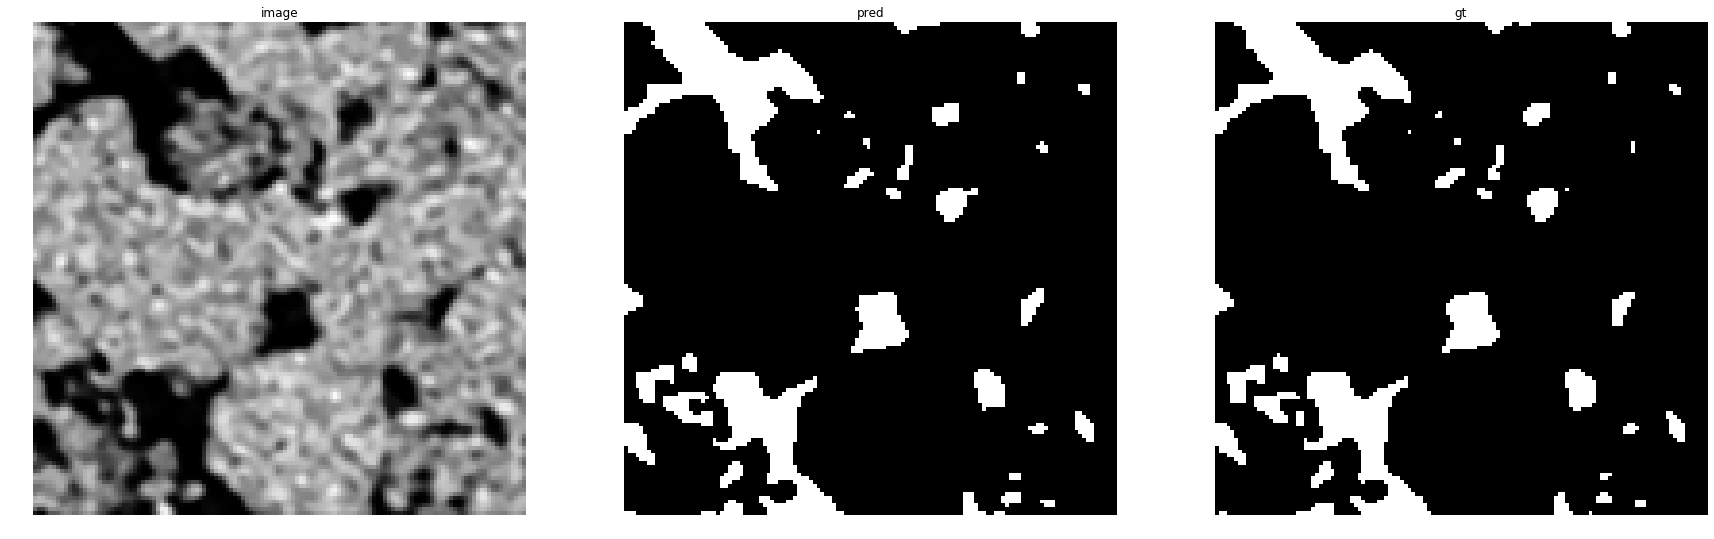

accuracy    : 0.9935302734375
precision   : 0.9582942830365511
recall      : 0.9917555771096024
f1          : 0.9747378455672069
pr_auc      : 0.9985782345151937
iou         : 0.9507205950720595


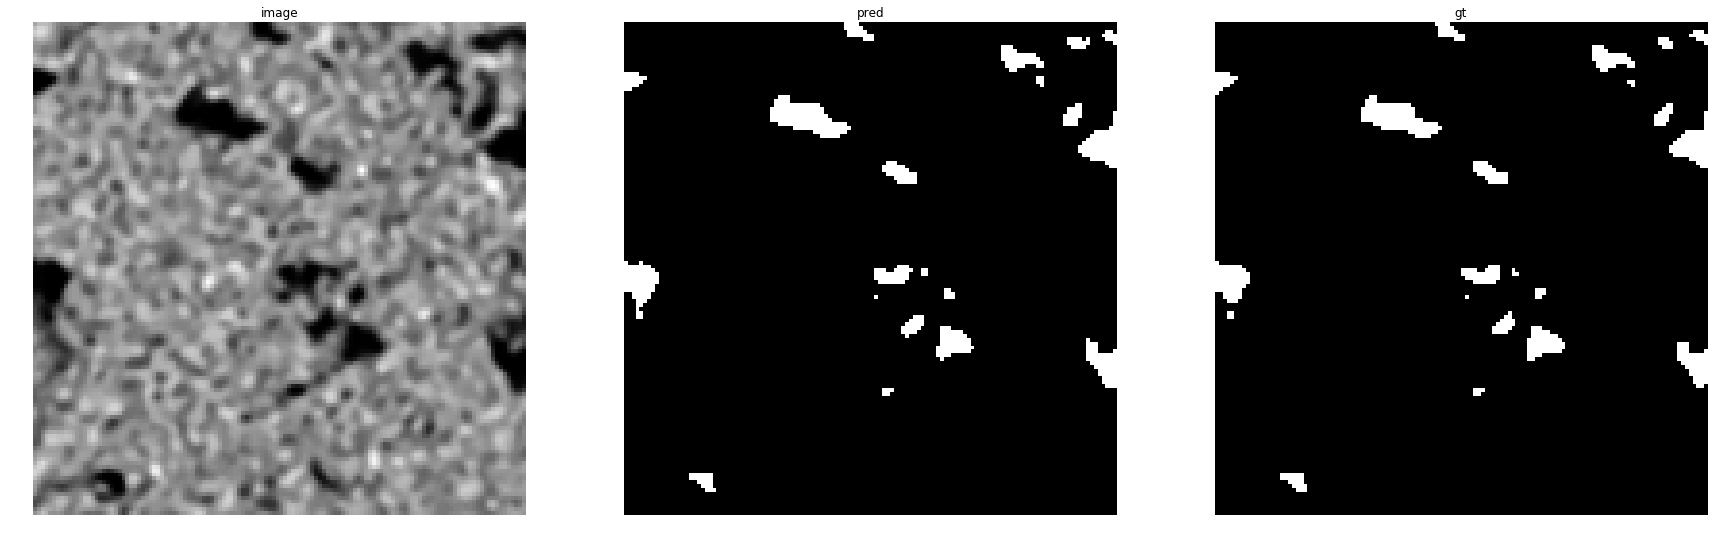

accuracy    : 0.9969482421875
precision   : 0.9466666666666667
recall      : 0.9785604900459418
f1          : 0.9623493975903614
pr_auc      : 0.9969023879302885
iou         : 0.9274310595065312


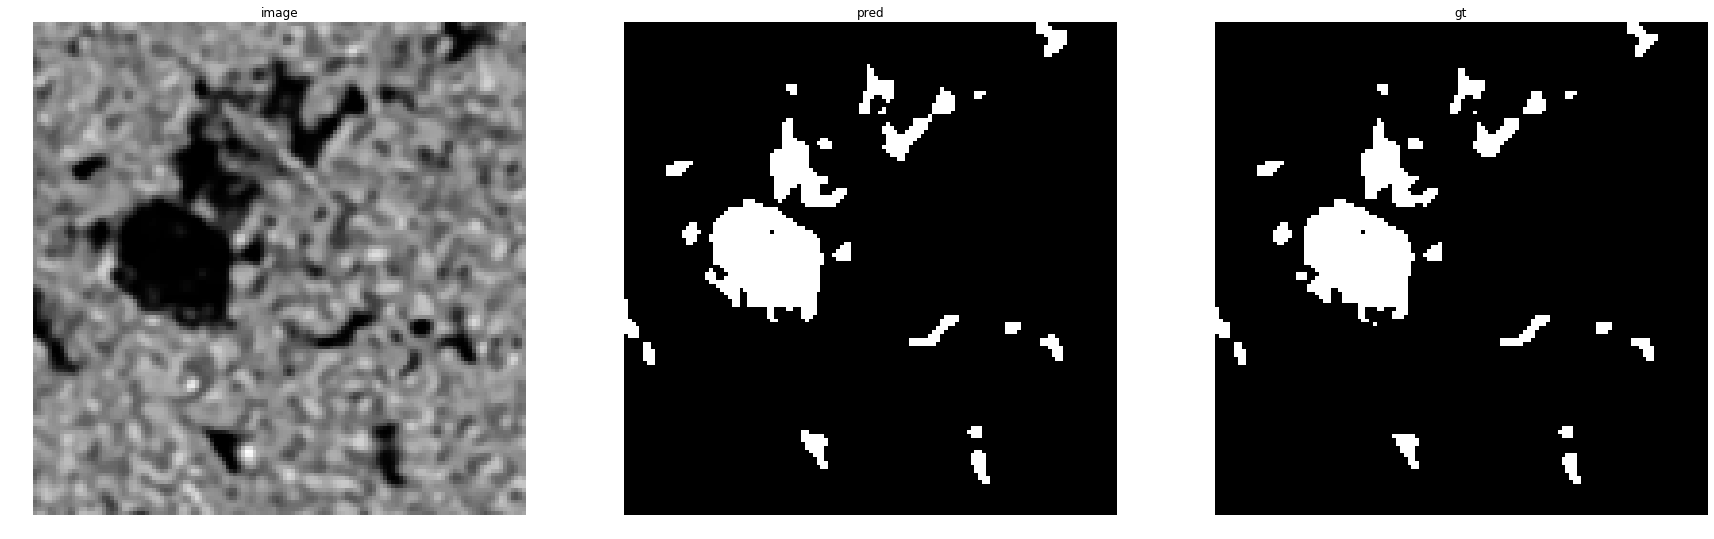

accuracy    : 0.994873046875
precision   : 0.9436513899323816
recall      : 0.9928853754940712
f1          : 0.9676425269645609
pr_auc      : 0.9980426220888047
iou         : 0.9373134328358209
carb71


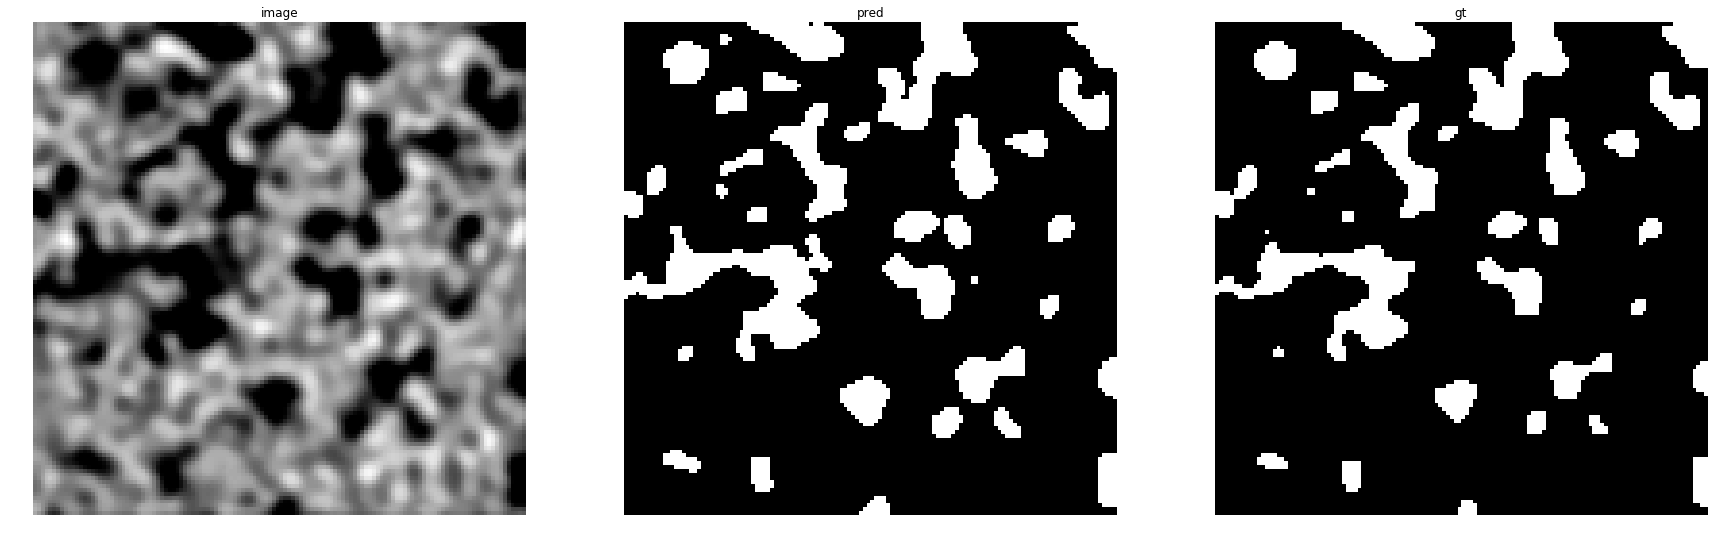

accuracy    : 0.966064453125
precision   : 0.8322082931533269
recall      : 0.987037743042318
f1          : 0.9030345308685036
pr_auc      : 0.9900207985300057
iou         : 0.8232114467408586


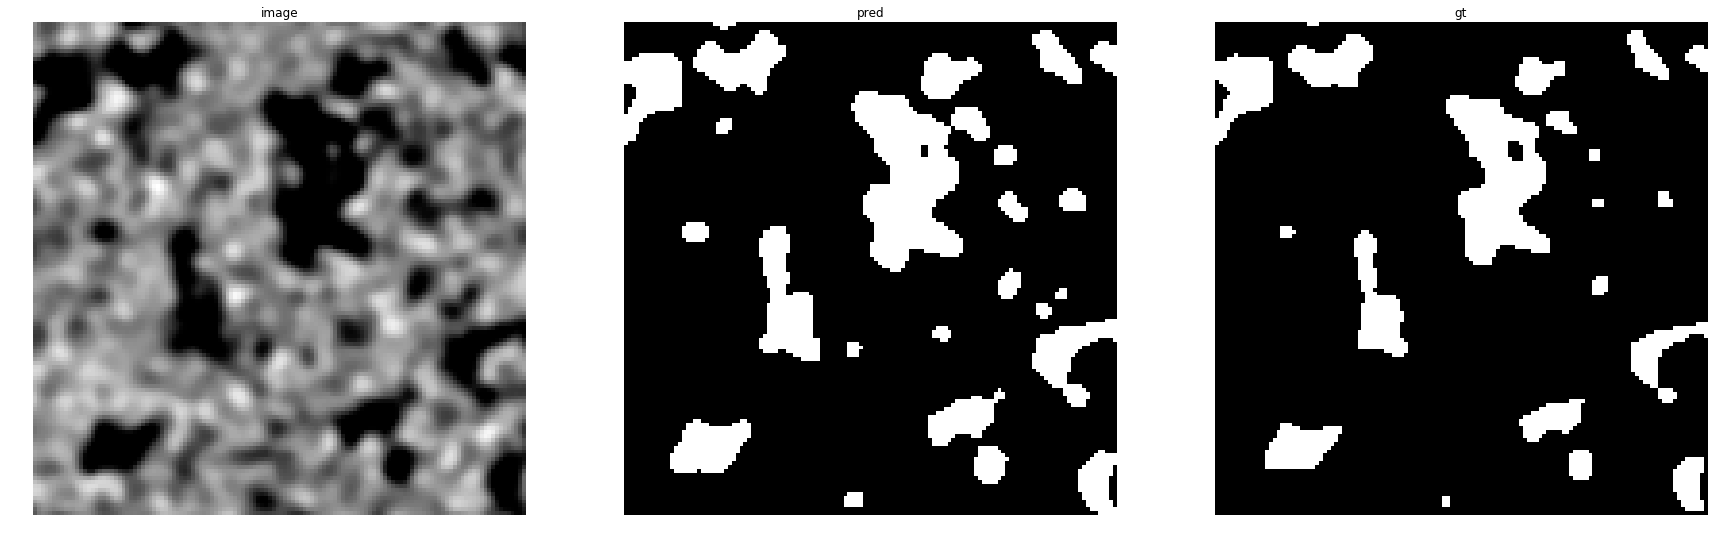

accuracy    : 0.95269775390625
precision   : 0.7401073105298458
recall      : 1.0
f1          : 0.8506455964540374
pr_auc      : 0.9946750360329712
iou         : 0.7401073105298458


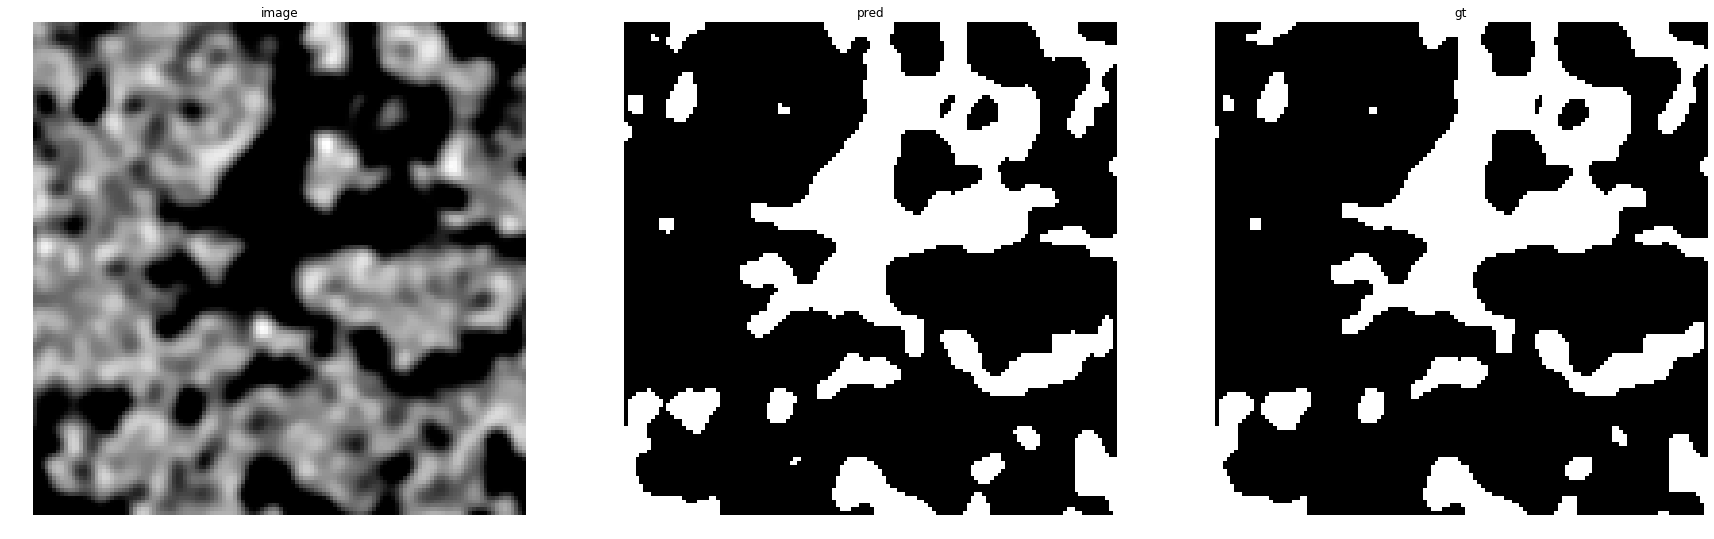

accuracy    : 0.98150634765625
precision   : 0.9461028192371476
recall      : 0.9906663772520078
f1          : 0.967871911780299
pr_auc      : 0.9976466333087026
iou         : 0.9377439901376619


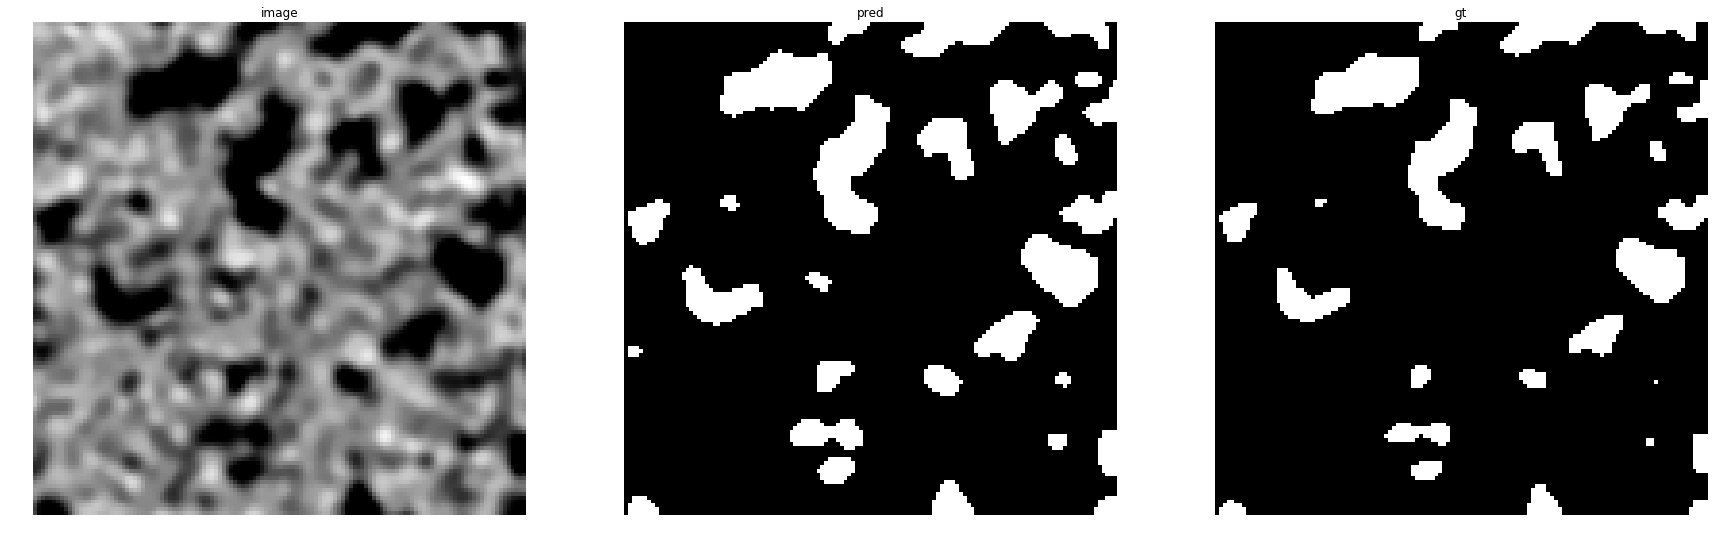

accuracy    : 0.95928955078125
precision   : 0.7558737151248165
recall      : 0.9990295972828724
f1          : 0.8606060606060607
pr_auc      : 0.9946700004753875
iou         : 0.7553191489361702


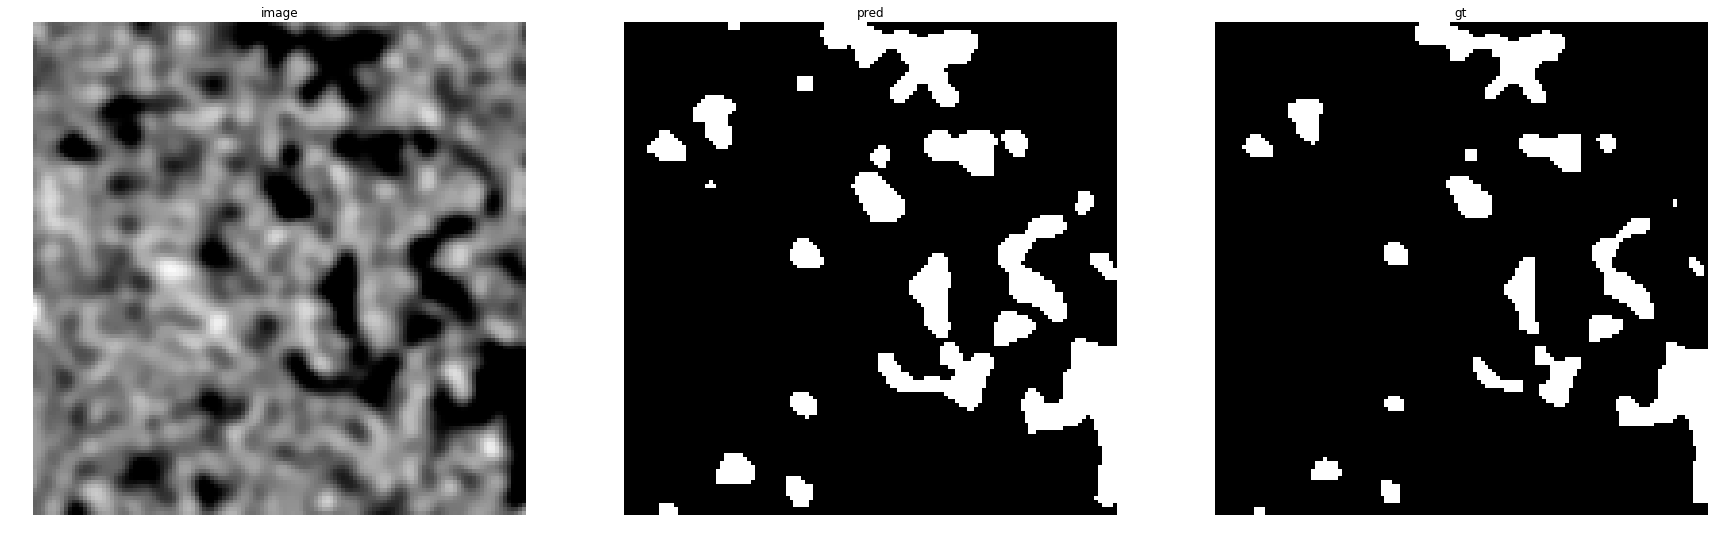

accuracy    : 0.95623779296875
precision   : 0.70125
recall      : 1.0
f1          : 0.8243938280675974
pr_auc      : 0.9917686019996614
iou         : 0.70125


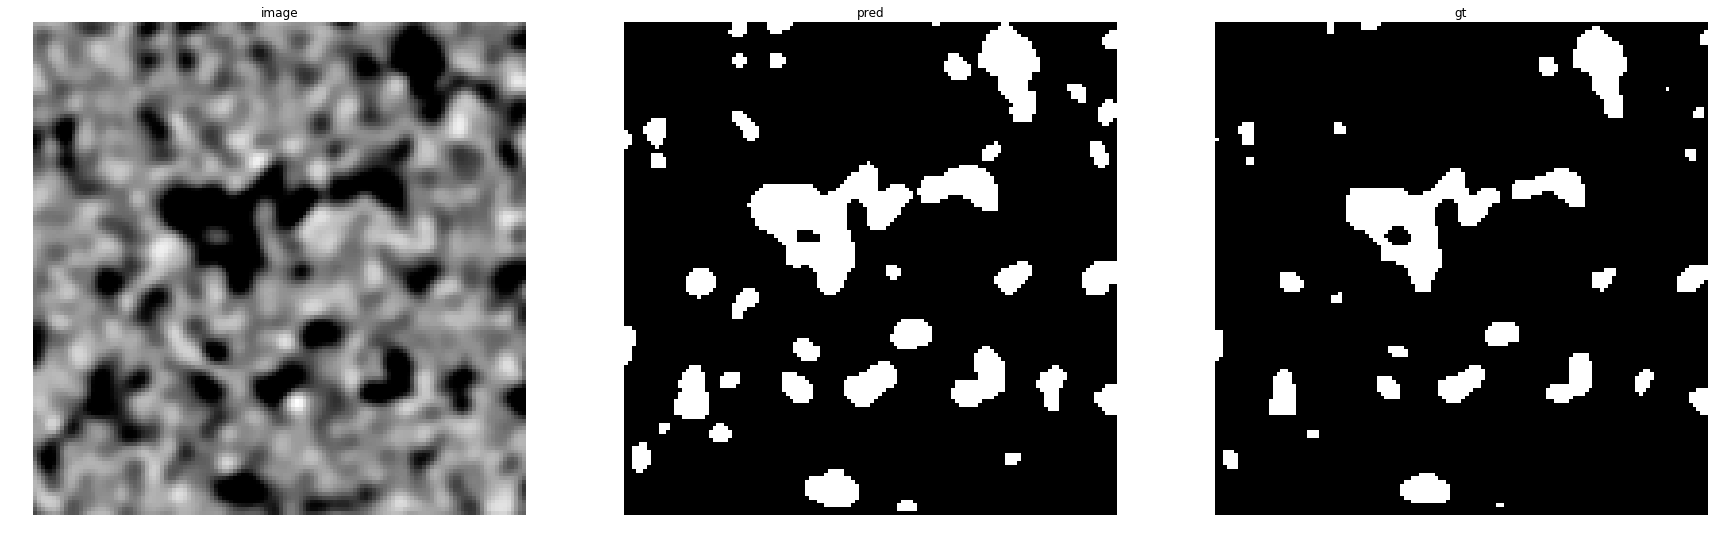

accuracy    : 0.94775390625
precision   : 0.6416910841356216
recall      : 1.0
f1          : 0.7817440081591025
pr_auc      : 0.9890754686721684
iou         : 0.6416910841356216


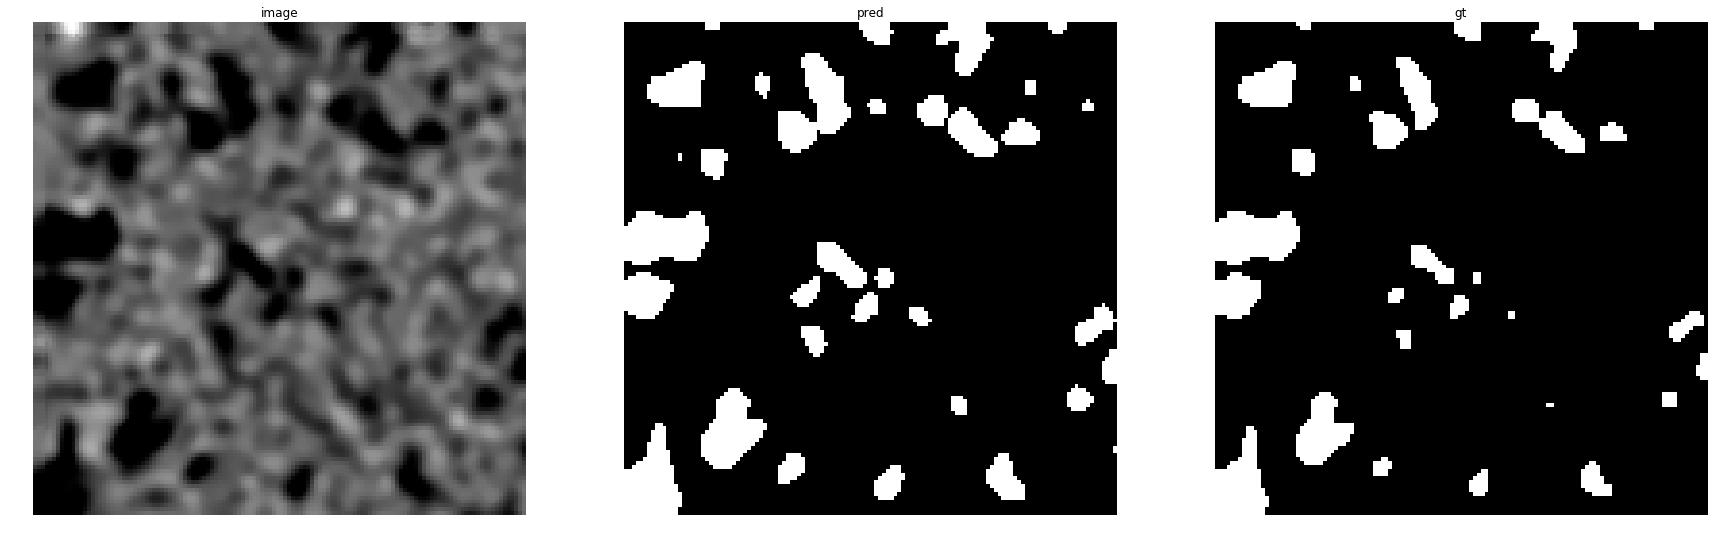

accuracy    : 0.9638671875
precision   : 0.7402482269503546
recall      : 0.9964200477326969
f1          : 0.8494404883011191
pr_auc      : 0.9913726638580042
iou         : 0.7382847038019452


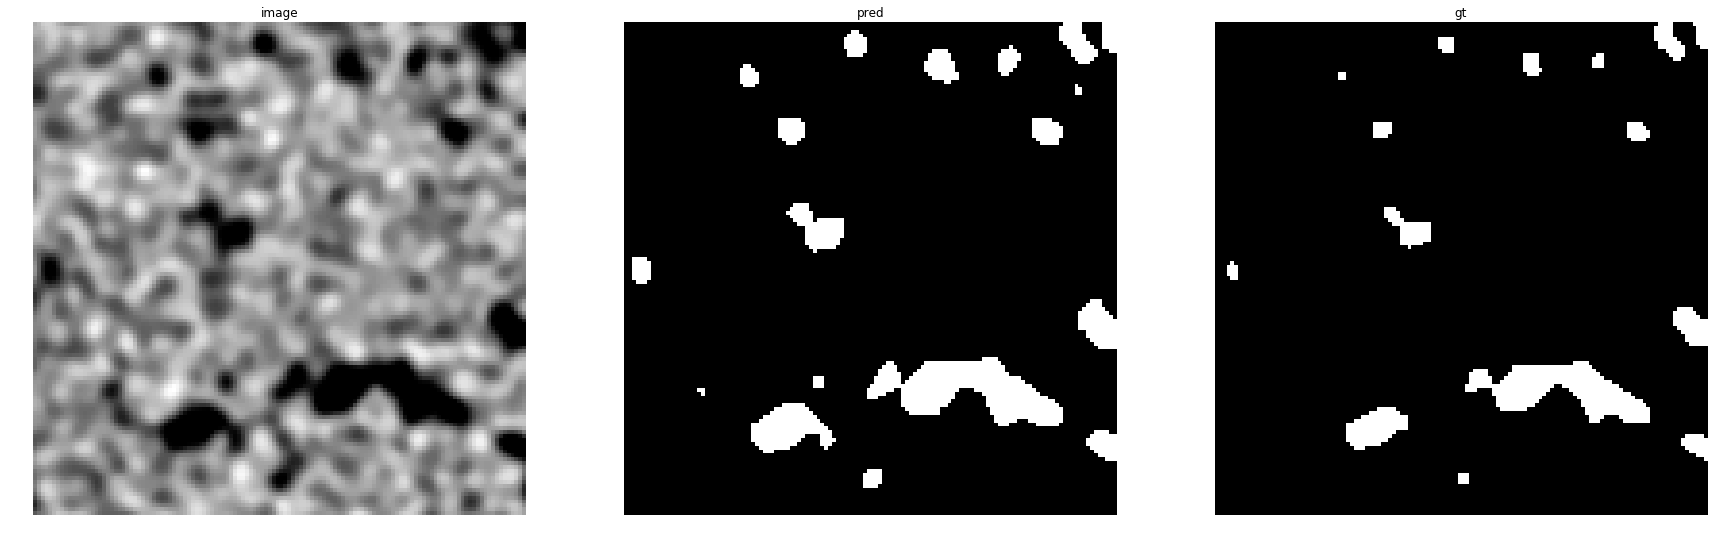

accuracy    : 0.9722900390625
precision   : 0.6550151975683891
recall      : 1.0
f1          : 0.7915518824609734
pr_auc      : 0.9894679656433338
iou         : 0.6550151975683891


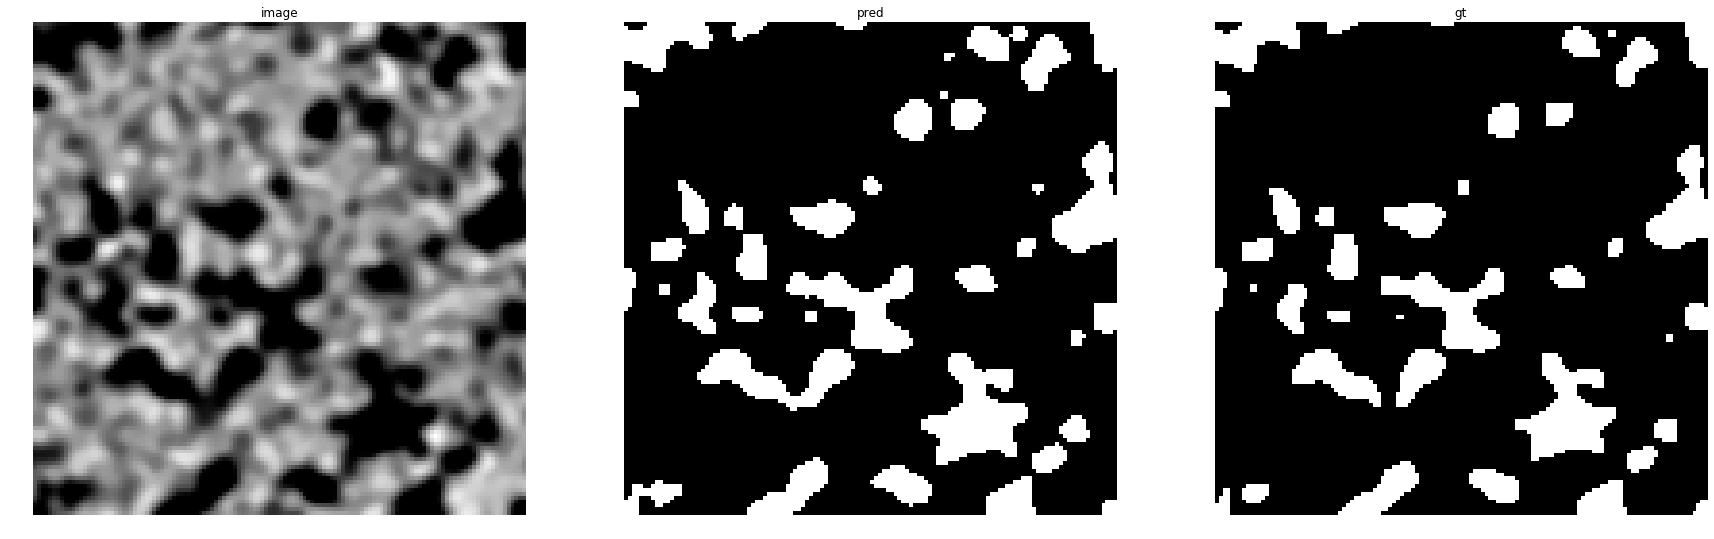

accuracy    : 0.96875
precision   : 0.8419729814640277
recall      : 0.9966530308664932
f1          : 0.9128065395095369
pr_auc      : 0.9934991296328138
iou         : 0.8395989974937343


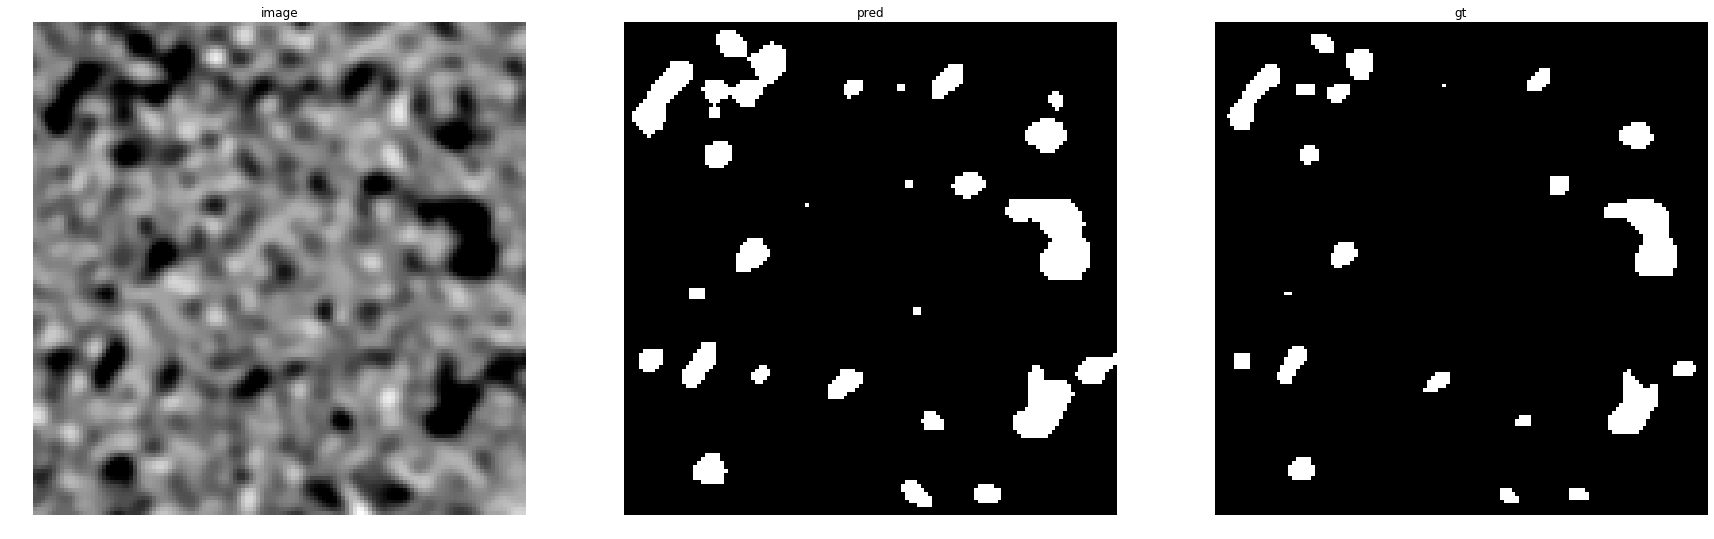

accuracy    : 0.9635009765625
precision   : 0.5986577181208054
recall      : 1.0
f1          : 0.7489504617968095
pr_auc      : 0.9864497899466091
iou         : 0.5986577181208054
carbRNF


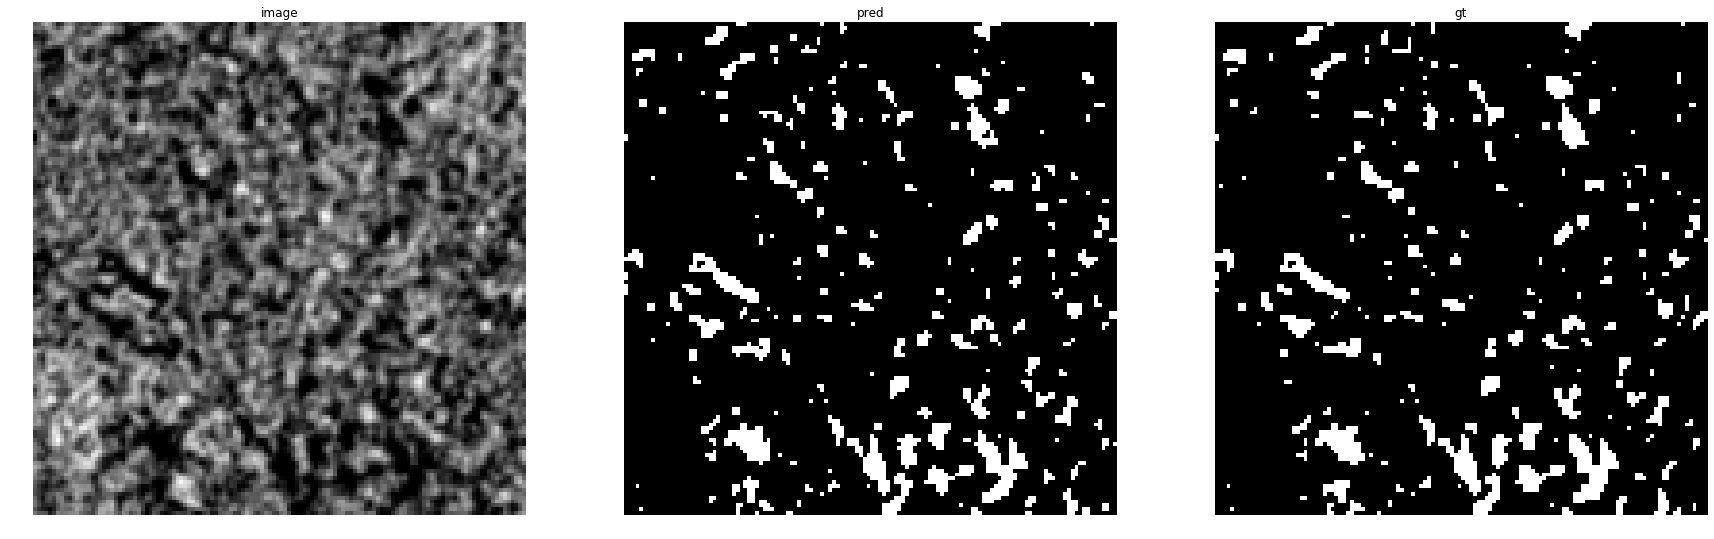

accuracy    : 0.98236083984375
precision   : 0.9128787878787878
recall      : 0.9054477144646211
f1          : 0.9091480666457089
pr_auc      : 0.9759312952101638
iou         : 0.8334293948126801


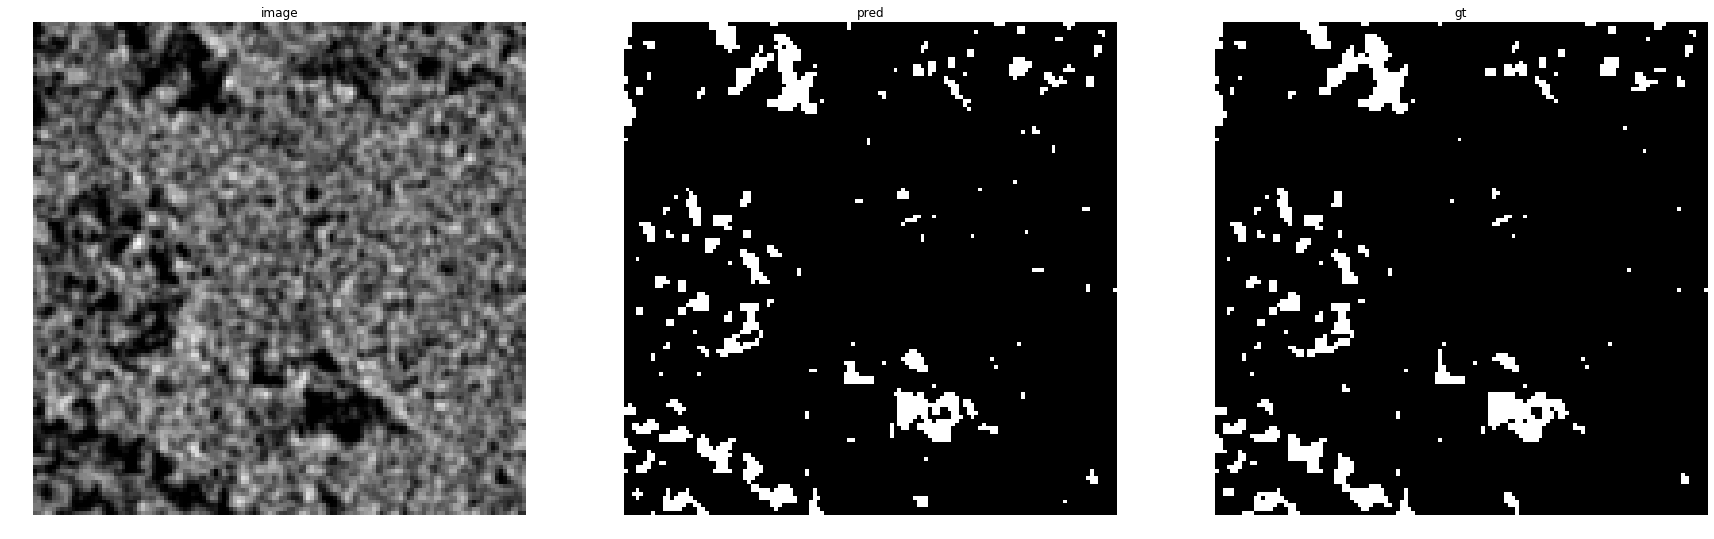

accuracy    : 0.98651123046875
precision   : 0.9064569536423841
recall      : 0.9102244389027432
f1          : 0.9083367897138117
pr_auc      : 0.976234176268927
iou         : 0.8320668693009119


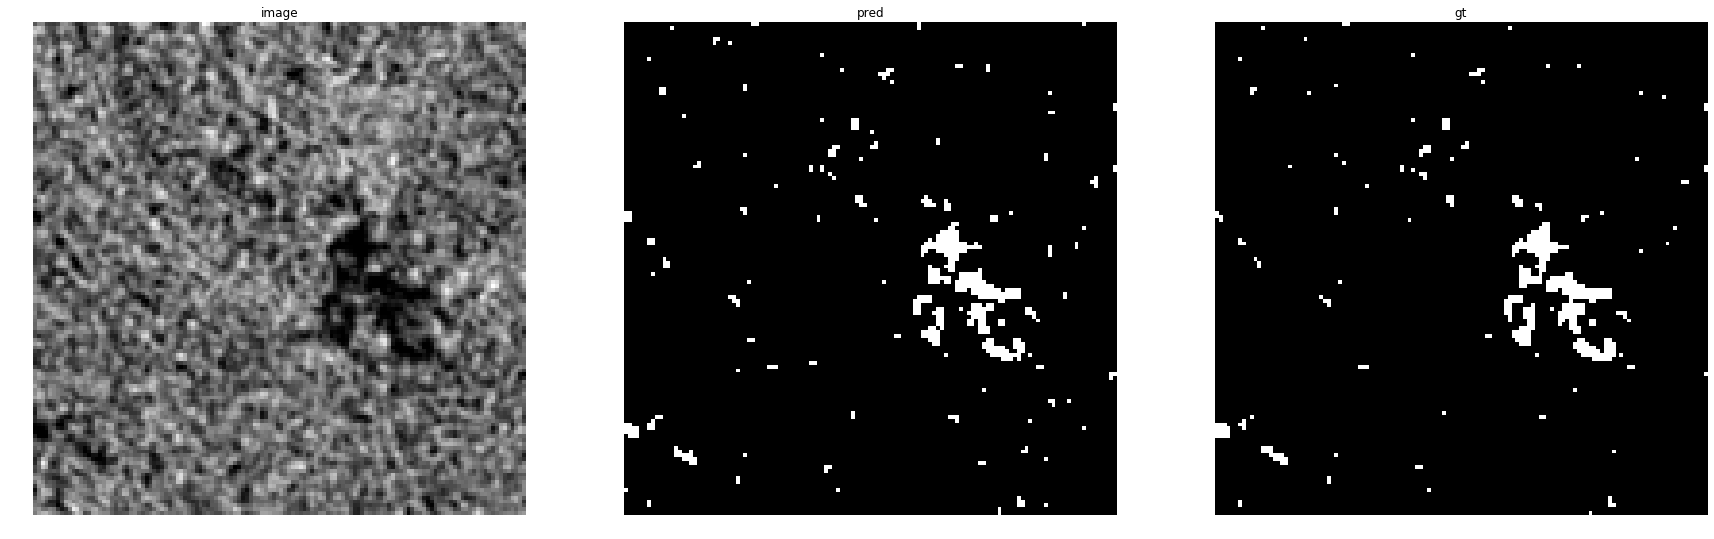

accuracy    : 0.99267578125
precision   : 0.833976833976834
recall      : 0.927038626609442
f1          : 0.8780487804878049
pr_auc      : 0.9594903995212973
iou         : 0.782608695652174


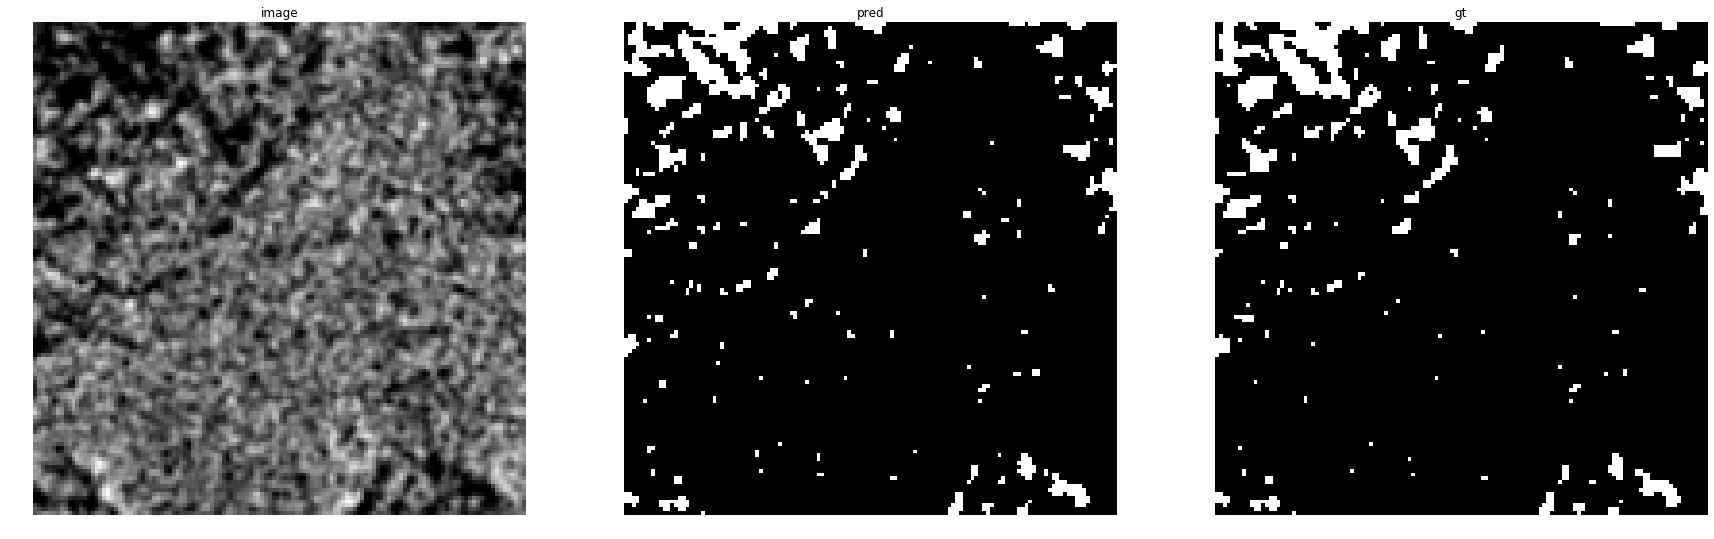

accuracy    : 0.9862060546875
precision   : 0.9167340339531124
recall      : 0.9021479713603818
f1          : 0.9093825180433038
pr_auc      : 0.9746891789208125
iou         : 0.8338235294117647


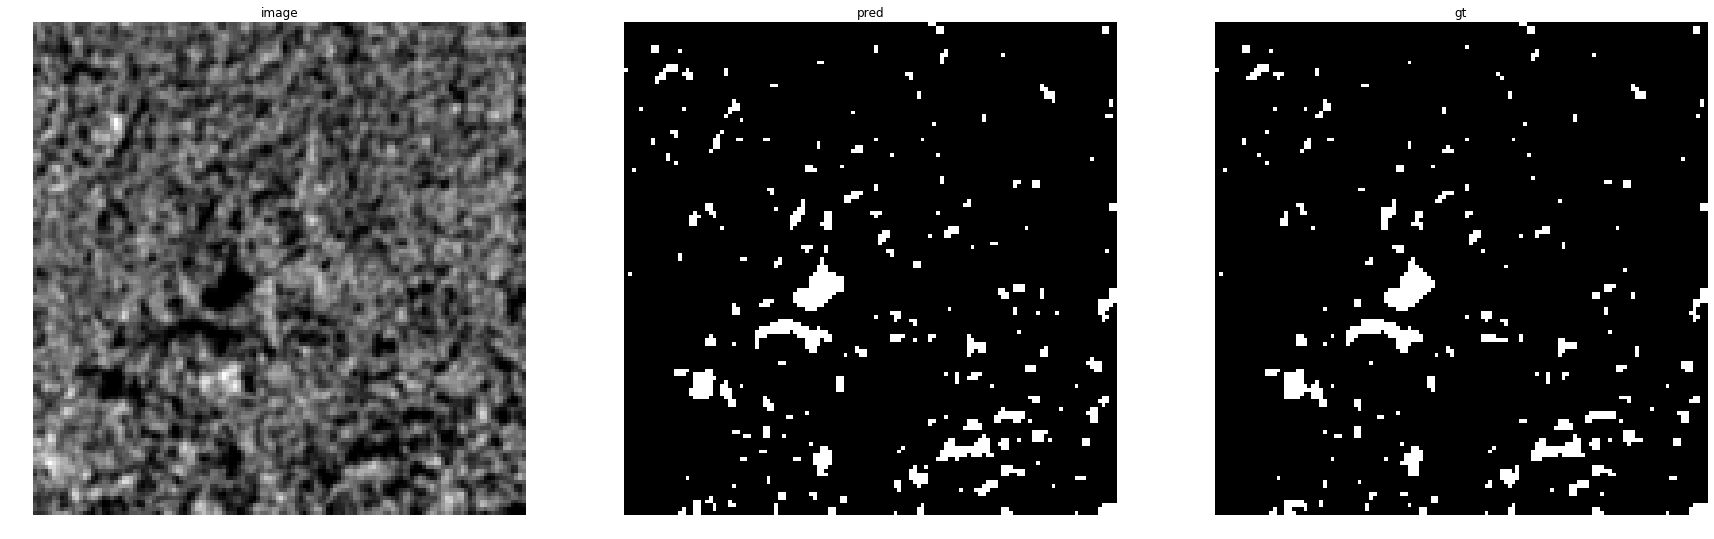

accuracy    : 0.98883056640625
precision   : 0.854122621564482
recall      : 0.9472450175849941
f1          : 0.8982768204558087
pr_auc      : 0.9755659189638144
iou         : 0.8153380423814329


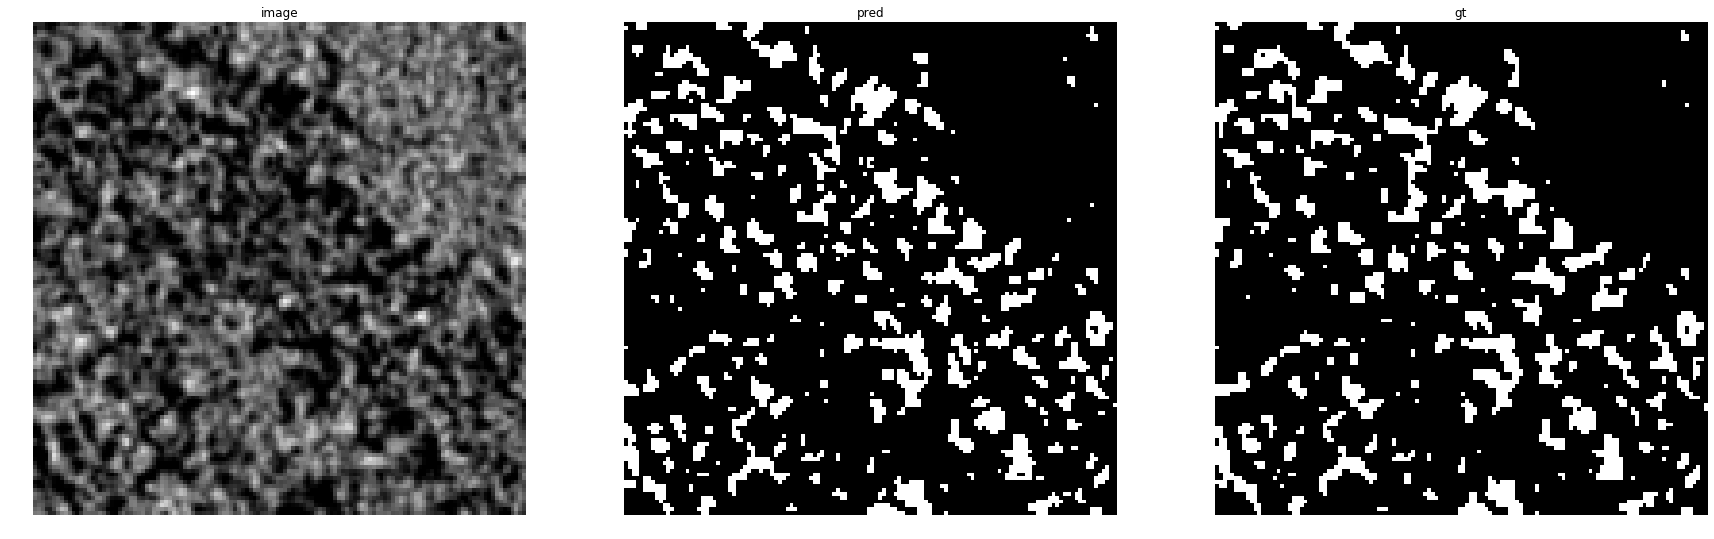

accuracy    : 0.9735107421875
precision   : 0.920706501315295
recall      : 0.9165731387953611
f1          : 0.9186351706036745
pr_auc      : 0.9811040815824129
iou         : 0.8495145631067961


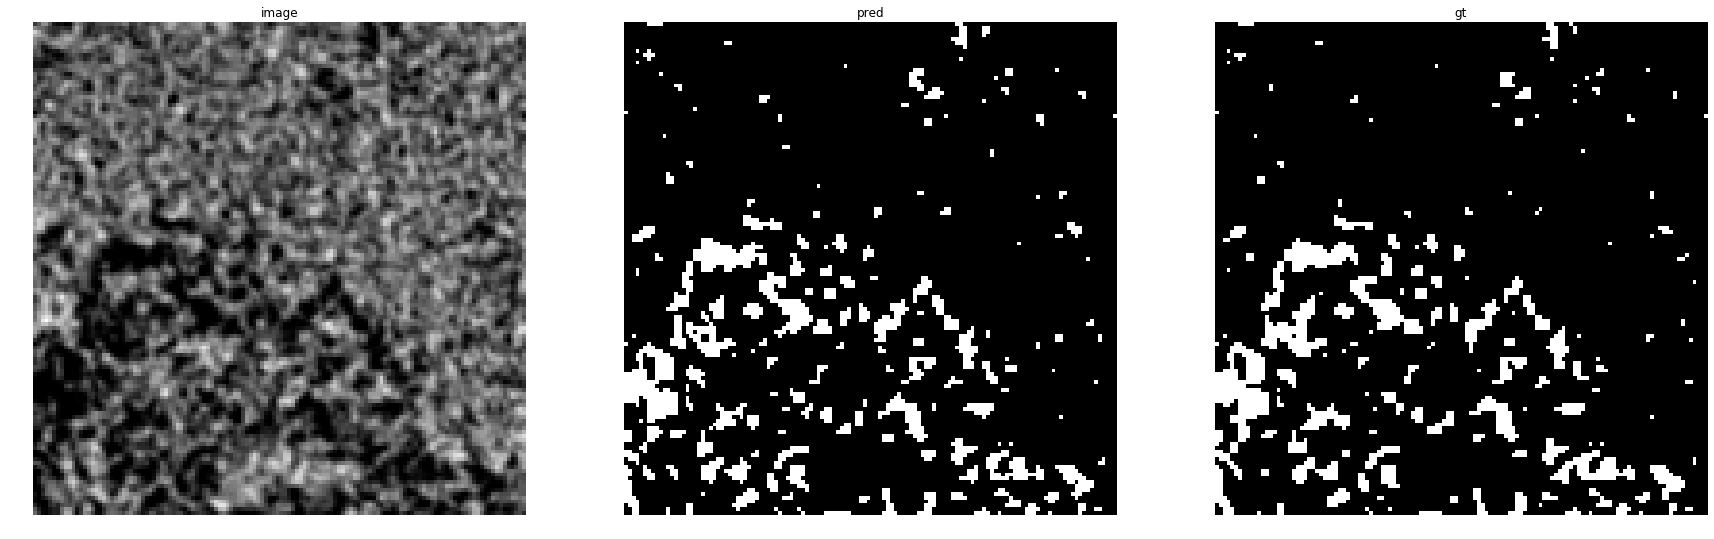

accuracy    : 0.98211669921875
precision   : 0.9042735042735043
recall      : 0.9269859813084113
f1          : 0.9154888952985291
pr_auc      : 0.9803089957771944
iou         : 0.8441489361702128


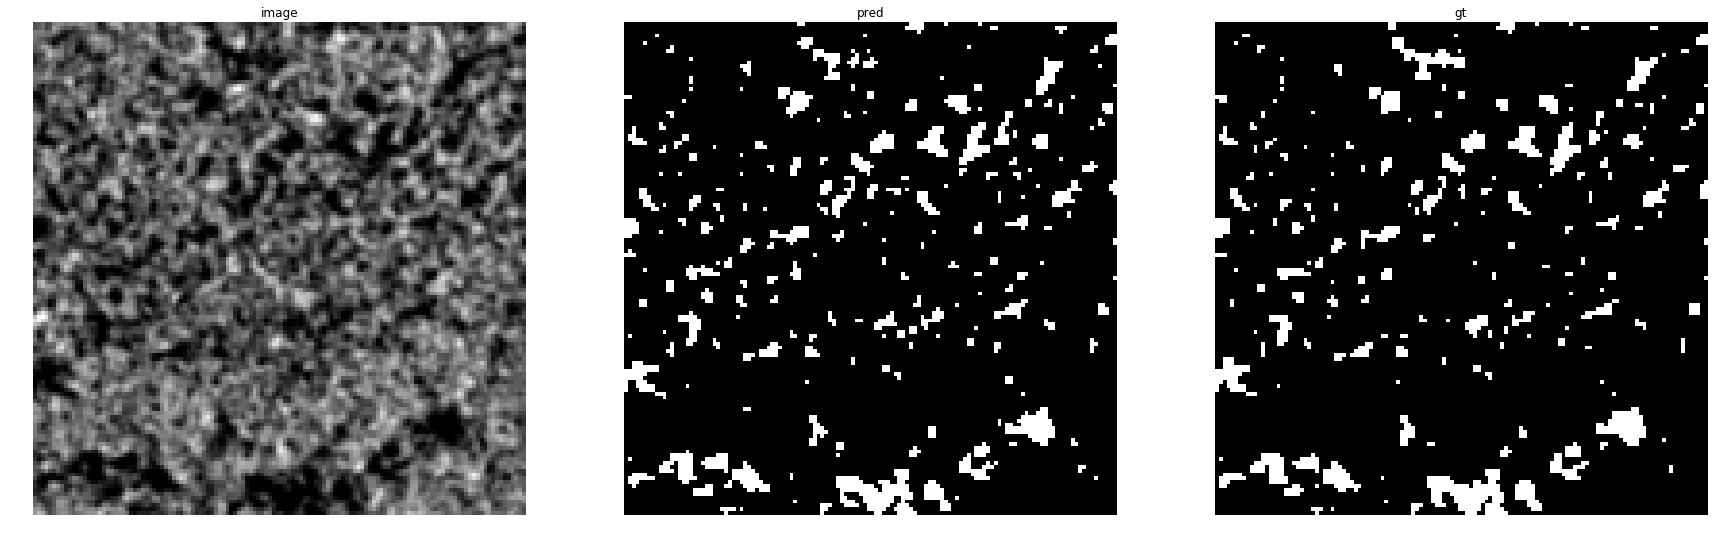

accuracy    : 0.98114013671875
precision   : 0.8843450479233227
recall      : 0.9153439153439153
f1          : 0.899577510562236
pr_auc      : 0.9719839135257756
iou         : 0.8174837566450088


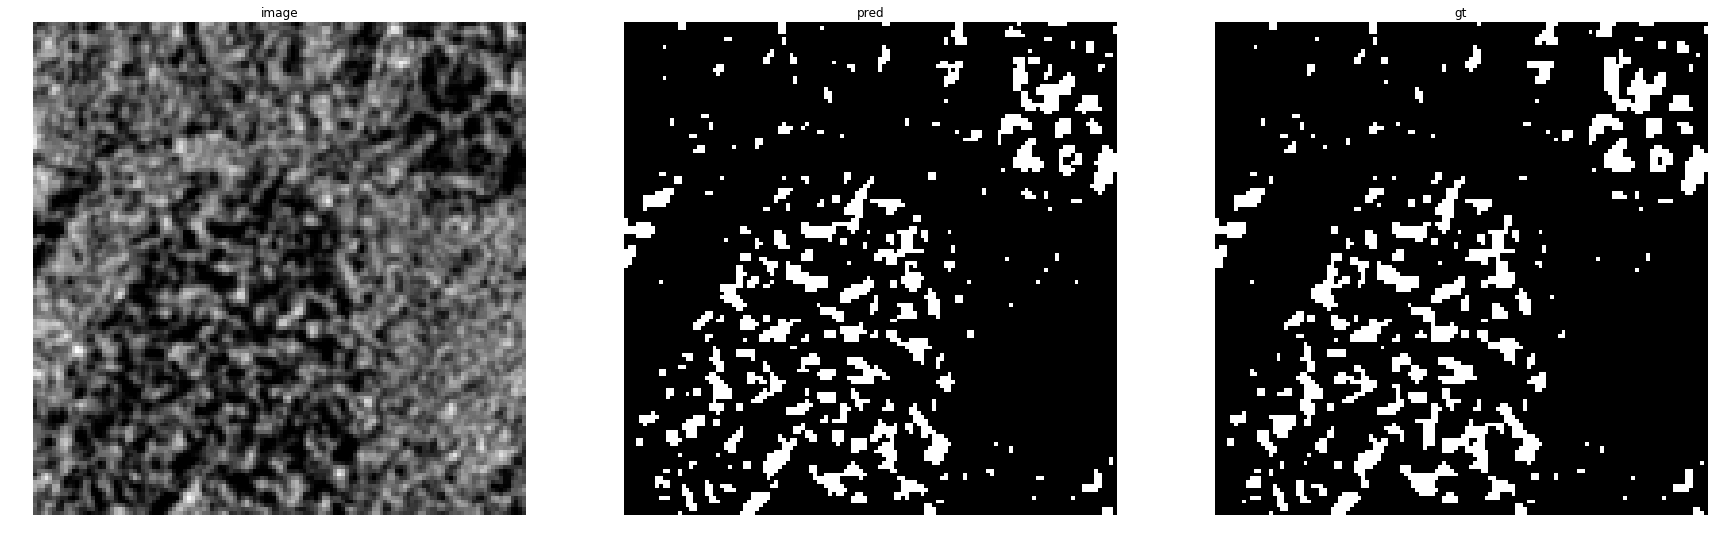

accuracy    : 0.97808837890625
precision   : 0.9305899851264254
recall      : 0.8955152671755725
f1          : 0.9127157792365669
pr_auc      : 0.9770796147437681
iou         : 0.8394454382826476


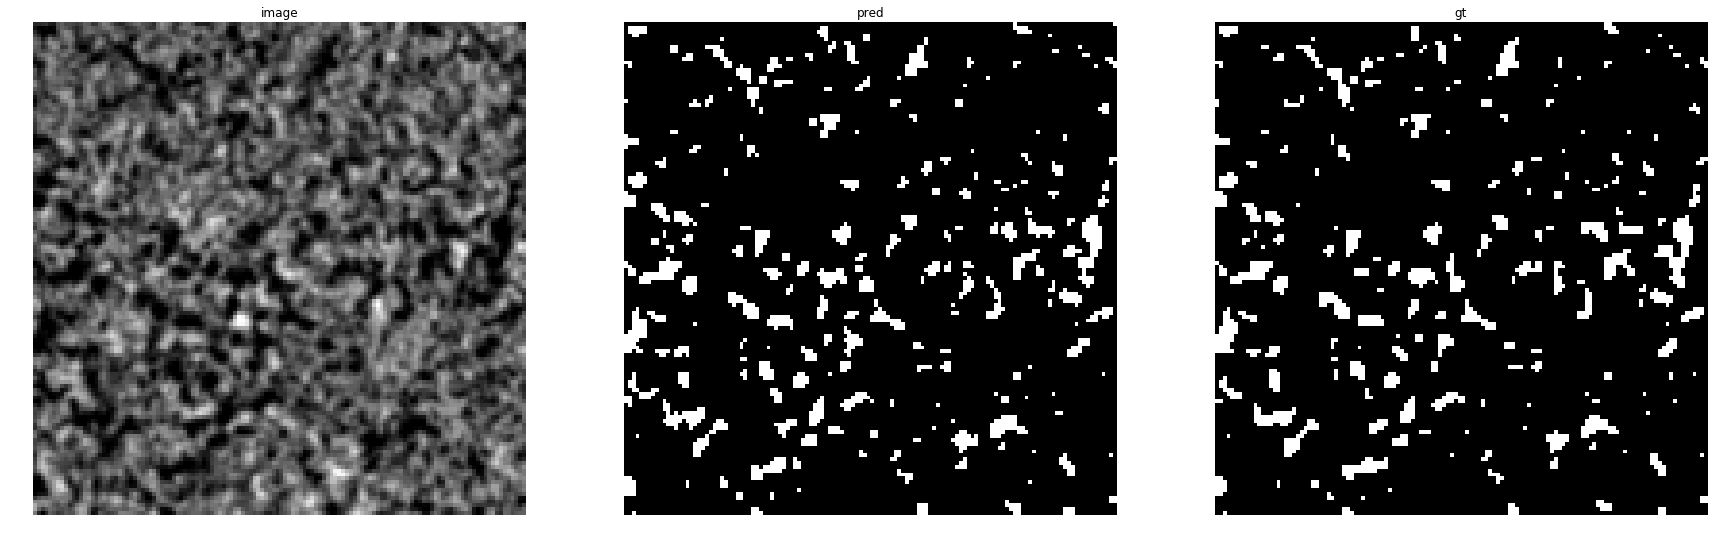

accuracy    : 0.98095703125
precision   : 0.8766603415559773
recall      : 0.9221556886227545
f1          : 0.8988326848249028
pr_auc      : 0.9771427510852215
iou         : 0.8162544169611308
SPE_carb10_58_box3


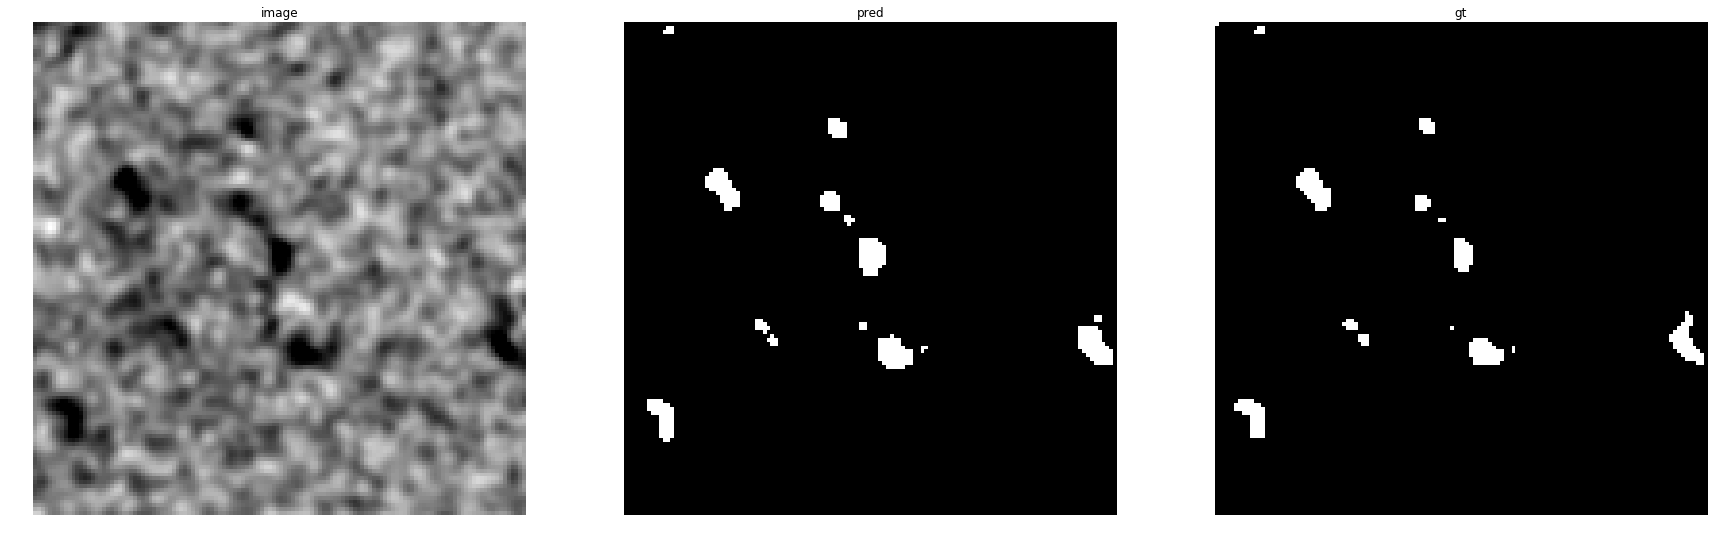

accuracy    : 0.99456787109375
precision   : 0.7983870967741935
recall      : 0.954983922829582
f1          : 0.8696925329428989
pr_auc      : 0.9725561905684479
iou         : 0.7694300518134715


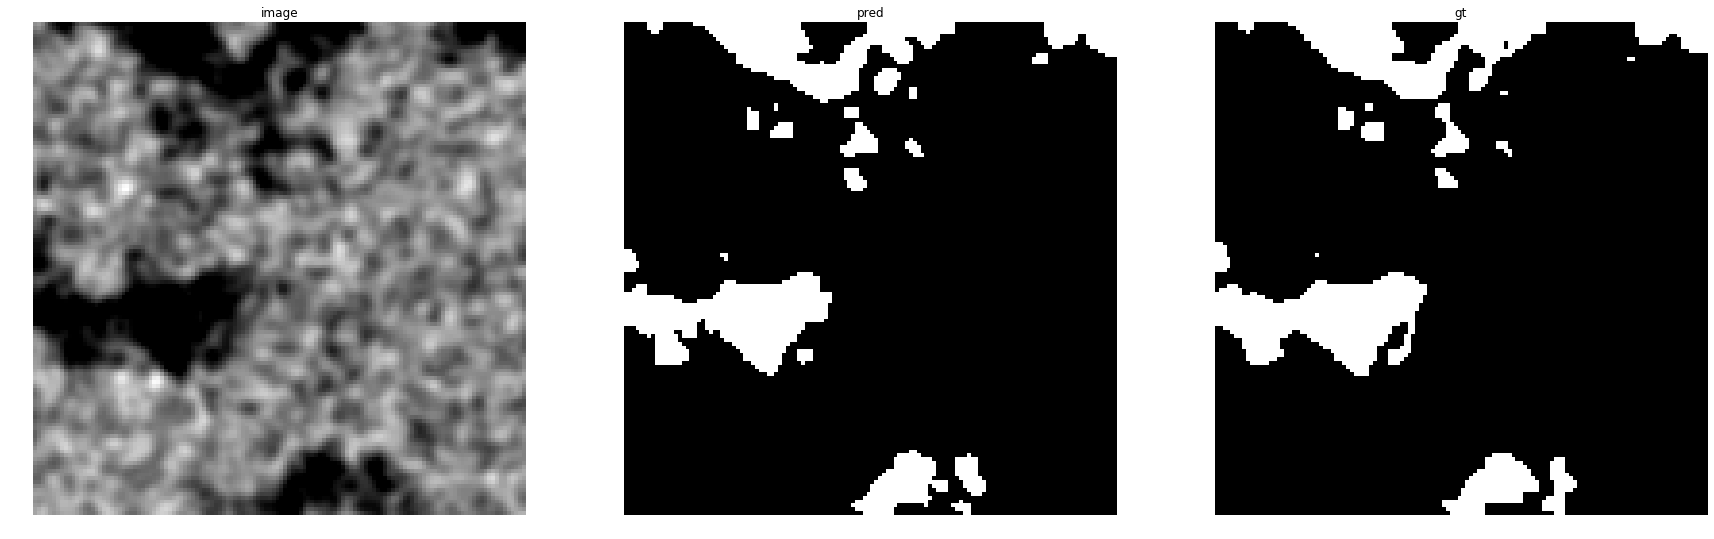

accuracy    : 0.984130859375
precision   : 0.9538162372386971
recall      : 0.922425952045134
f1          : 0.9378585086042064
pr_auc      : 0.990811846817798
iou         : 0.882988298829883


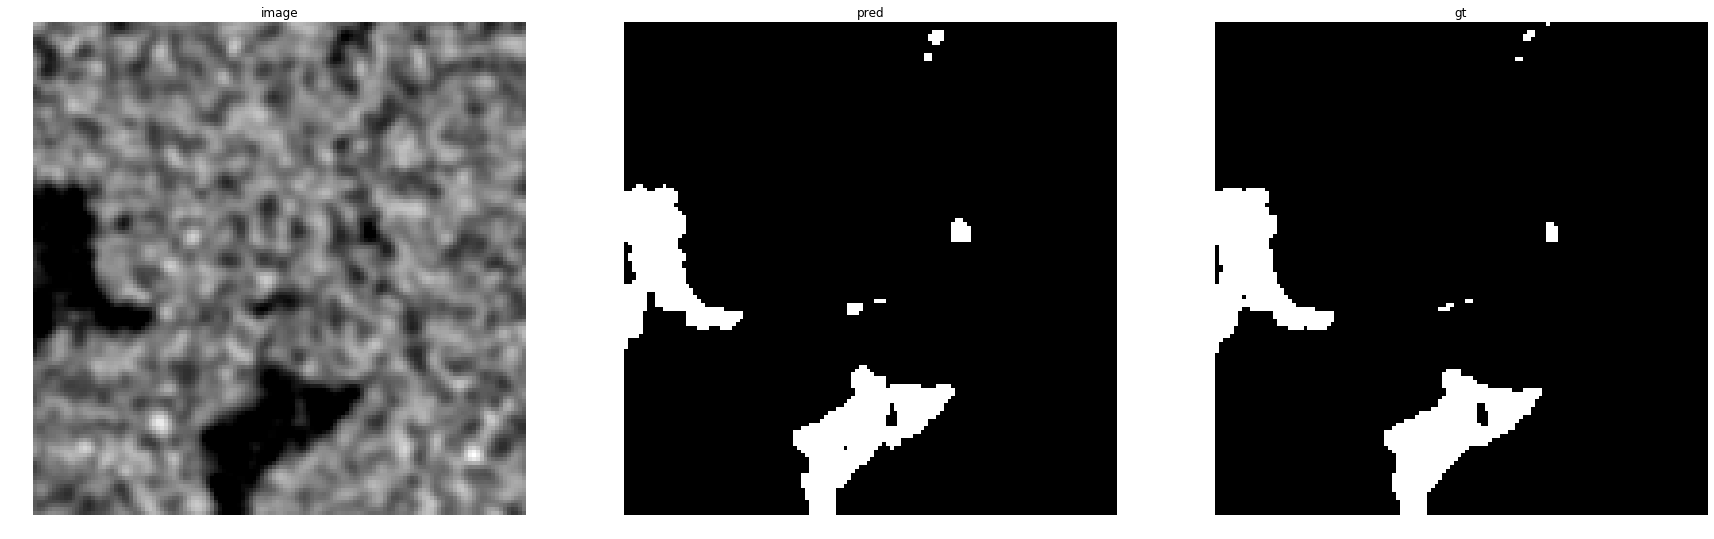

accuracy    : 0.992919921875
precision   : 0.9468085106382979
recall      : 0.9643962848297214
f1          : 0.9555214723926381
pr_auc      : 0.9947010241798634
iou         : 0.9148311306901615


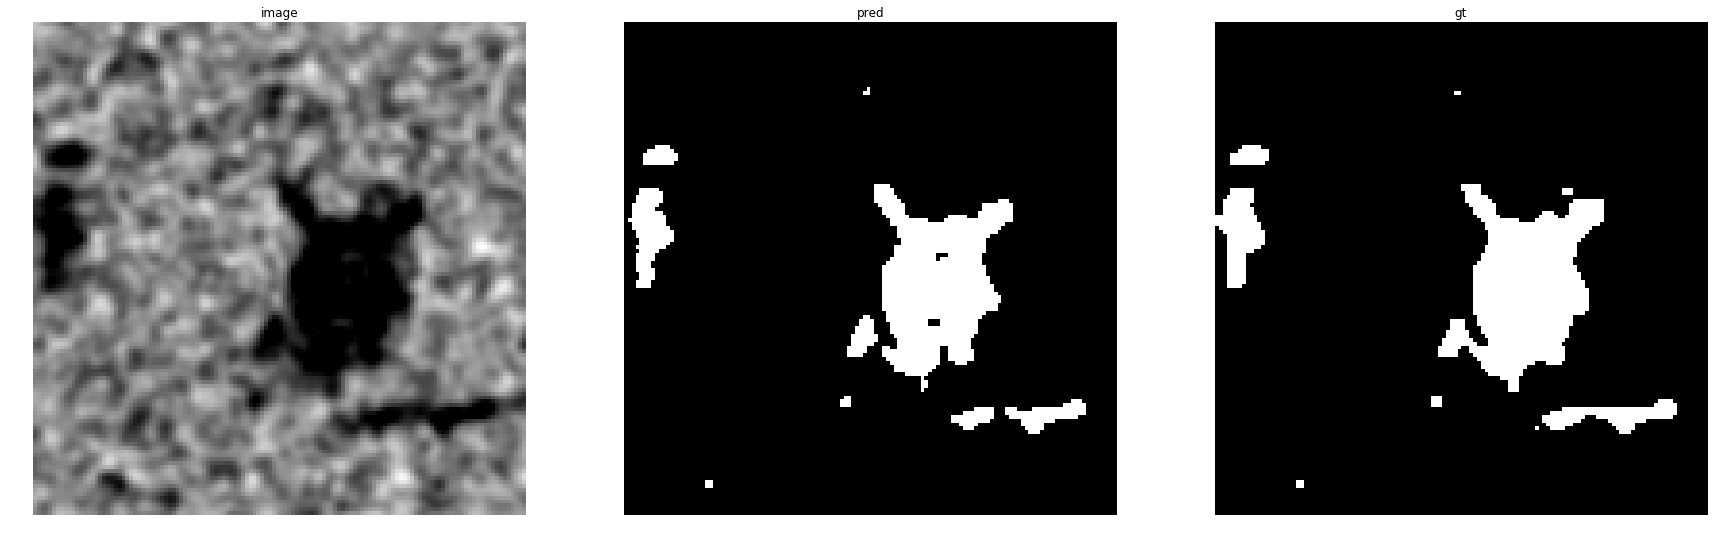

accuracy    : 0.99139404296875
precision   : 0.9932203389830508
recall      : 0.9179197994987469
f1          : 0.9540866167372192
pr_auc      : 0.9964347765136394
iou         : 0.9122042341220423


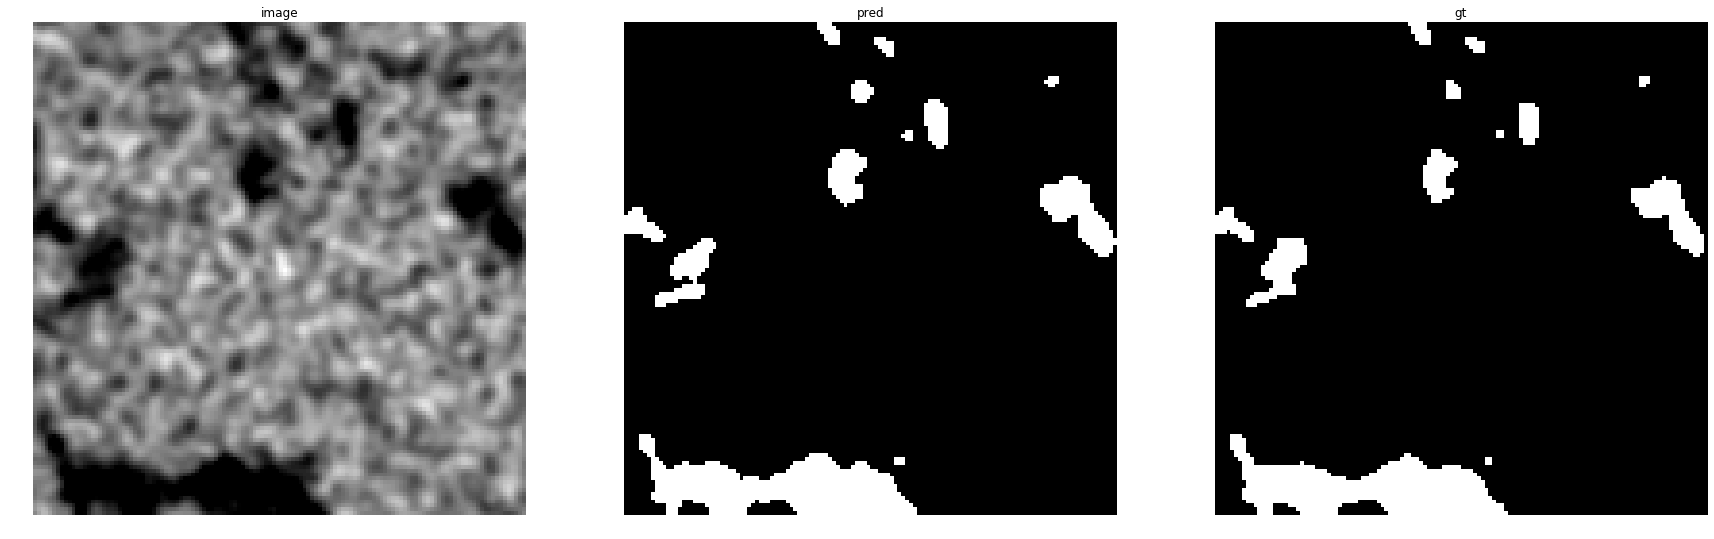

accuracy    : 0.99005126953125
precision   : 0.9169034090909091
recall      : 0.9655946148092744
f1          : 0.9406193078324225
pr_auc      : 0.9912268458578247
iou         : 0.8878954607977991


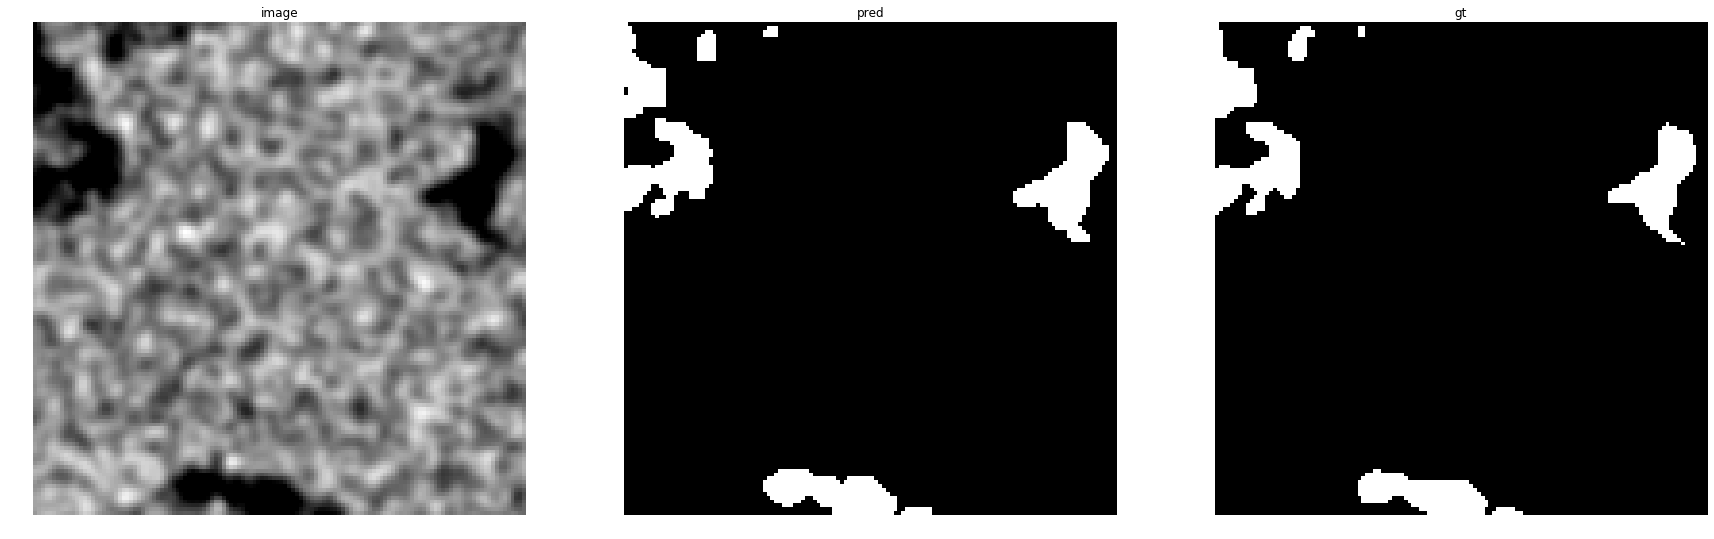

accuracy    : 0.99066162109375
precision   : 0.8869047619047619
recall      : 0.9811853245531514
f1          : 0.9316659222867351
pr_auc      : 0.9926783540657071
iou         : 0.8720735785953178


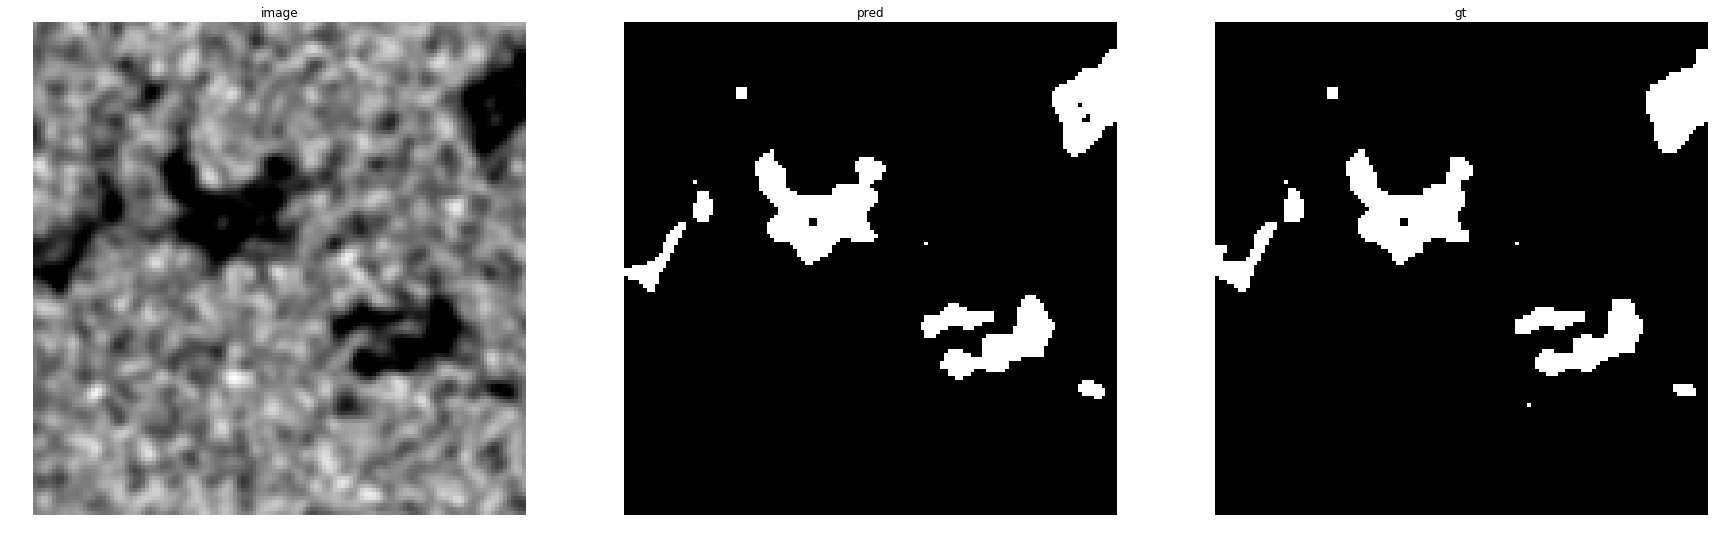

accuracy    : 0.991455078125
precision   : 0.9331797235023042
recall      : 0.9582018927444795
f1          : 0.9455252918287937
pr_auc      : 0.9923173756829239
iou         : 0.8966789667896679


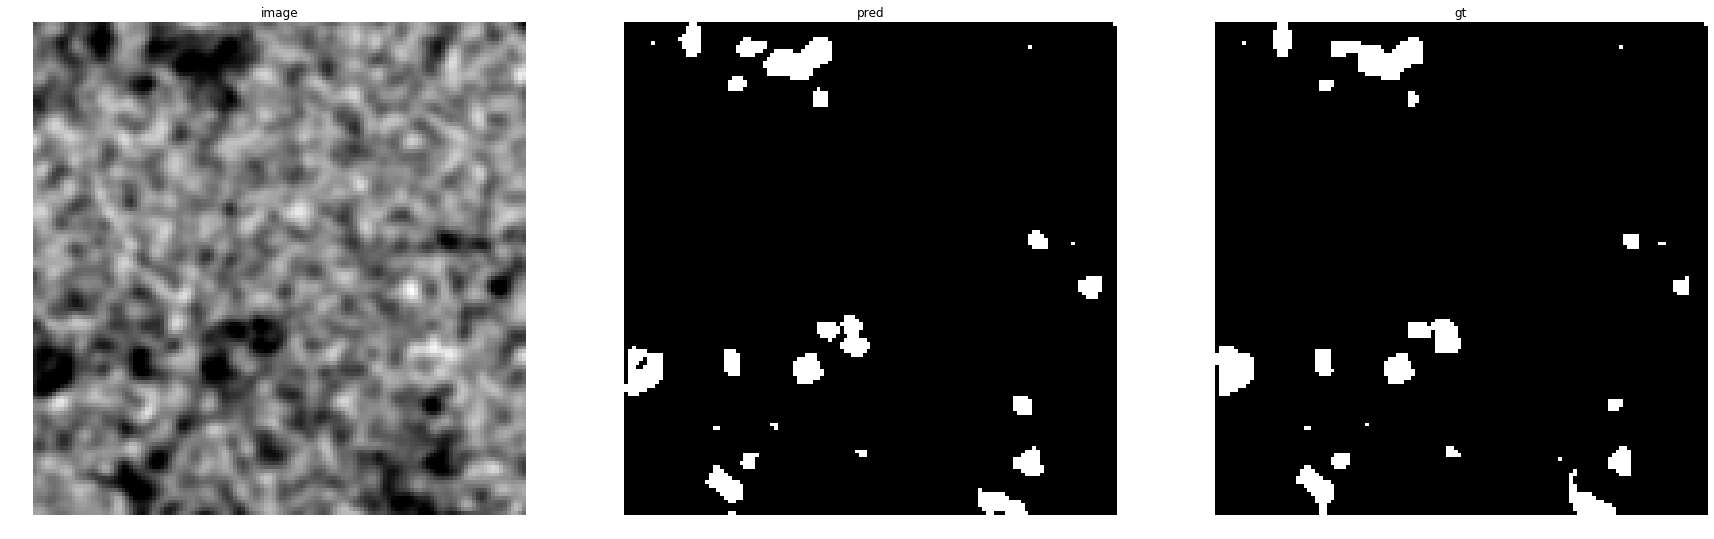

accuracy    : 0.99066162109375
precision   : 0.8807212205270458
recall      : 0.9045584045584045
f1          : 0.8924806746310612
pr_auc      : 0.9701970047476546
iou         : 0.8058375634517766


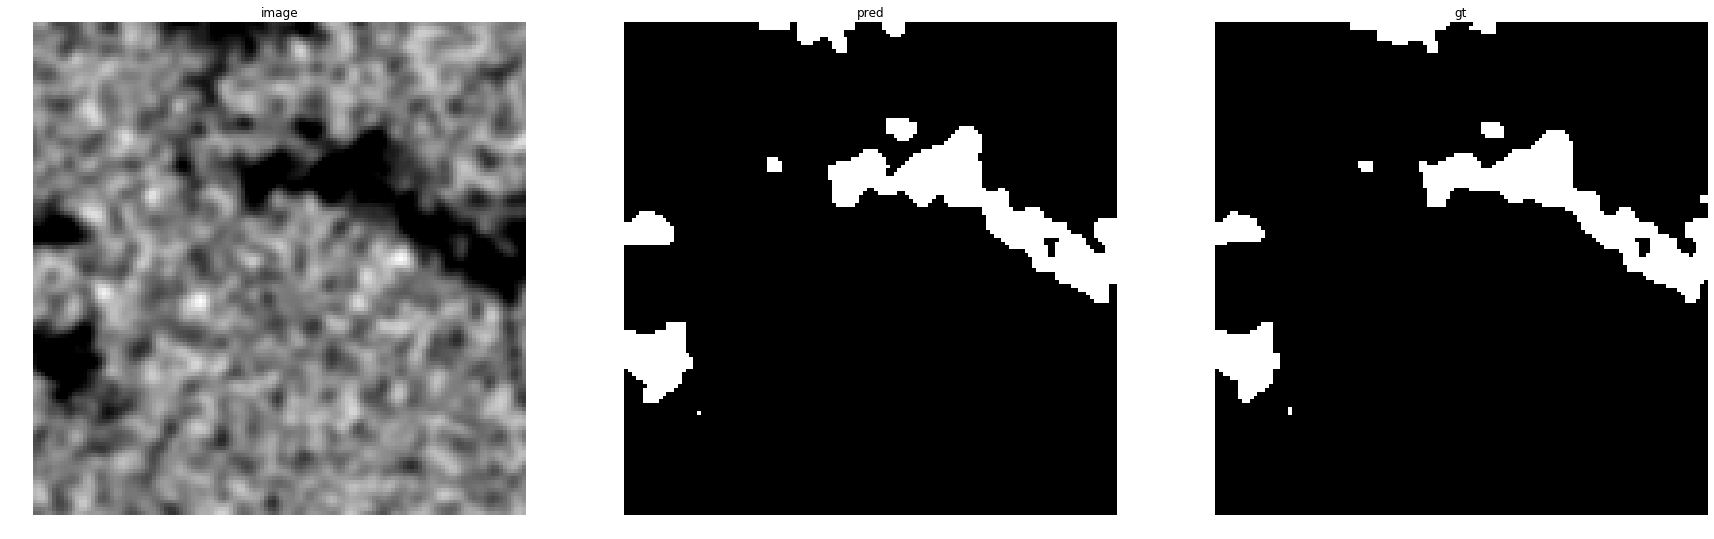

accuracy    : 0.98883056640625
precision   : 0.904887714663144
recall      : 0.9723207948899929
f1          : 0.9373930892918234
pr_auc      : 0.9914381099508915
iou         : 0.8821635544108177


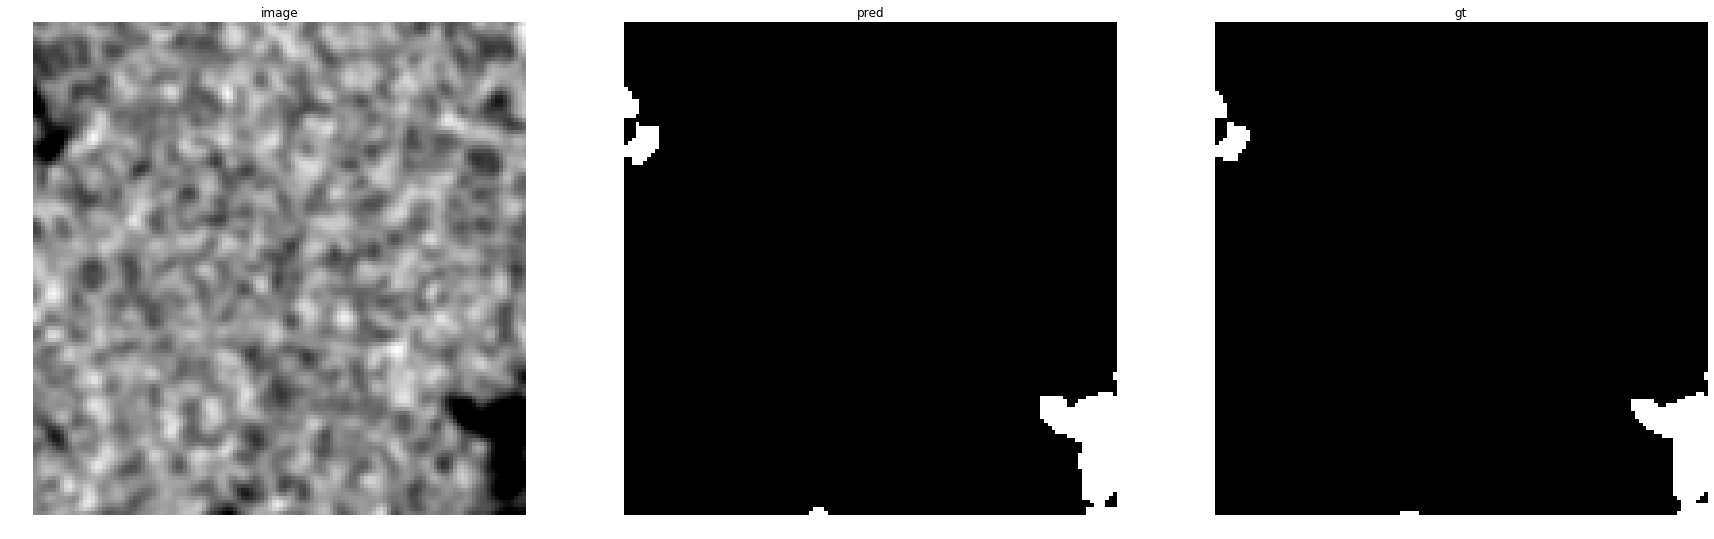

accuracy    : 0.996826171875
precision   : 0.8989247311827957
recall      : 0.9881796690307328
f1          : 0.9414414414414415
pr_auc      : 0.9944977499532357
iou         : 0.8893617021276595
SoilAh-1


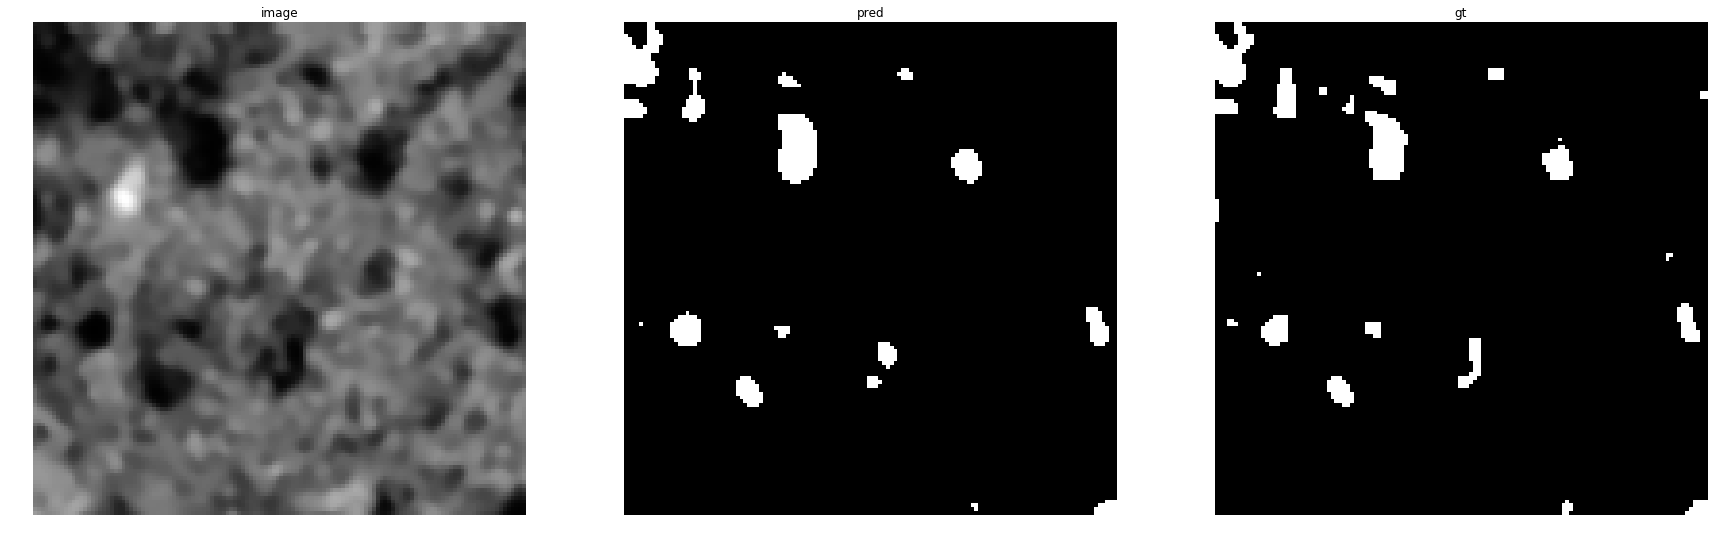

accuracy    : 0.98931884765625
precision   : 0.8869143780290791
recall      : 0.8394495412844036
f1          : 0.8625294579732914
pr_auc      : 0.9528794424372652
iou         : 0.7582872928176796


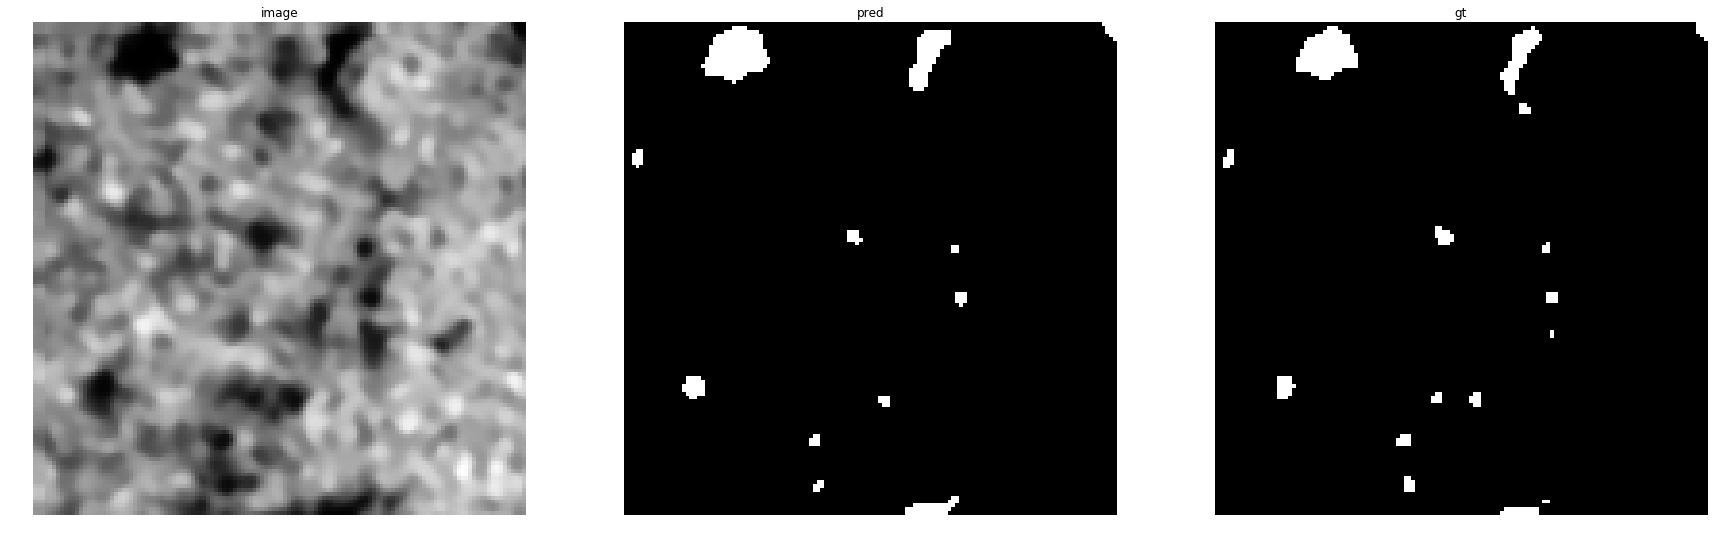

accuracy    : 0.9931640625
precision   : 0.8260869565217391
recall      : 0.8952879581151832
f1          : 0.8592964824120604
pr_auc      : 0.9536407784800213
iou         : 0.7533039647577092


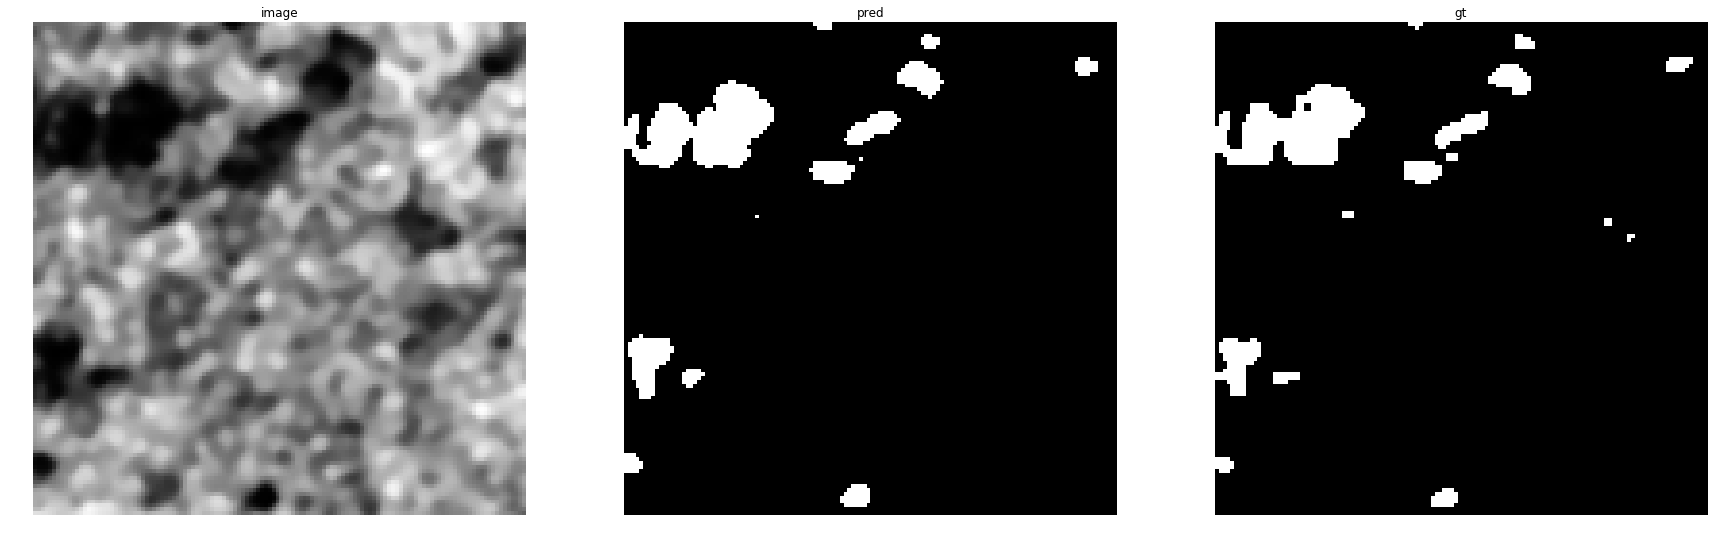

accuracy    : 0.9896240234375
precision   : 0.8814432989690721
recall      : 0.9395604395604396
f1          : 0.9095744680851063
pr_auc      : 0.9810597386733788
iou         : 0.8341463414634146


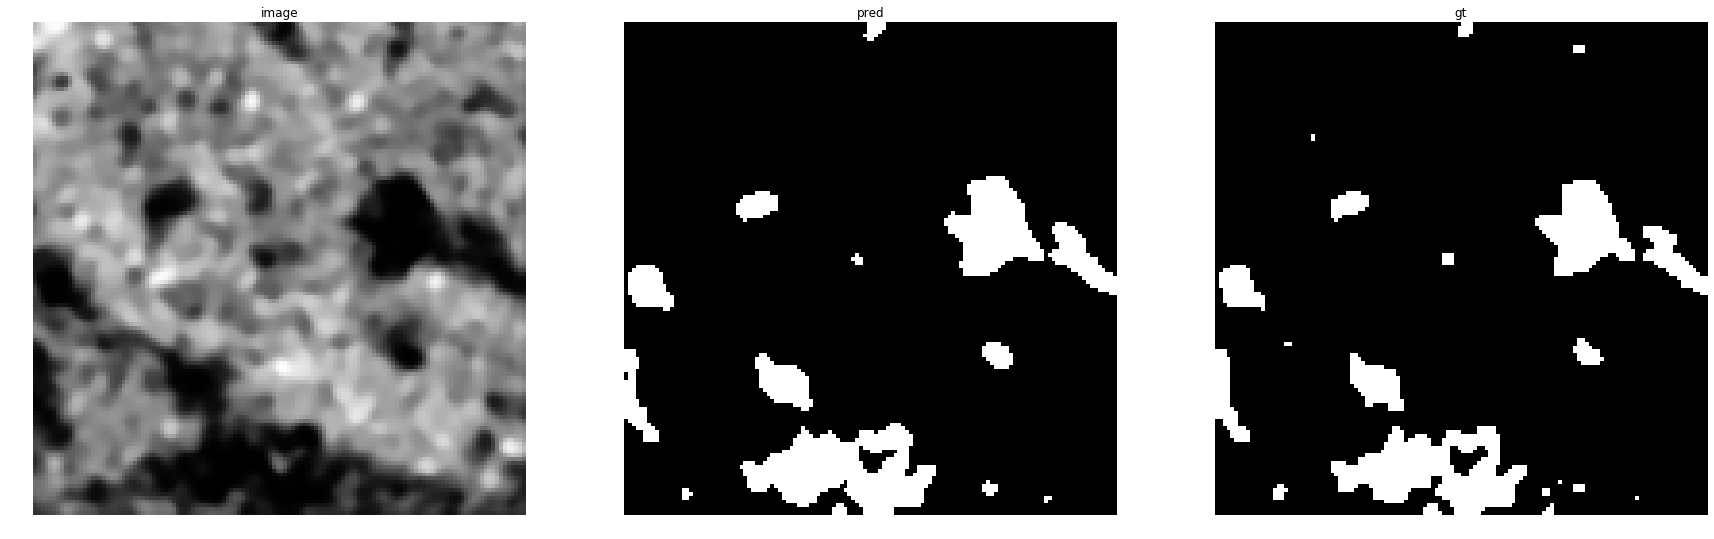

accuracy    : 0.9864501953125
precision   : 0.9073001158748552
recall      : 0.961916461916462
f1          : 0.9338103756708408
pr_auc      : 0.9883727178119006
iou         : 0.8758389261744967


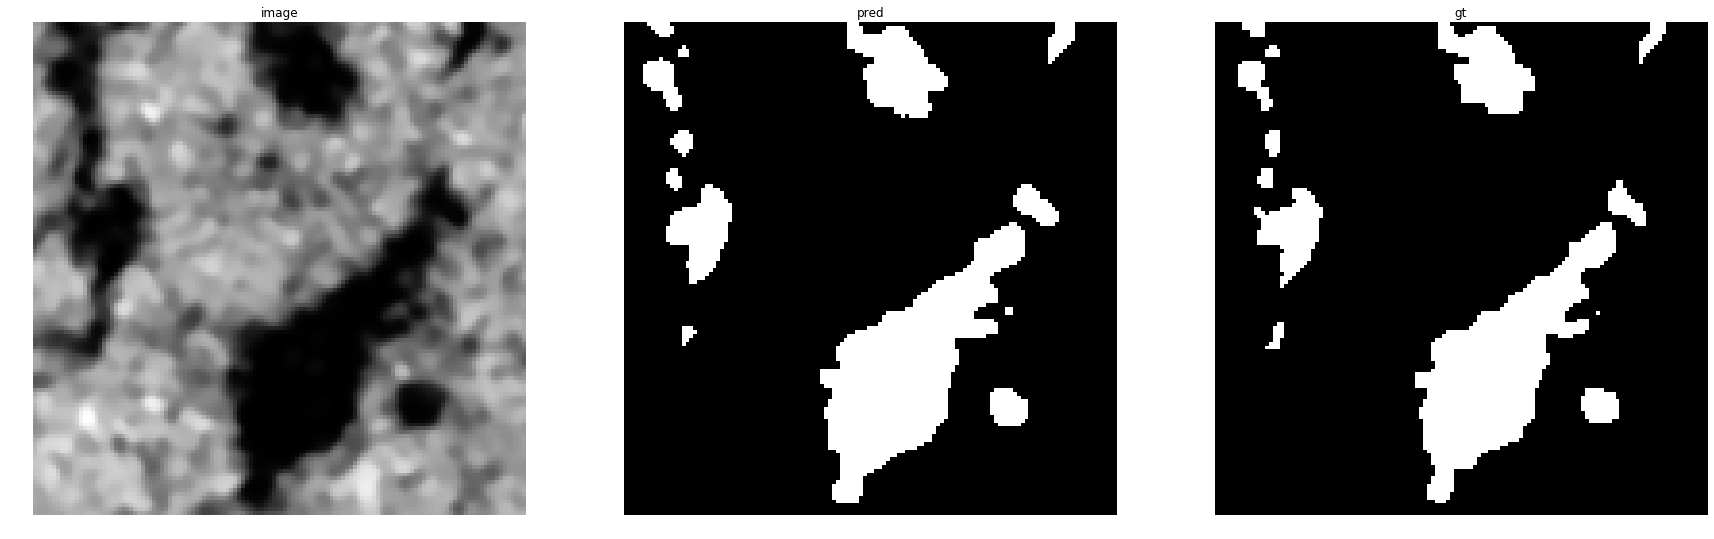

accuracy    : 0.9837646484375
precision   : 0.9095182138660399
recall      : 0.9851506151887993
f1          : 0.9458248472505091
pr_auc      : 0.9954285456283869
iou         : 0.8972179289026275


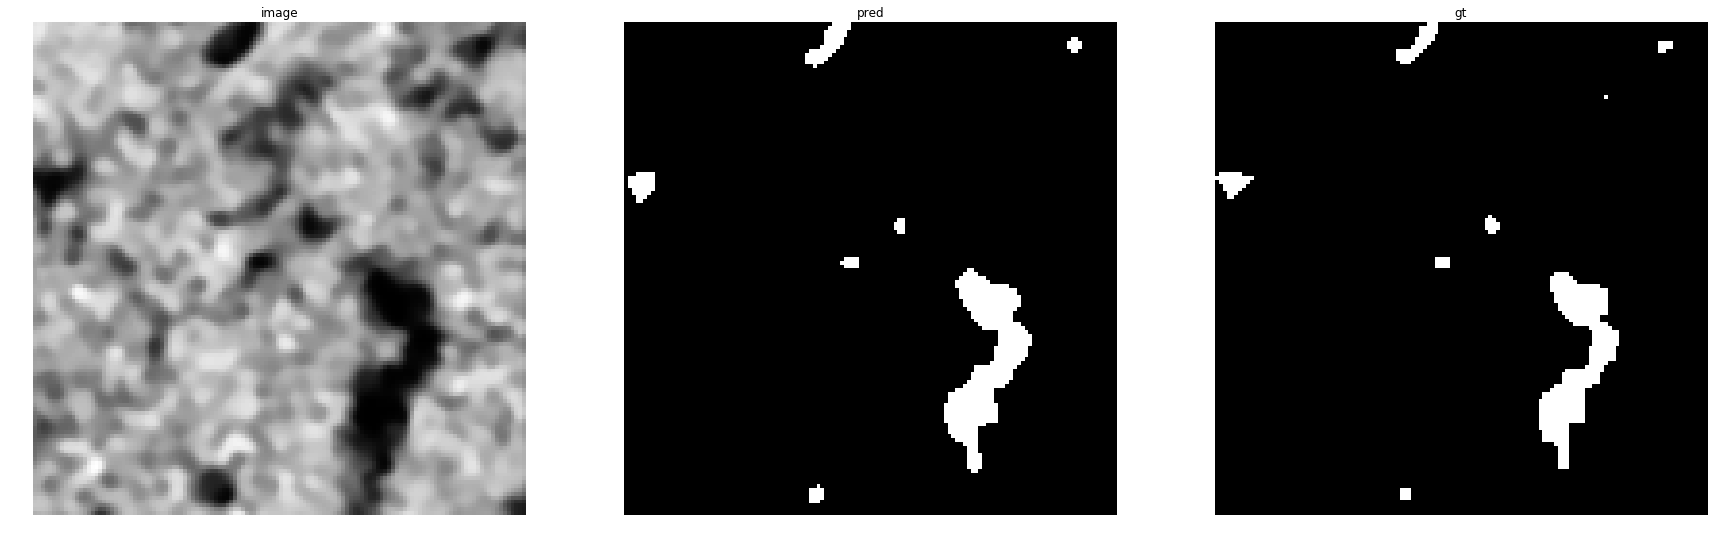

accuracy    : 0.99267578125
precision   : 0.8413897280966768
recall      : 0.9737762237762237
f1          : 0.9027552674230147
pr_auc      : 0.9860084959807068
iou         : 0.8227474150664698


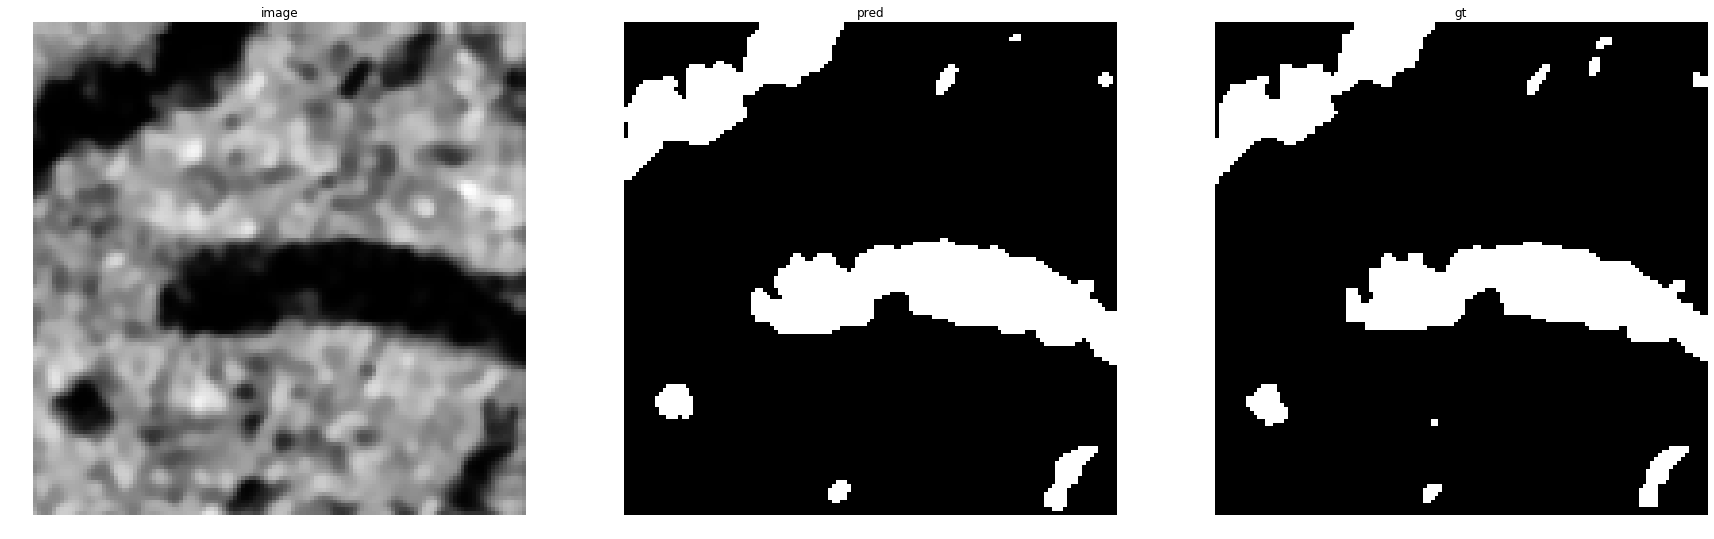

accuracy    : 0.9822998046875
precision   : 0.9126420454545454
recall      : 0.9831675592960979
f1          : 0.9465930018416207
pr_auc      : 0.9957482325229312
iou         : 0.8986013986013986


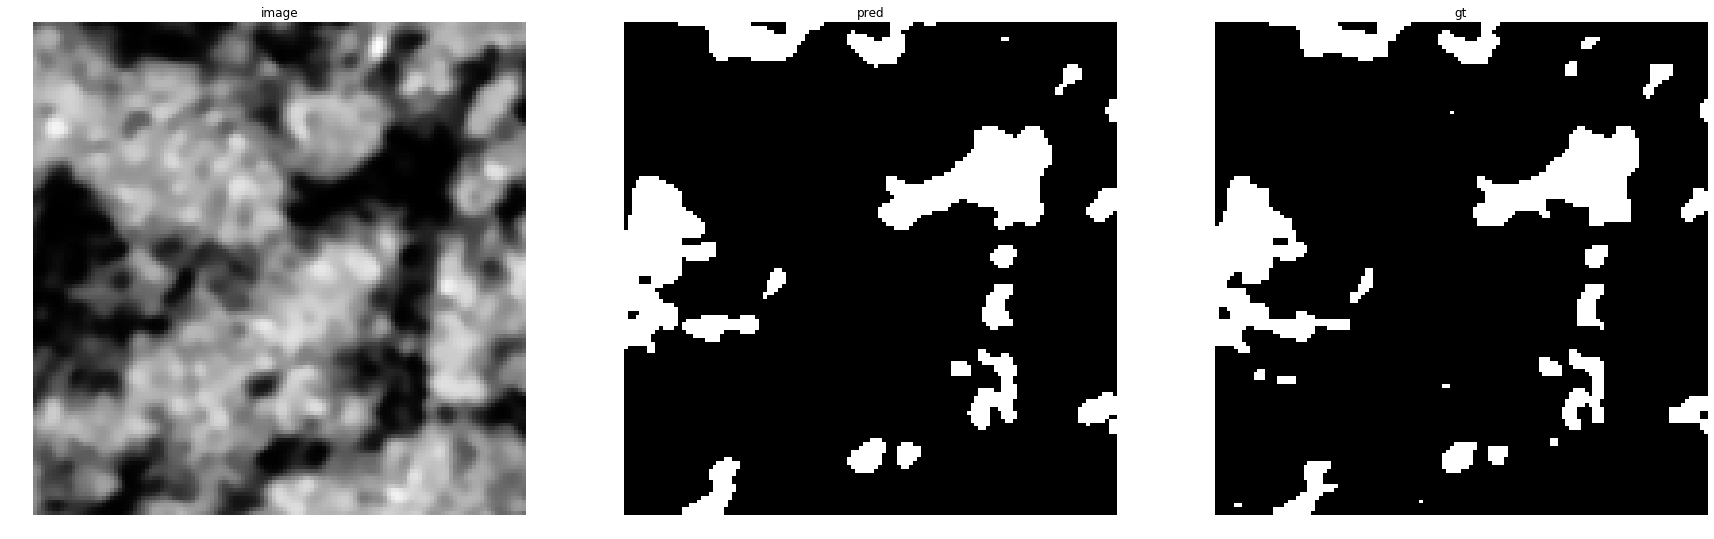

accuracy    : 0.97705078125
precision   : 0.8898233809924306
recall      : 0.9488789237668162
f1          : 0.9184027777777778
pr_auc      : 0.9839120295298721
iou         : 0.8491171749598716


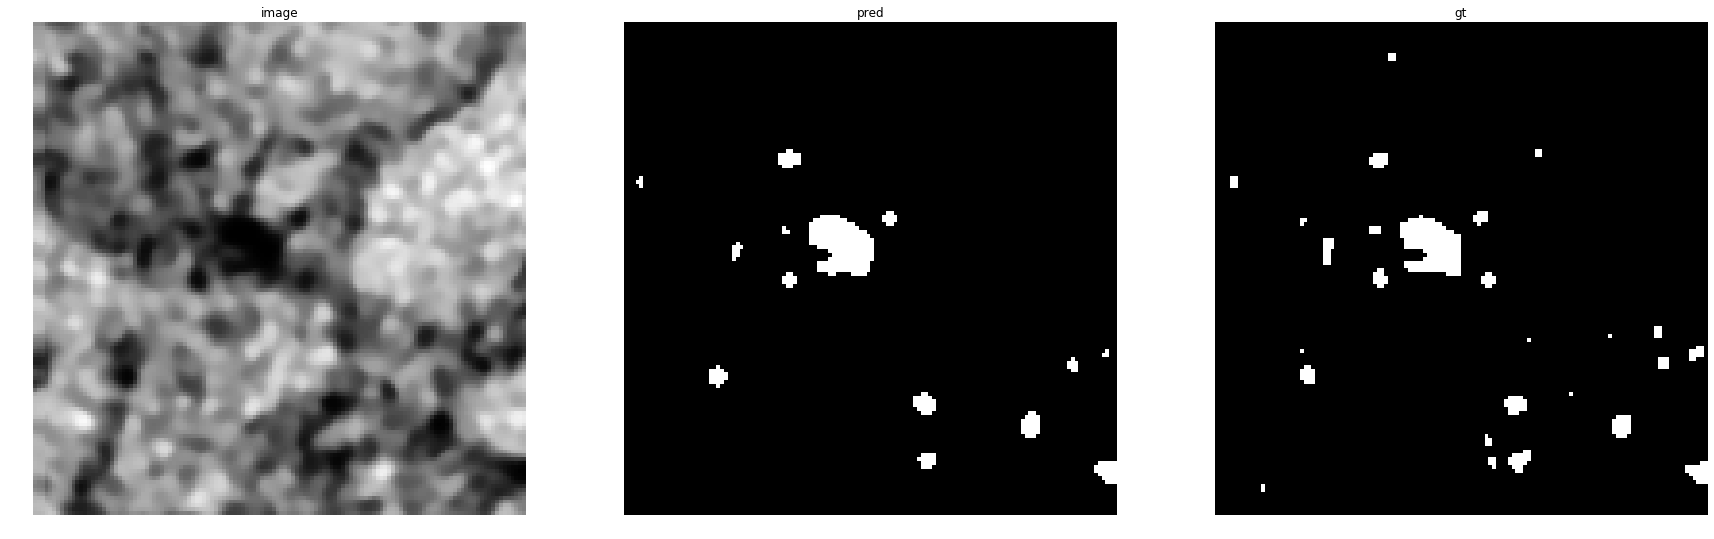

accuracy    : 0.99188232421875
precision   : 0.8844221105527639
recall      : 0.8018223234624146
f1          : 0.841099163679809
pr_auc      : 0.9269269896929274
iou         : 0.7257731958762886


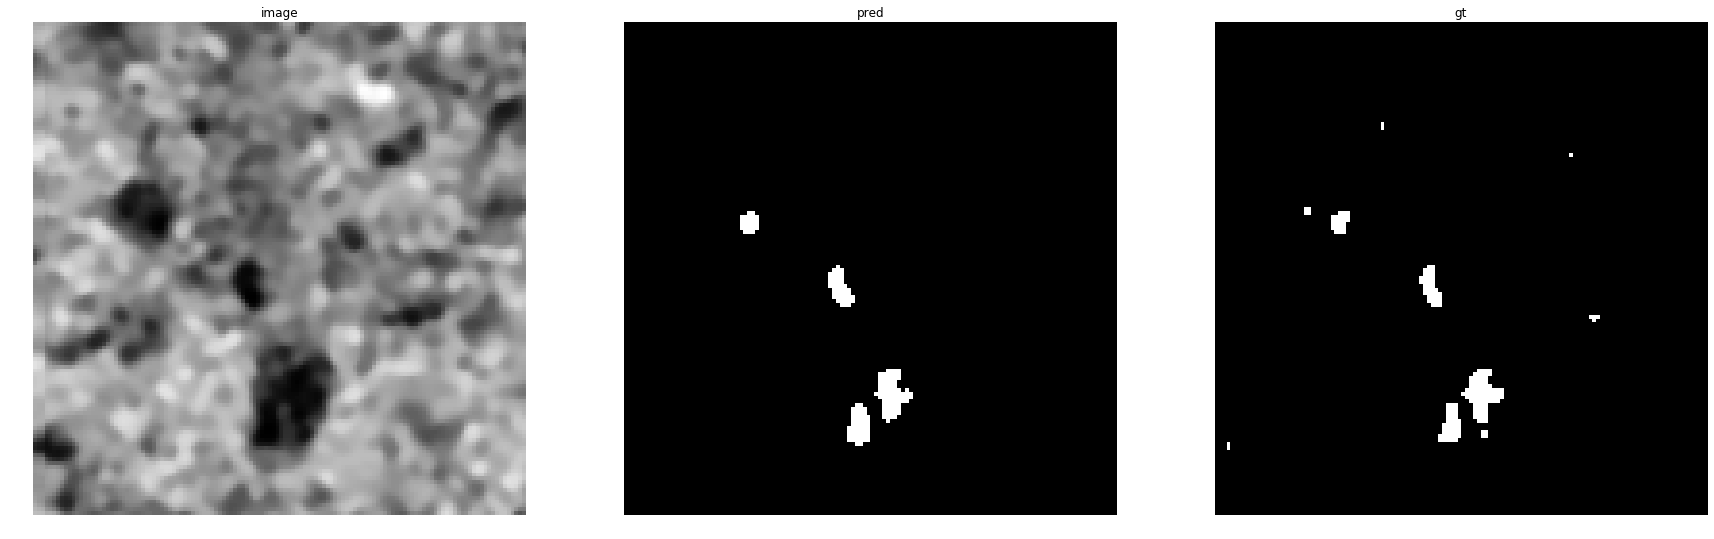

accuracy    : 0.99676513671875
precision   : 0.88
recall      : 0.8585365853658536
f1          : 0.8691358024691358
pr_auc      : 0.9427229446960681
iou         : 0.7685589519650655
SoilB-2


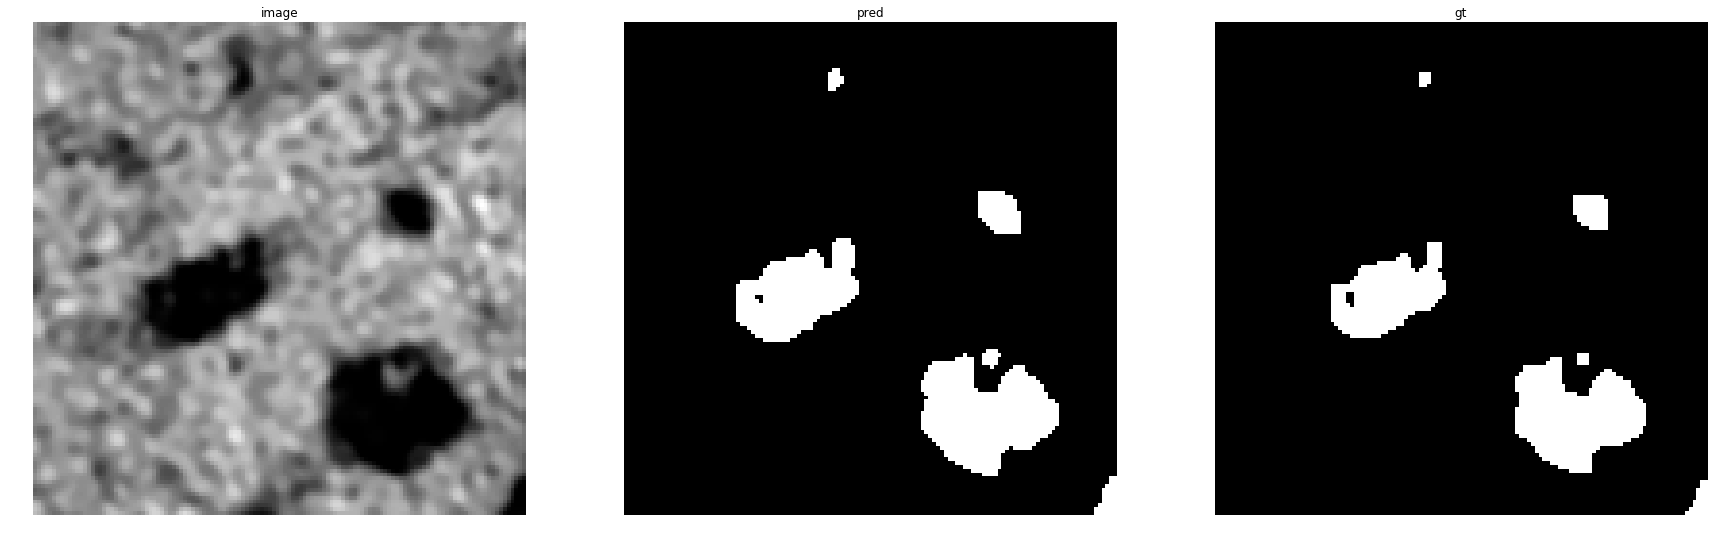

accuracy    : 0.98724365234375
precision   : 0.8560553633217993
recall      : 0.9991922455573505
f1          : 0.9221021244875139
pr_auc      : 0.9985131934764766
iou         : 0.8554633471645919


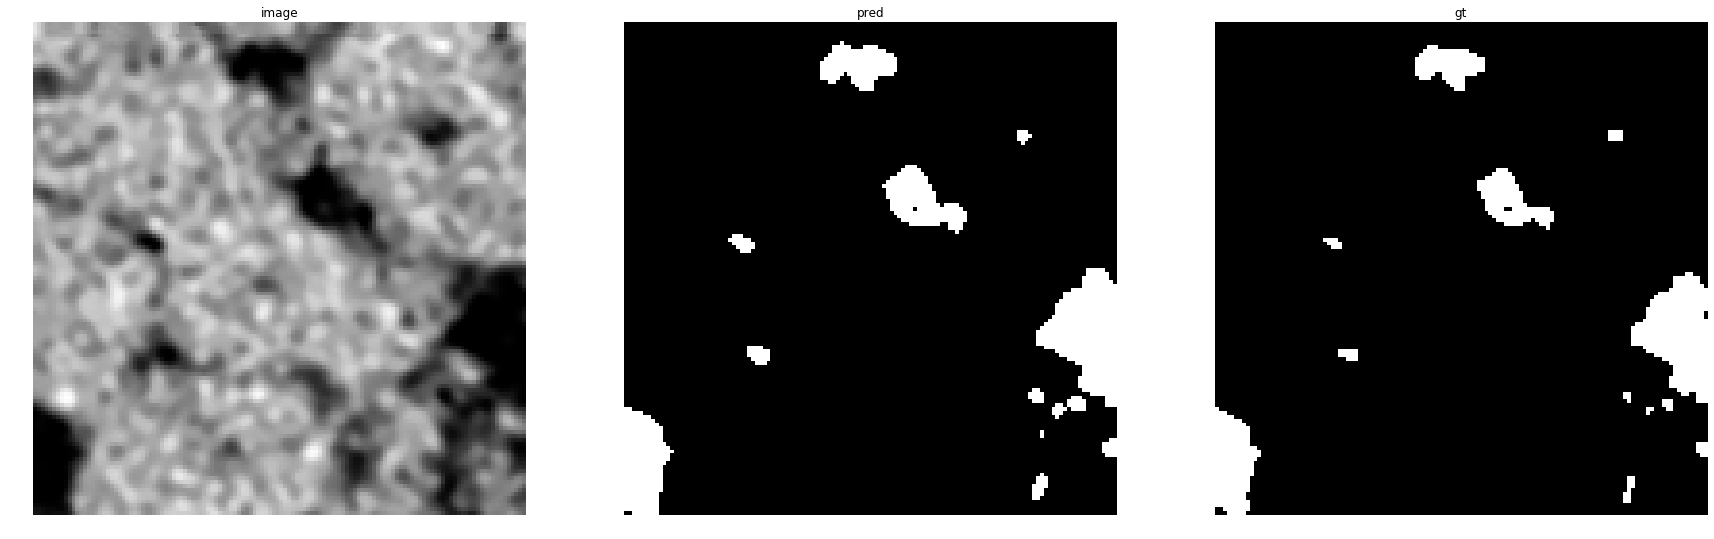

accuracy    : 0.9876708984375
precision   : 0.8382352941176471
recall      : 0.996116504854369
f1          : 0.9103815439219166
pr_auc      : 0.9953885929060338
iou         : 0.8355048859934854


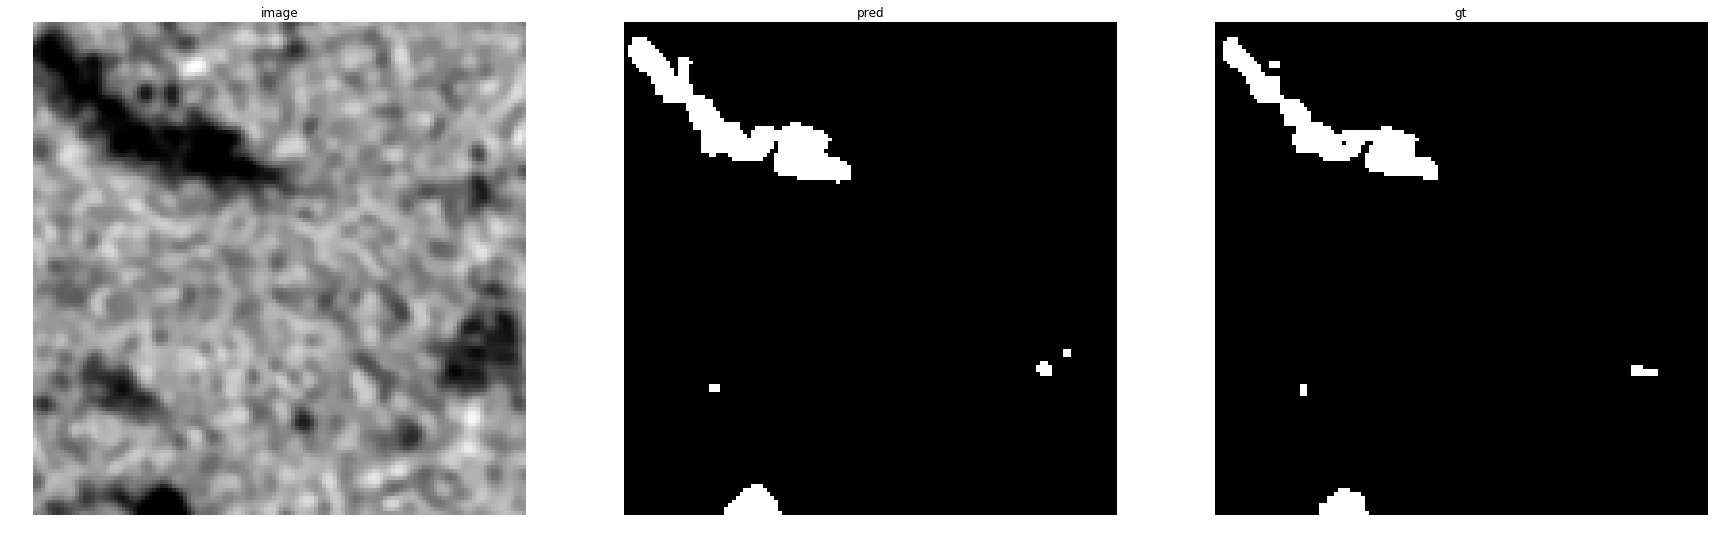

accuracy    : 0.9918212890625
precision   : 0.8204379562043795
recall      : 0.9808027923211169
f1          : 0.8934817170111287
pr_auc      : 0.9878609508072603
iou         : 0.8074712643678161


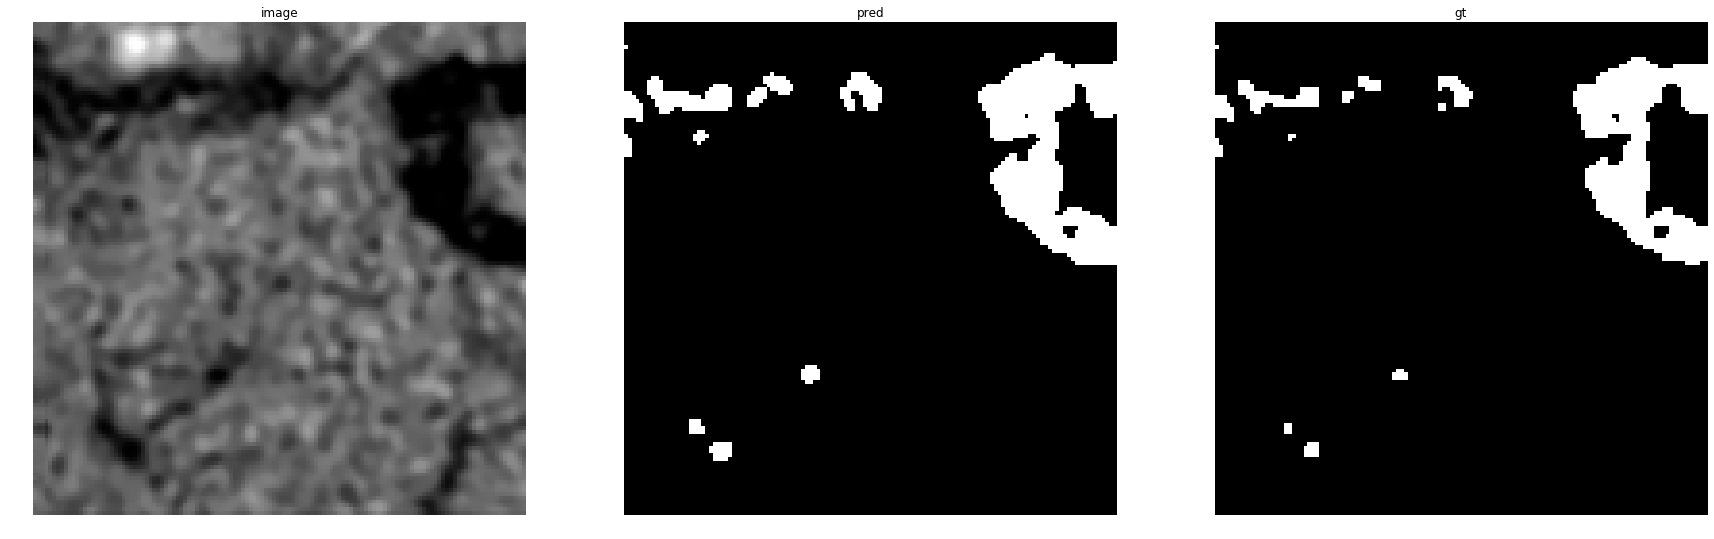

accuracy    : 0.98529052734375
precision   : 0.8274622573687994
recall      : 0.9991319444444444
f1          : 0.9052300432559969
pr_auc      : 0.9956308116230126
iou         : 0.826867816091954


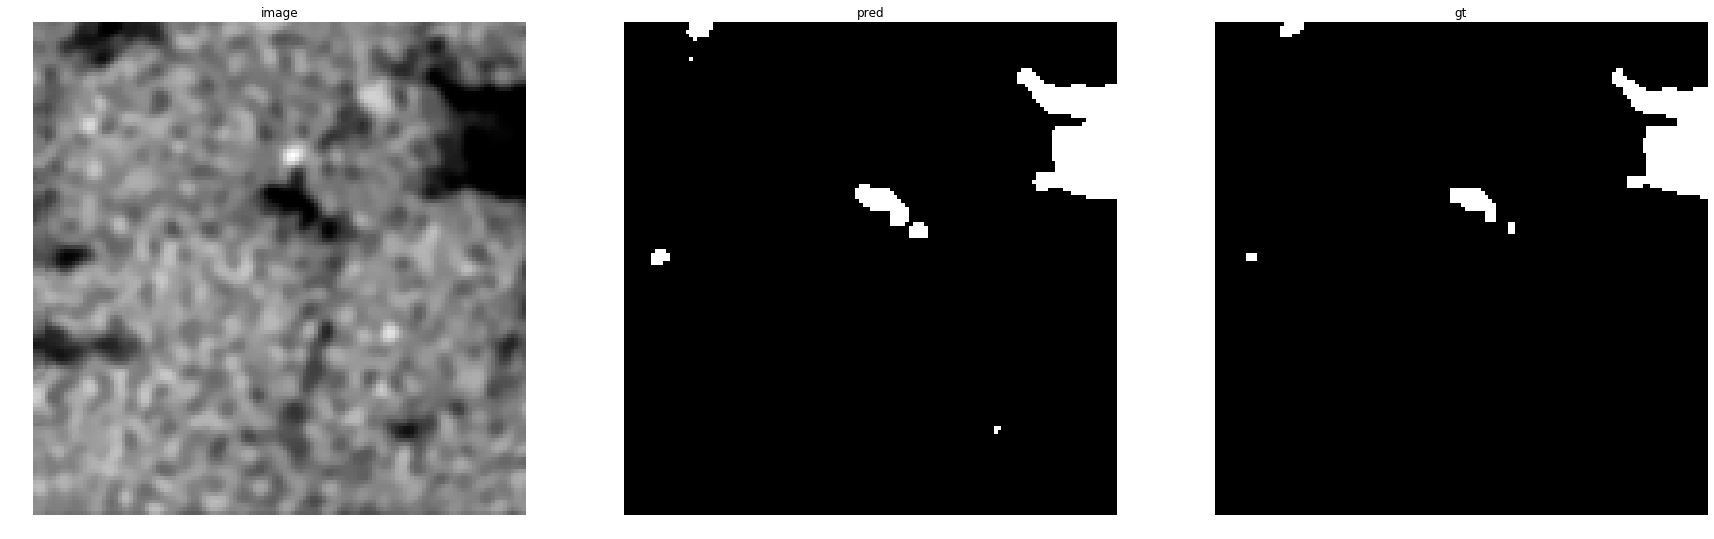

accuracy    : 0.99346923828125
precision   : 0.8421828908554573
recall      : 1.0
f1          : 0.9143314651721378
pr_auc      : 0.9965609802772488
iou         : 0.8421828908554573


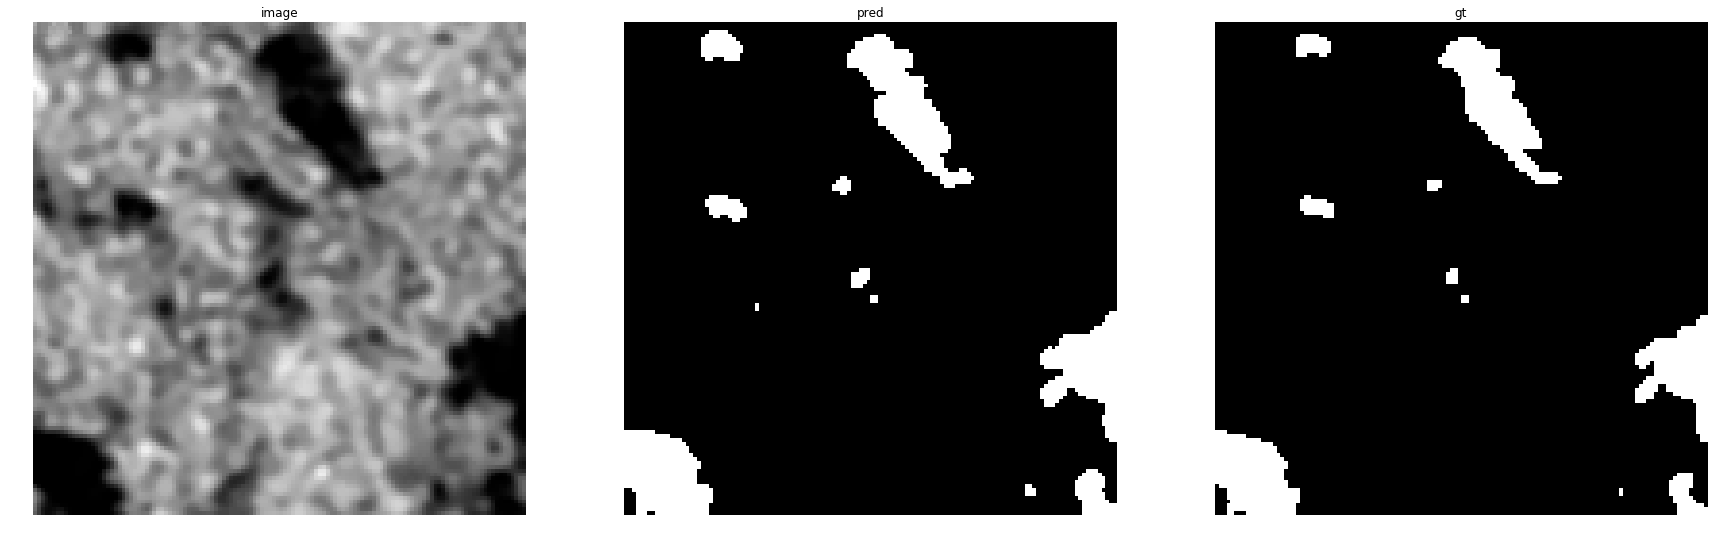

accuracy    : 0.98651123046875
precision   : 0.8575233022636485
recall      : 0.9945945945945946
f1          : 0.9209867715409368
pr_auc      : 0.9960930285965974
iou         : 0.8535453943008615


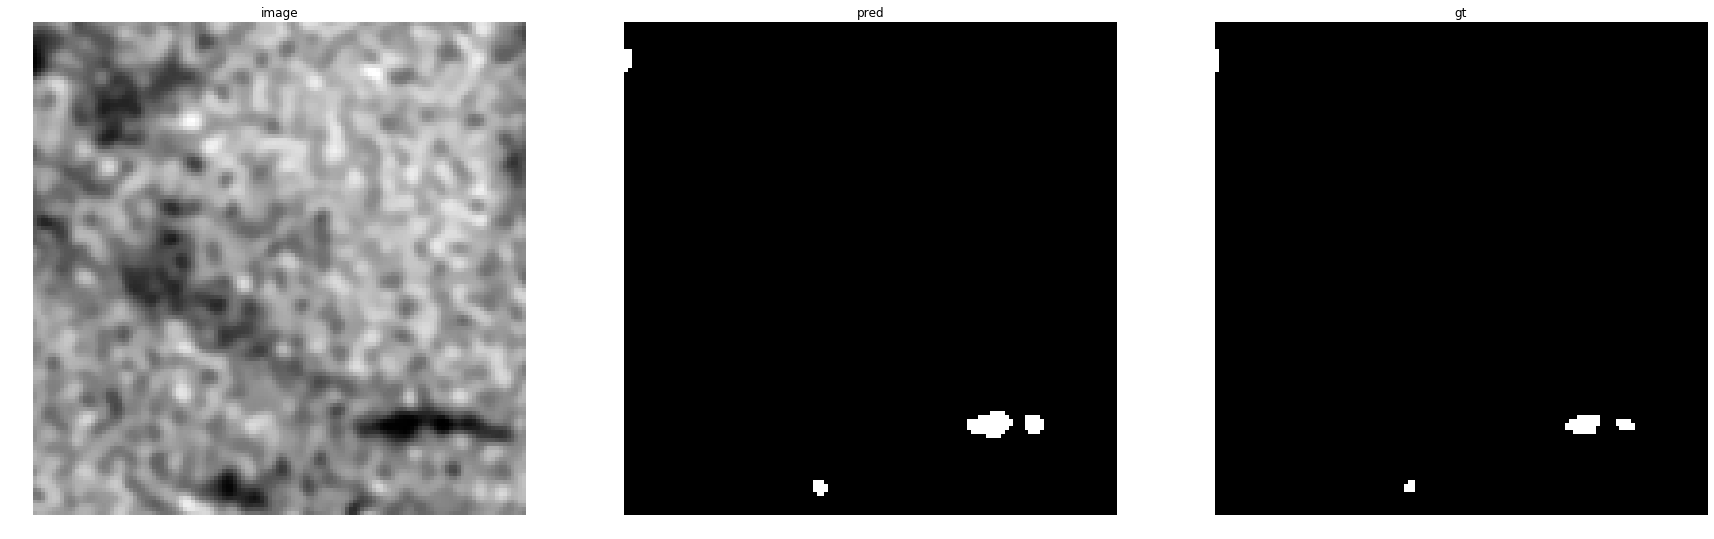

accuracy    : 0.9974365234375
precision   : 0.6037735849056604
recall      : 1.0
f1          : 0.7529411764705882
pr_auc      : 0.9786081585162576
iou         : 0.6037735849056604


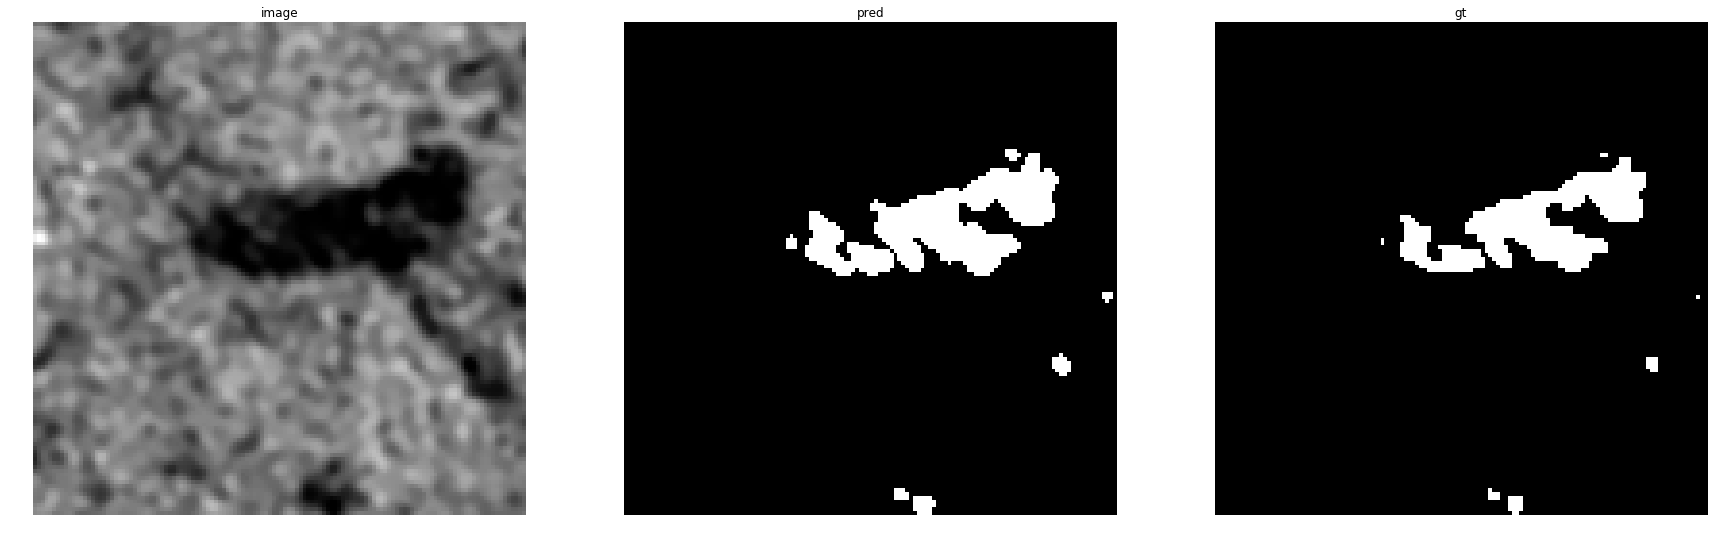

accuracy    : 0.98779296875
precision   : 0.808837656099904
recall      : 0.9988137603795967
f1          : 0.8938428874734609
pr_auc      : 0.9950680521624208
iou         : 0.8080614203454894


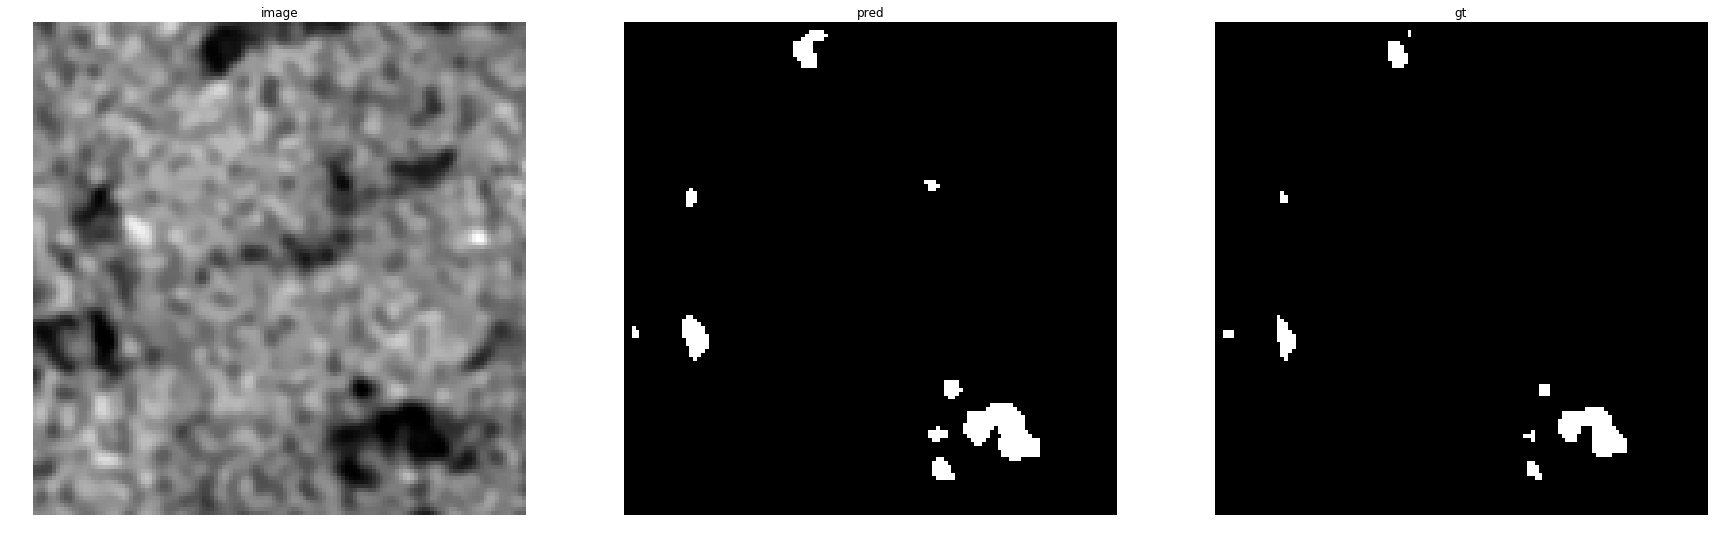

accuracy    : 0.99200439453125
precision   : 0.6531165311653117
recall      : 0.9877049180327869
f1          : 0.7862969004893964
pr_auc      : 0.9672721702934526
iou         : 0.6478494623655914


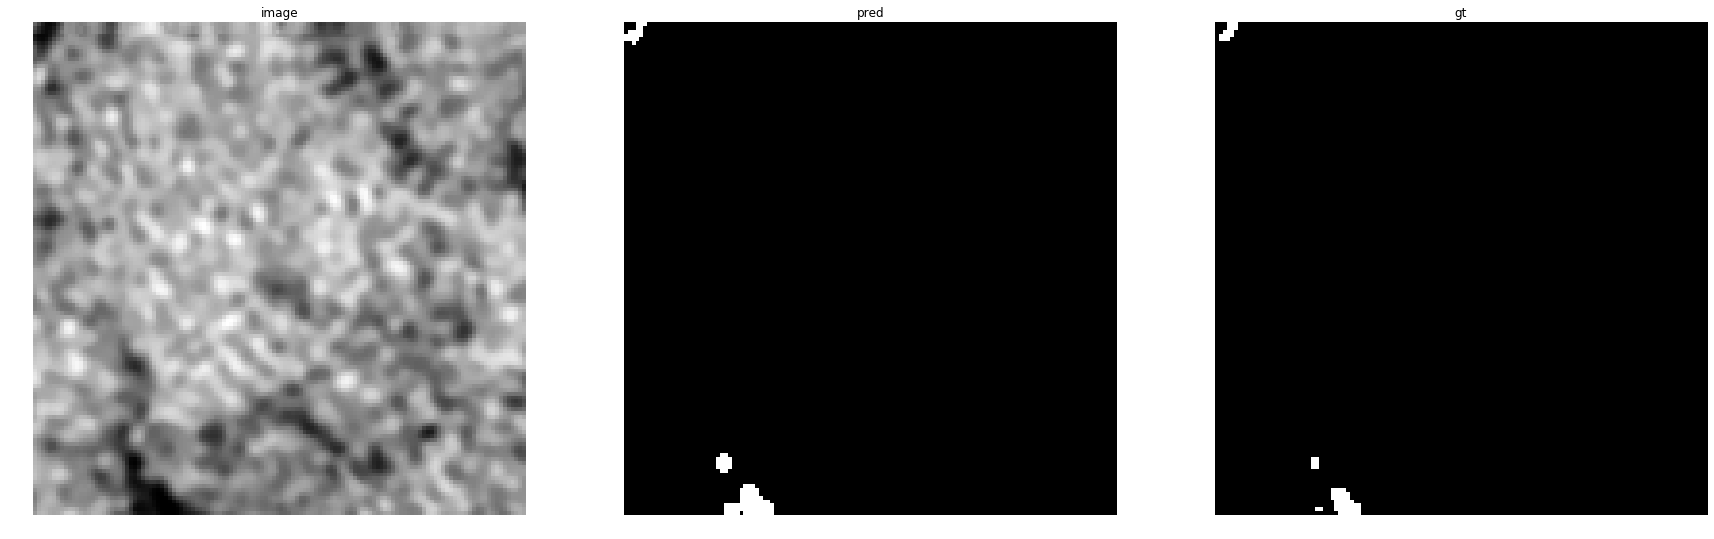

accuracy    : 0.99761962890625
precision   : 0.62
recall      : 0.9841269841269841
f1          : 0.7607361963190183
pr_auc      : 0.9519801164182342
iou         : 0.6138613861386139
TeTree_subset1


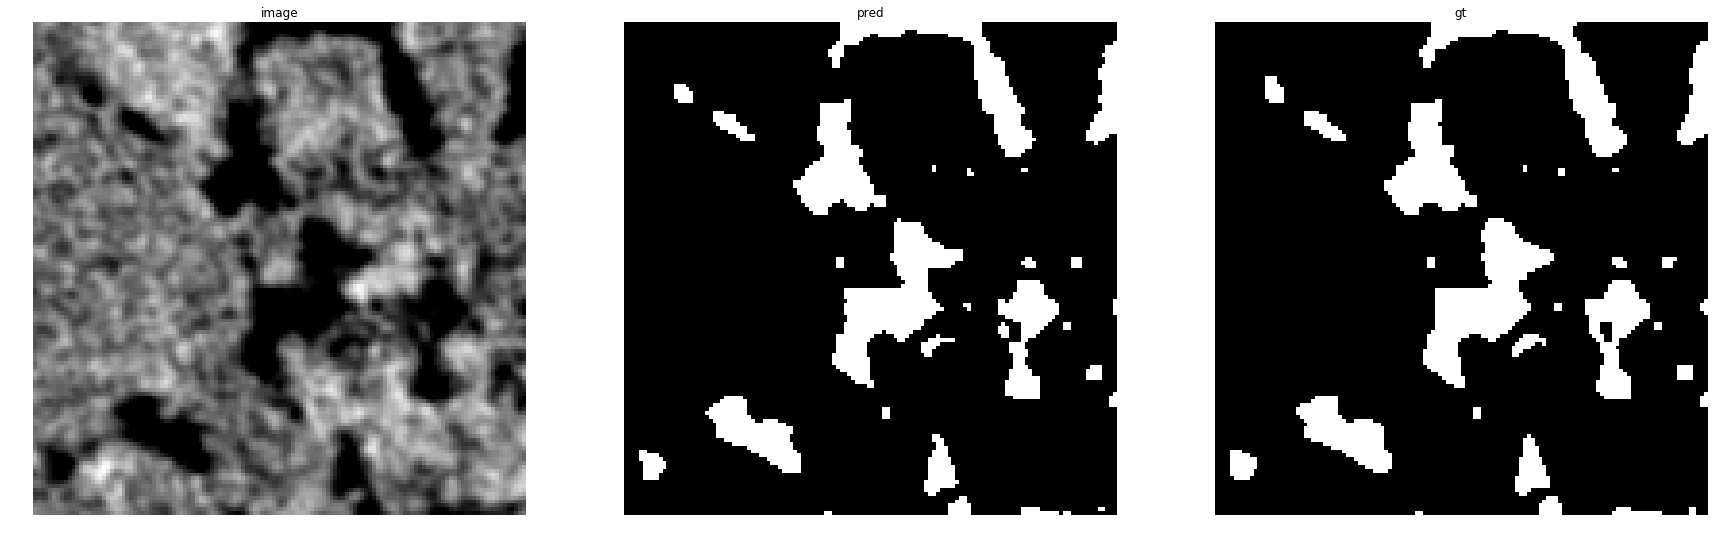

accuracy    : 0.9896240234375
precision   : 0.9960035523978685
recall      : 0.9330282861896838
f1          : 0.963487972508591
pr_auc      : 0.9972691499705028
iou         : 0.9295482801491919


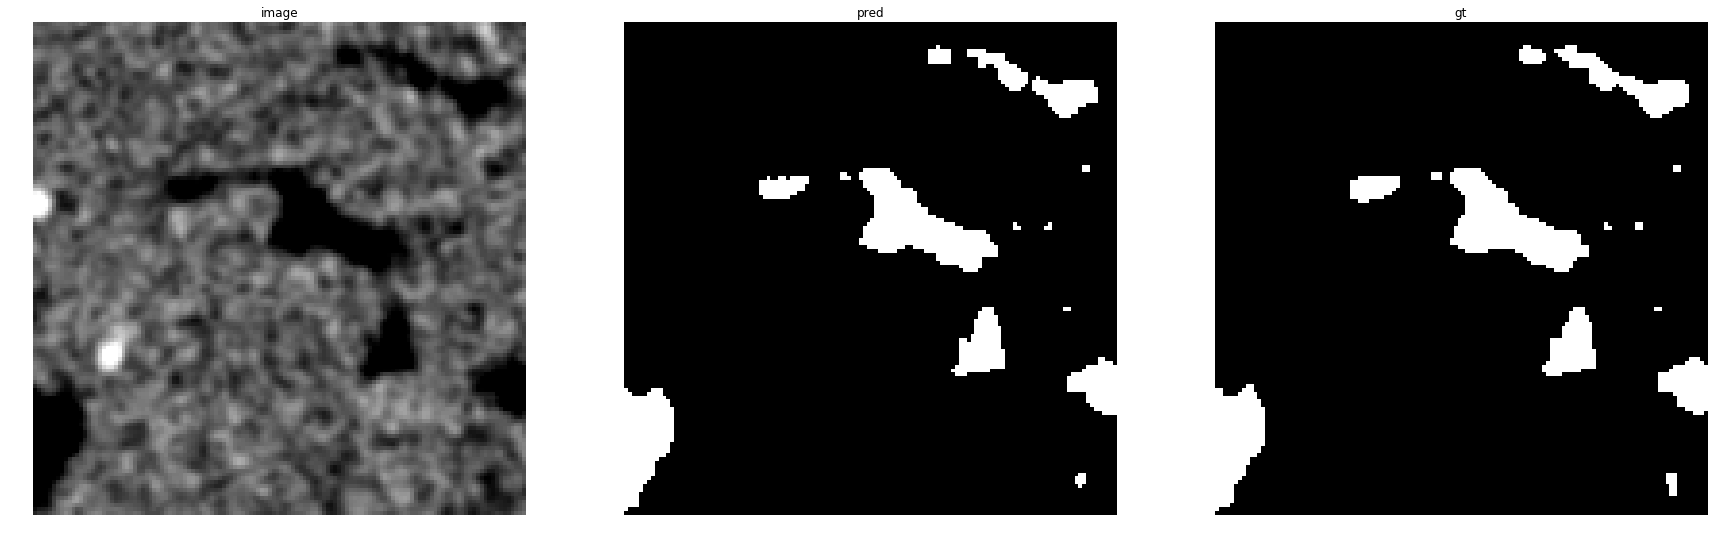

accuracy    : 0.9949951171875
precision   : 0.9962349397590361
recall      : 0.945
f1          : 0.9699413489736071
pr_auc      : 0.9980656092252457
iou         : 0.9416370106761566


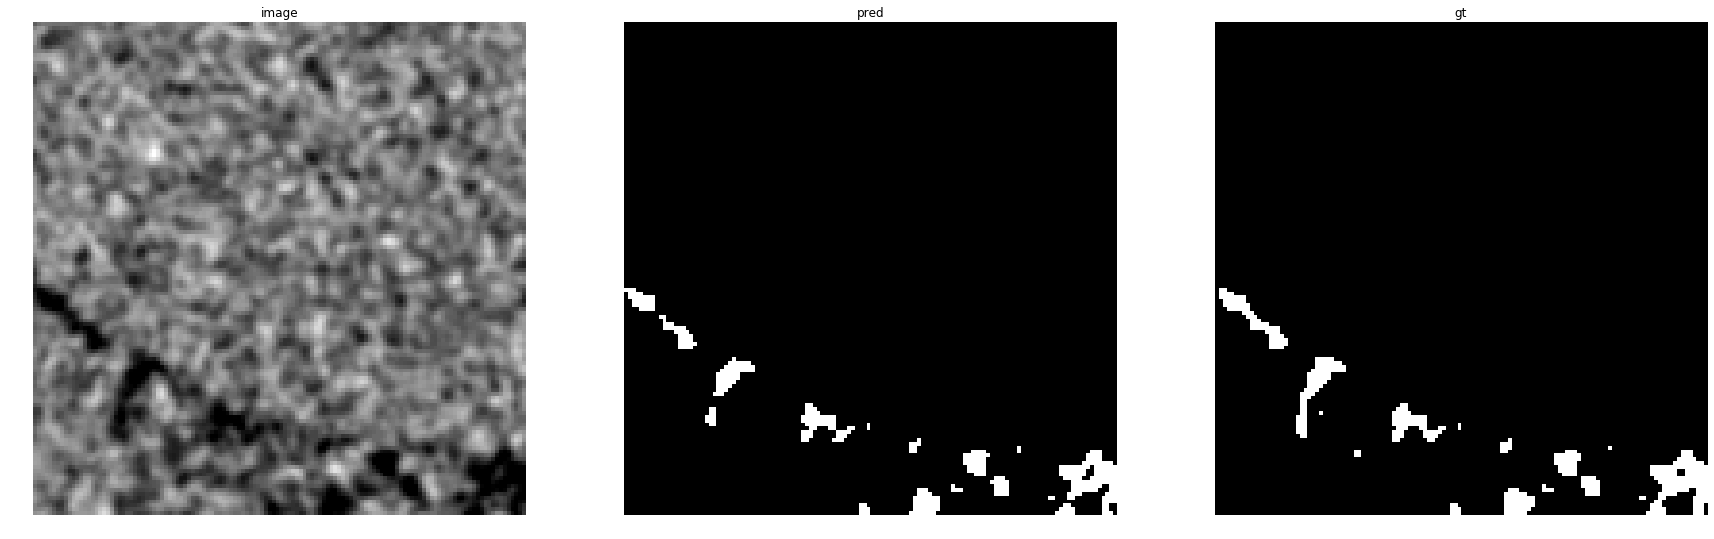

accuracy    : 0.99517822265625
precision   : 0.984304932735426
recall      : 0.8590998043052838
f1          : 0.9174503657262277
pr_auc      : 0.9828068087644823
iou         : 0.8474903474903475


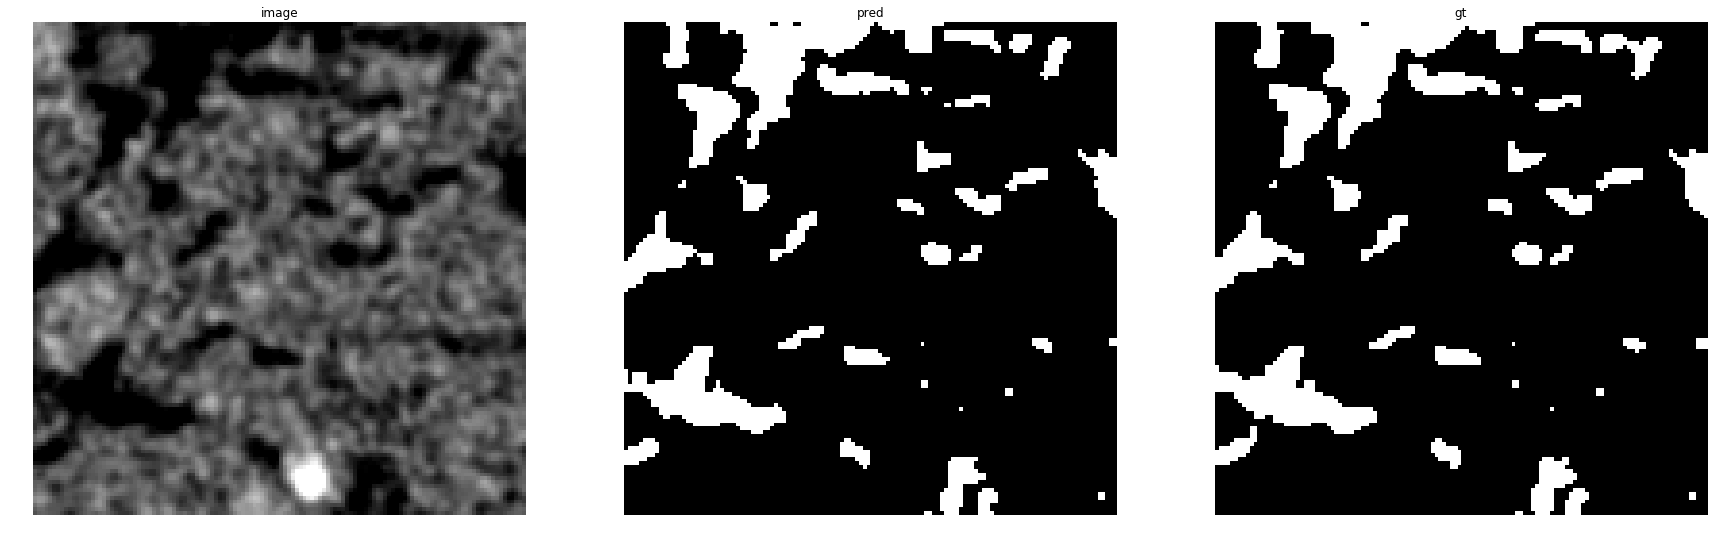

accuracy    : 0.9871826171875
precision   : 0.9906263314870047
recall      : 0.9251890171110226
f1          : 0.95679012345679
pr_auc      : 0.9952727651030762
iou         : 0.9171597633136095


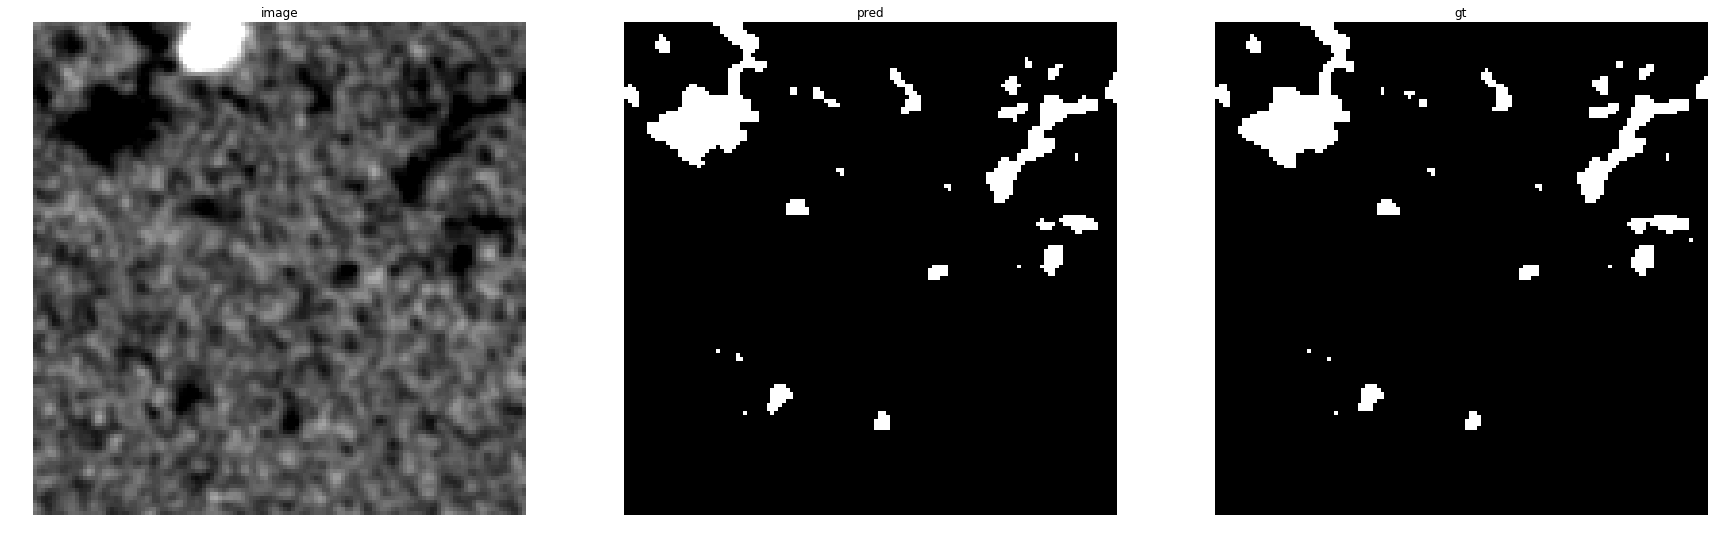

accuracy    : 0.9949951171875
precision   : 0.9640287769784173
recall      : 0.9522842639593908
f1          : 0.9581205311542391
pr_auc      : 0.9931874210014305
iou         : 0.9196078431372549


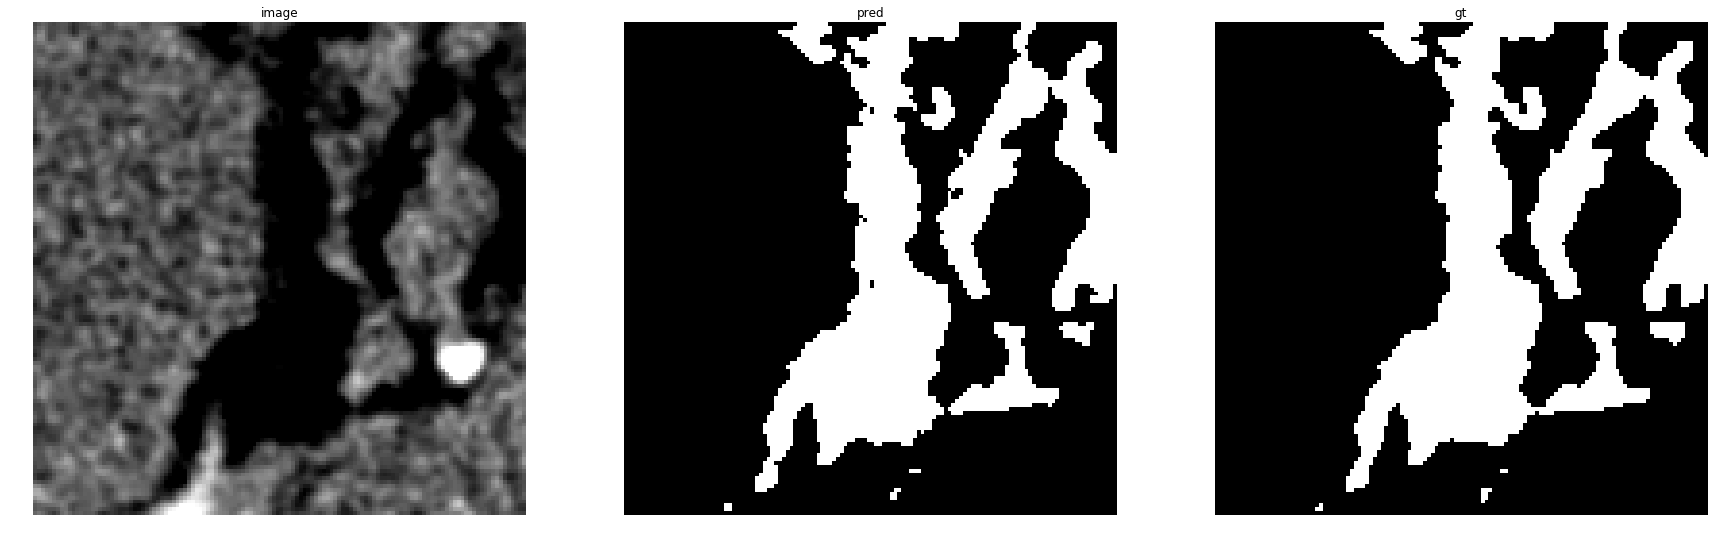

accuracy    : 0.98834228515625
precision   : 0.9935110081112398
recall      : 0.9633707865168539
f1          : 0.9782087849401027
pr_auc      : 0.9988902133167034
iou         : 0.9573470299240733


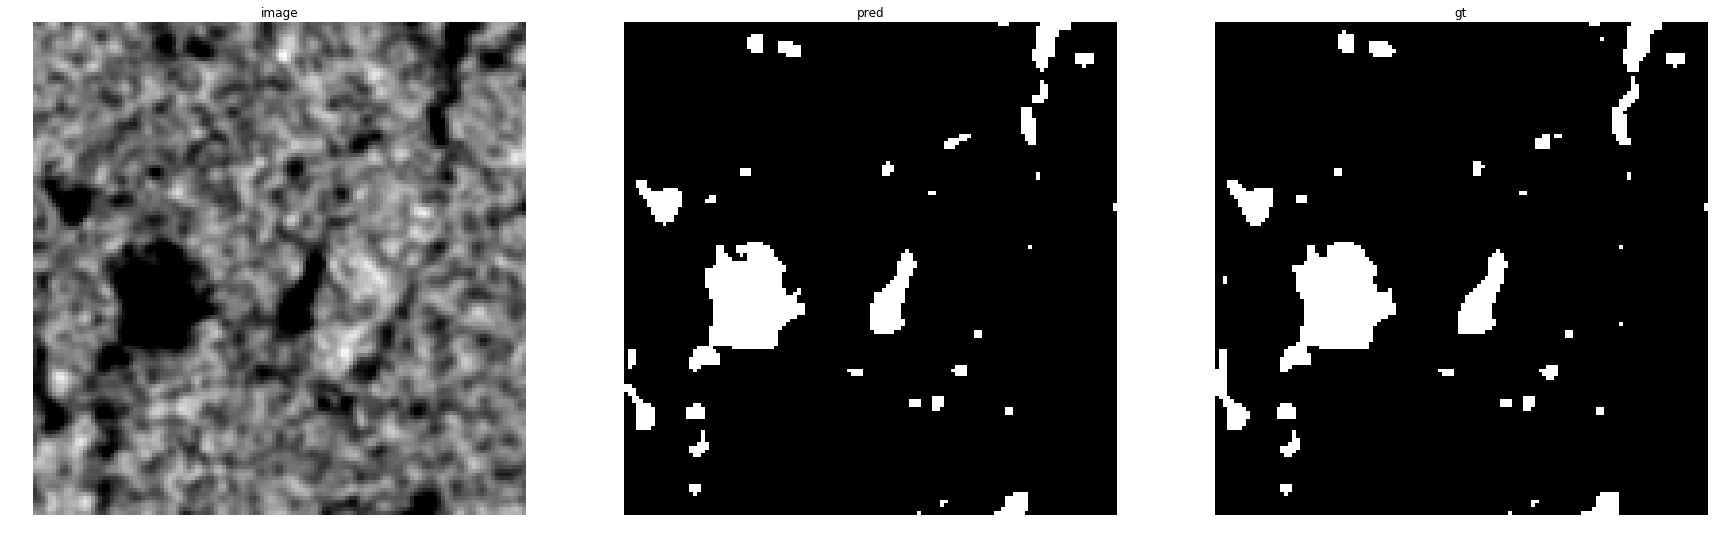

accuracy    : 0.99310302734375
precision   : 0.9939024390243902
recall      : 0.9149959903769046
f1          : 0.9528183716075157
pr_auc      : 0.995557040403613
iou         : 0.9098883572567783


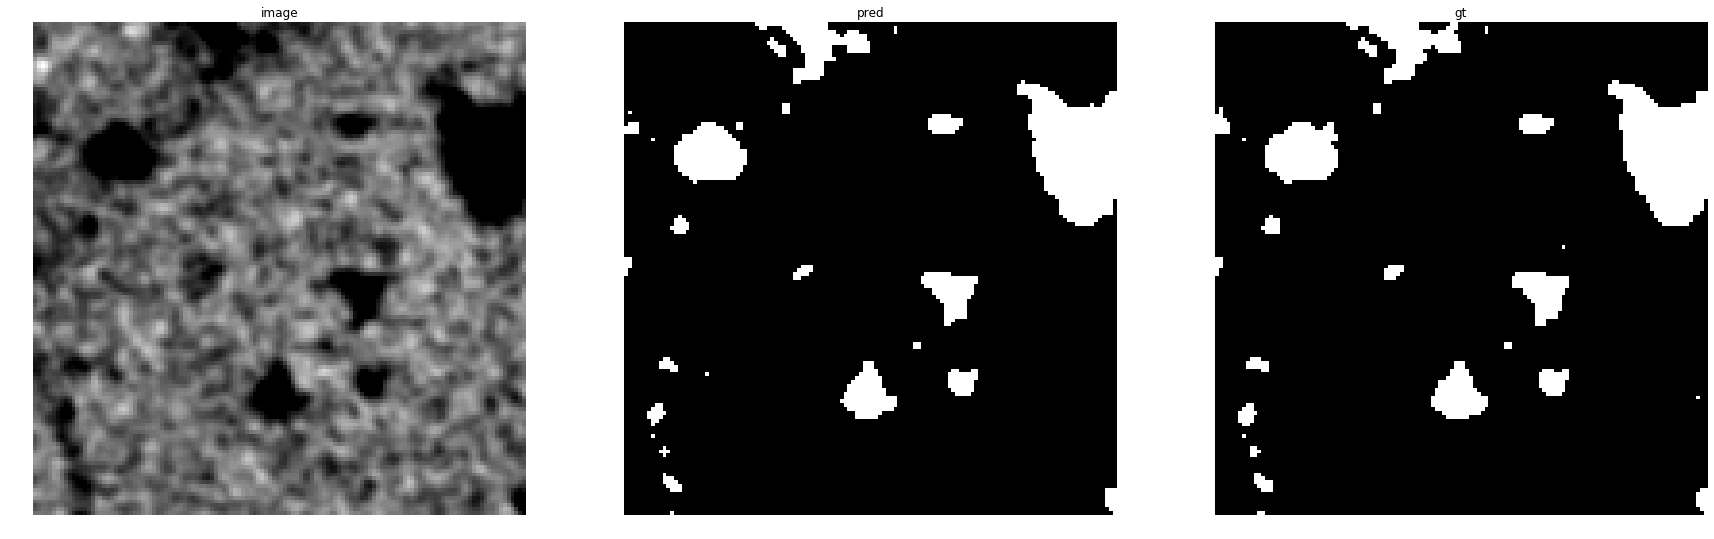

accuracy    : 0.99371337890625
precision   : 0.9960604070912672
recall      : 0.9399008674101611
f1          : 0.9671660822441824
pr_auc      : 0.996803855683947
iou         : 0.9364197530864198


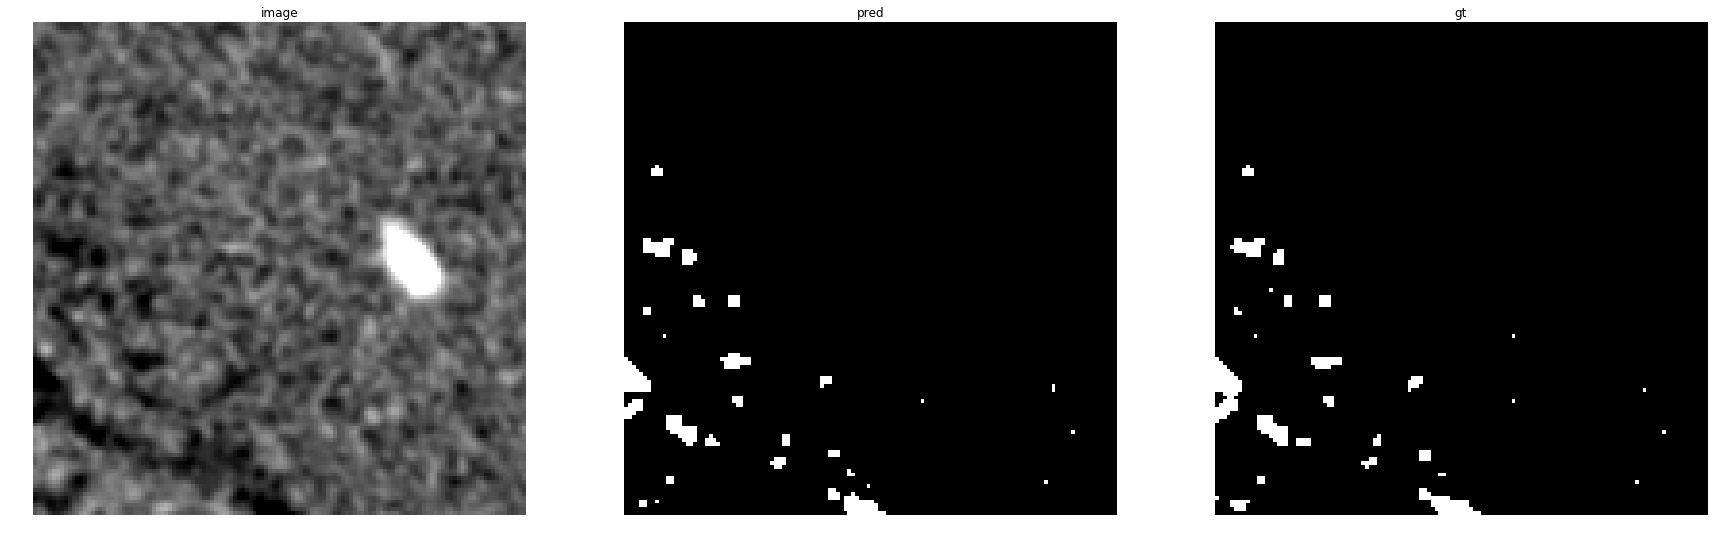

accuracy    : 0.99652099609375
precision   : 0.944078947368421
recall      : 0.8776758409785933
f1          : 0.9096671949286848
pr_auc      : 0.9653722474859784
iou         : 0.8343023255813954


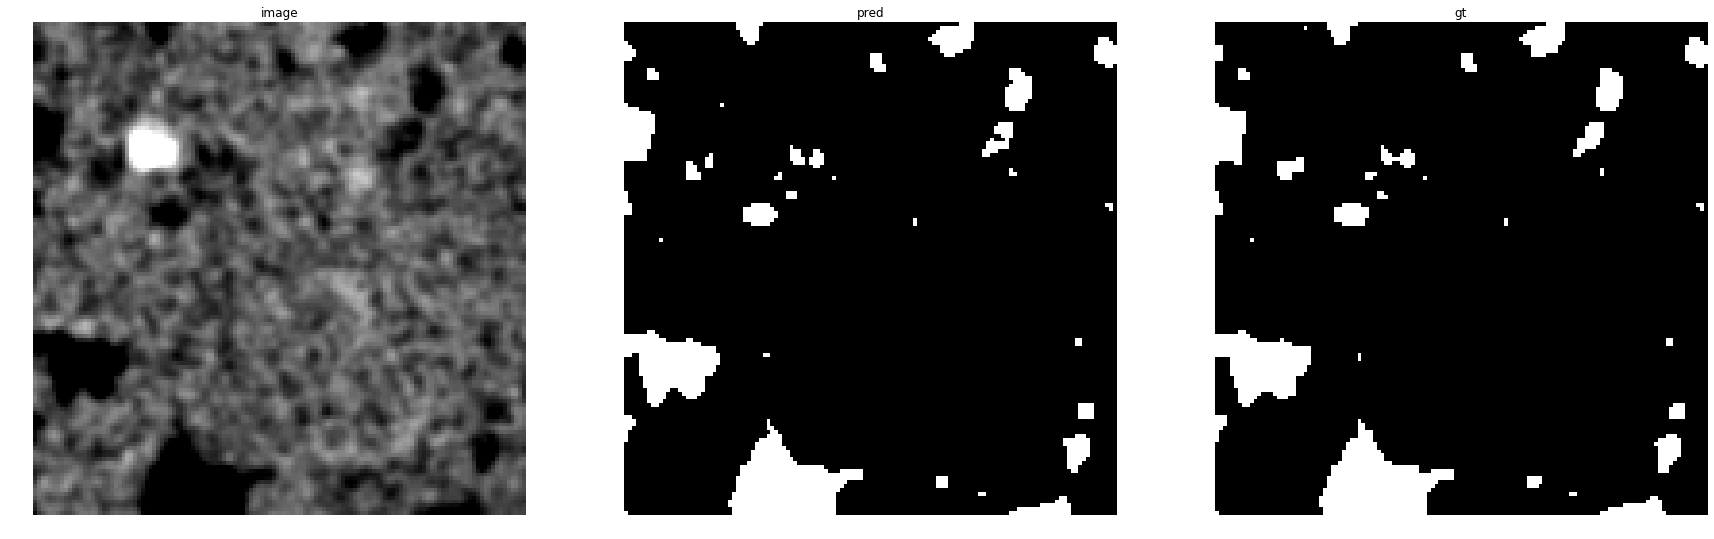

accuracy    : 0.99505615234375
precision   : 0.9868995633187773
recall      : 0.9556025369978859
f1          : 0.970998925886144
pr_auc      : 0.9965670372870098
iou         : 0.9436325678496869
TiTree_subset2


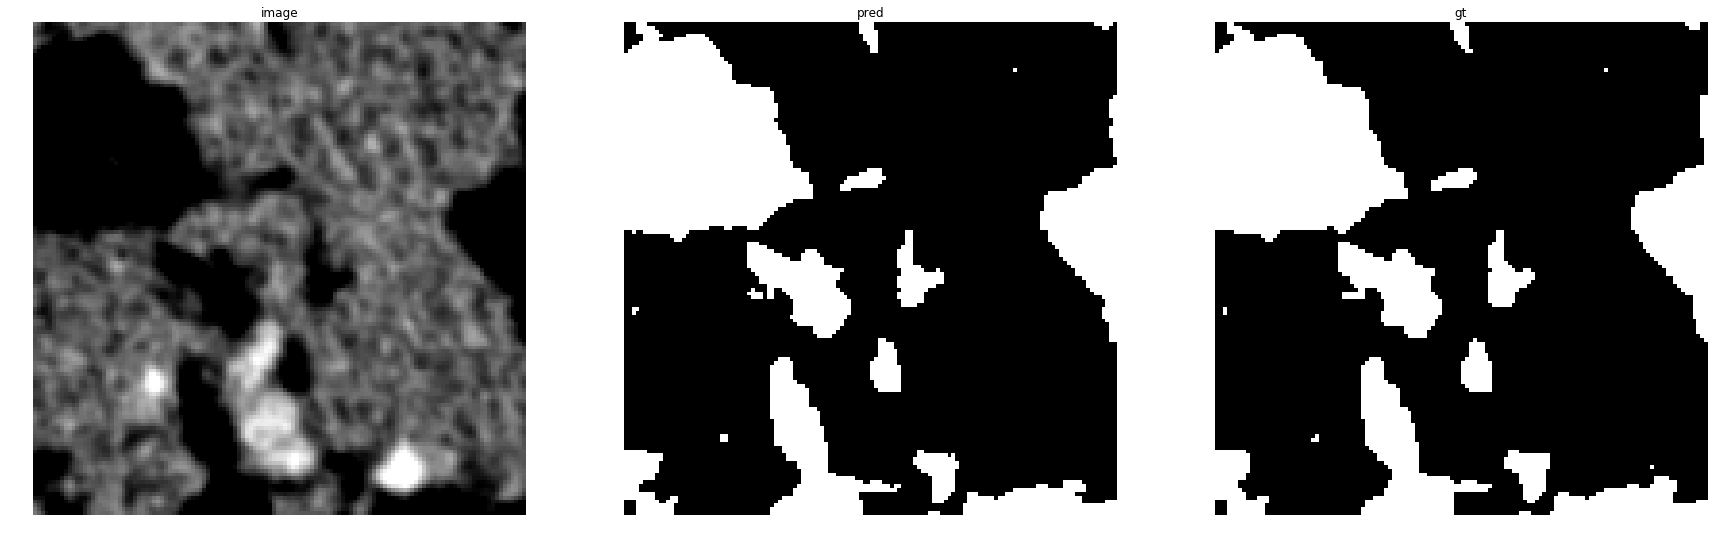

accuracy    : 0.99176025390625
precision   : 0.9953669836625213
recall      : 0.9723677941877085
f1          : 0.9837329798770937
pr_auc      : 0.9992891765950976
iou         : 0.9679867204173583


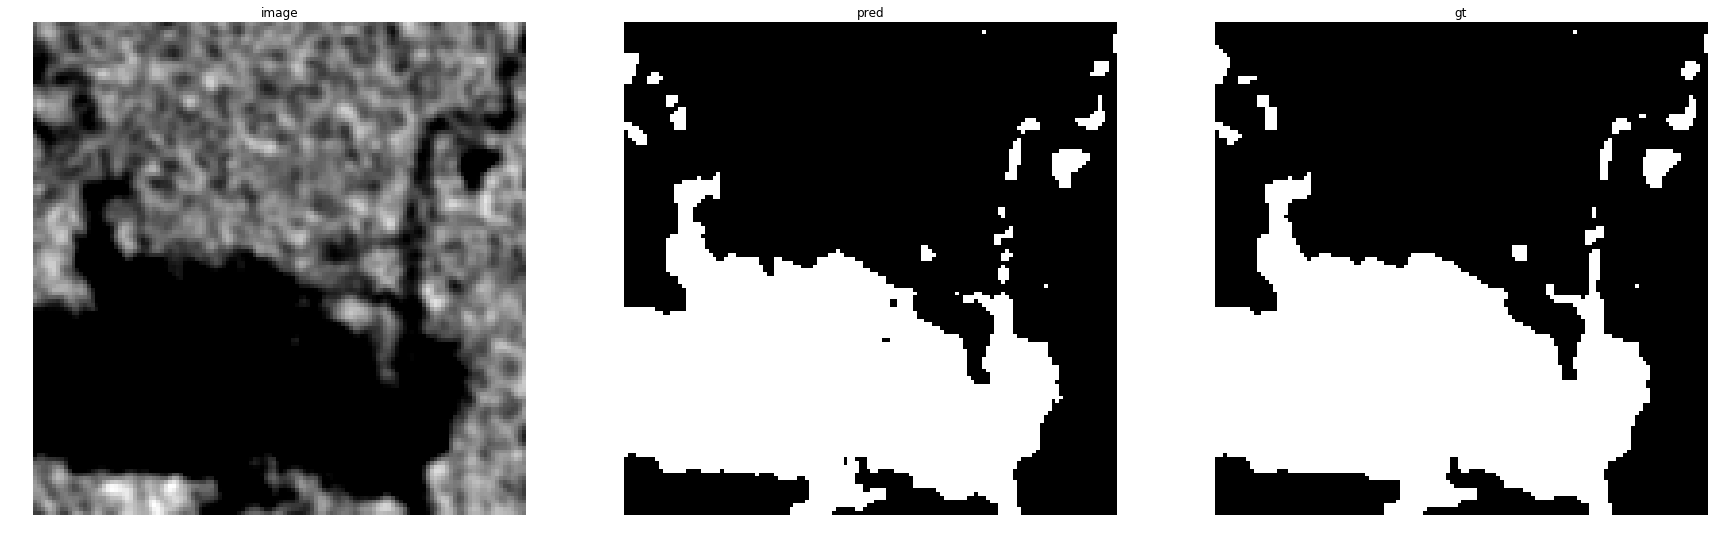

accuracy    : 0.99005126953125
precision   : 0.9942548158161542
recall      : 0.9785464826209879
f1          : 0.9863381108037884
pr_auc      : 0.9994948862380771
iou         : 0.9730444848685299


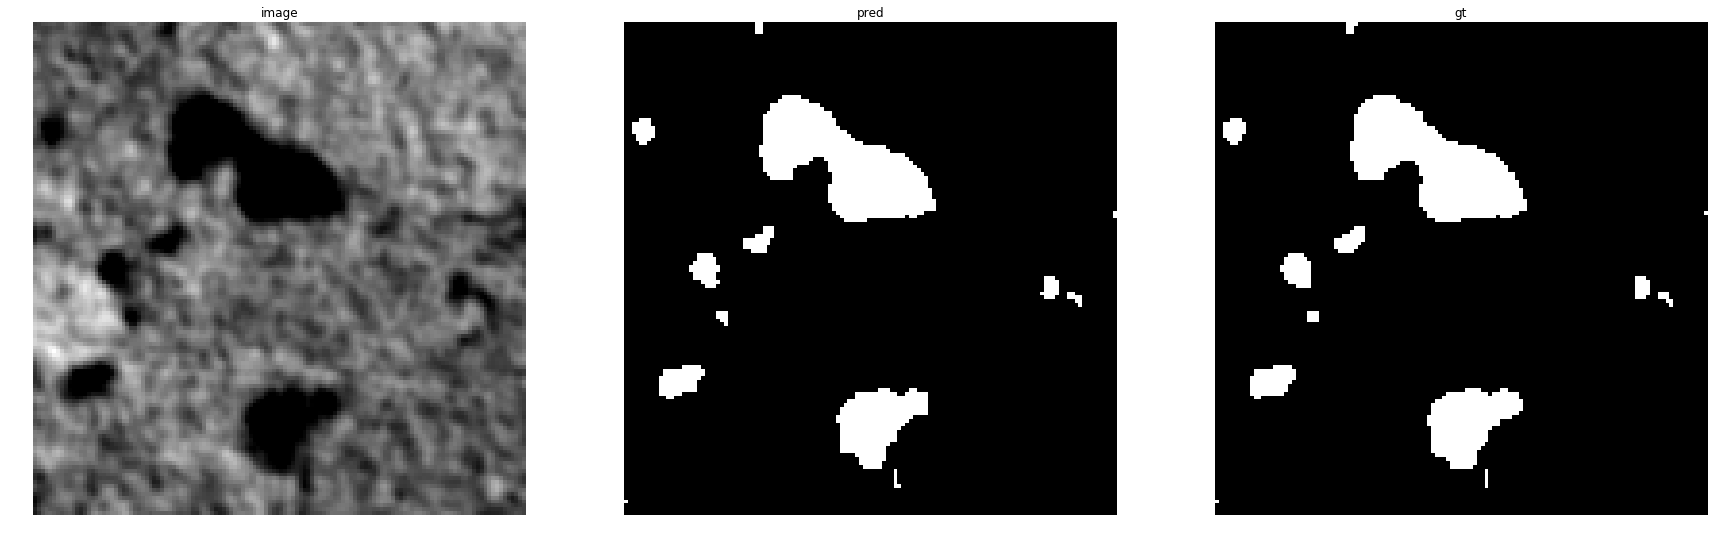

accuracy    : 0.9954833984375
precision   : 0.9918458117123795
recall      : 0.9550321199143469
f1          : 0.9730909090909091
pr_auc      : 0.9981546527912621
iou         : 0.9475920679886686


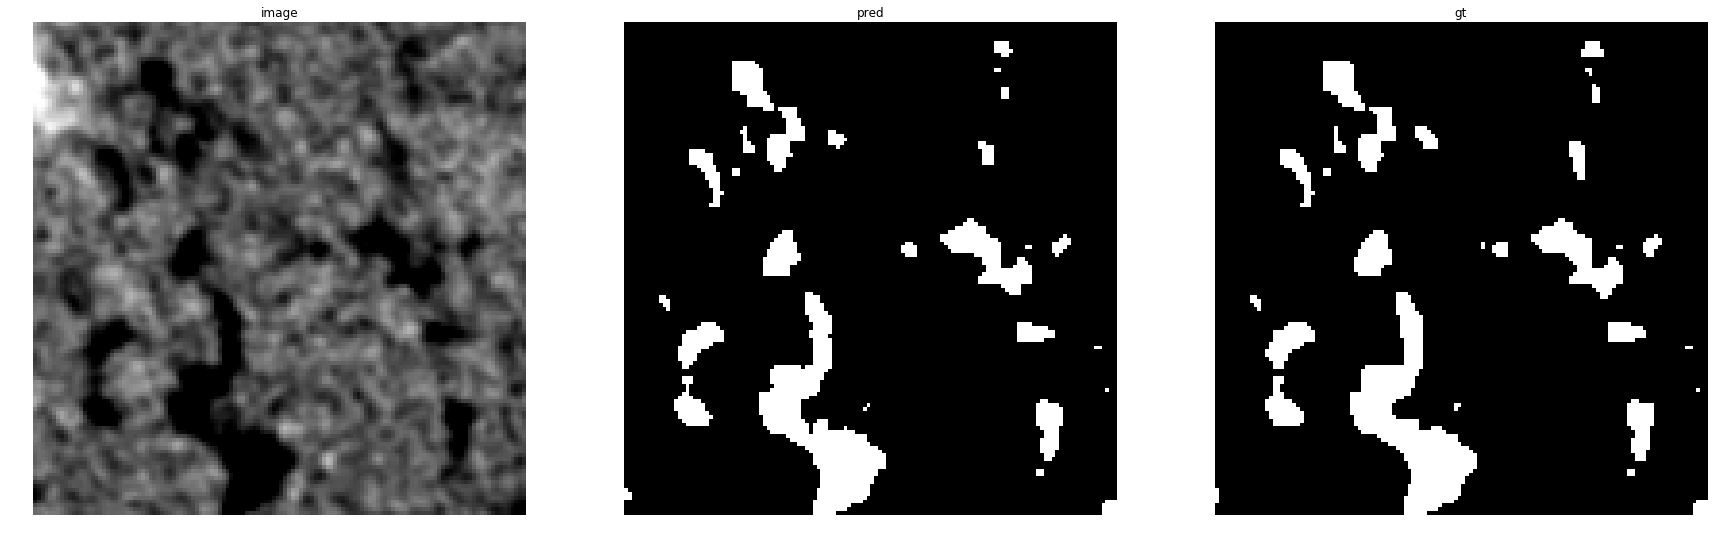

accuracy    : 0.99298095703125
precision   : 0.9930291508238276
recall      : 0.9377618192698982
f1          : 0.9646044936903663
pr_auc      : 0.9963299061506922
iou         : 0.9316290130796671


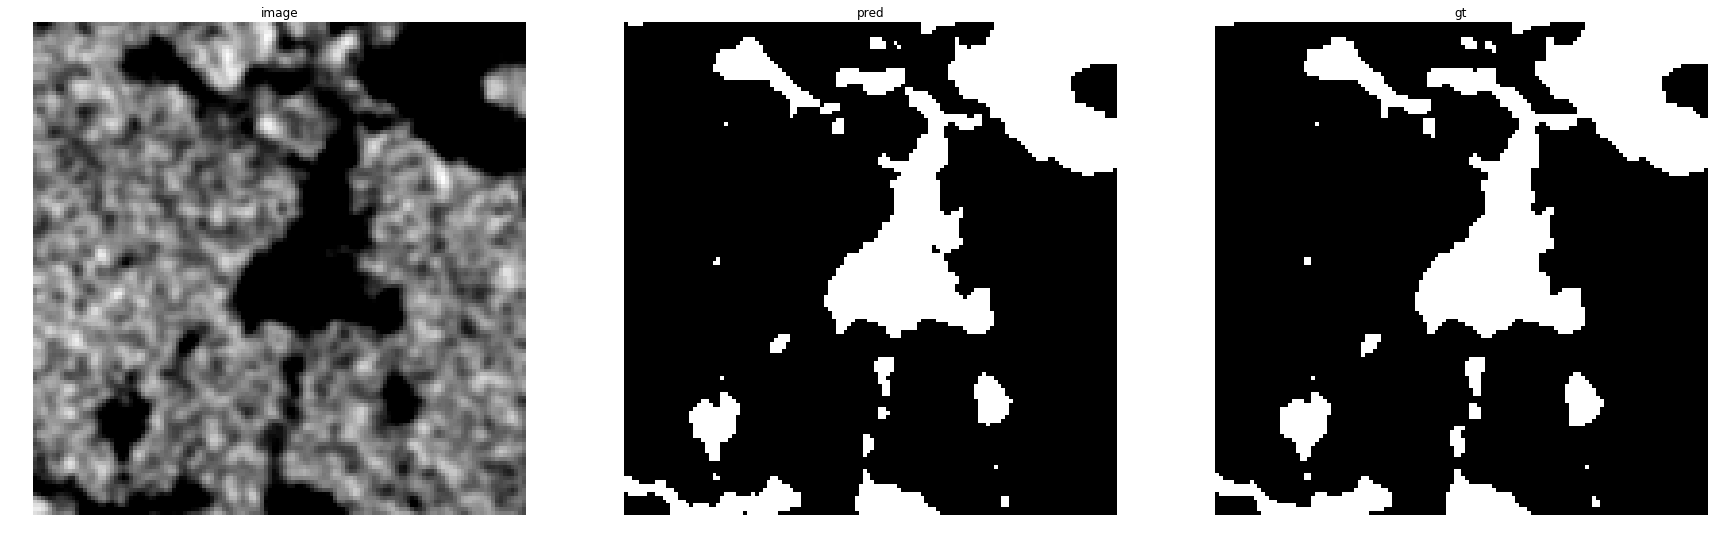

accuracy    : 0.98876953125
precision   : 0.9958932238193019
recall      : 0.9523141654978962
f1          : 0.9736162890737023
pr_auc      : 0.9988815289356409
iou         : 0.9485889913383627


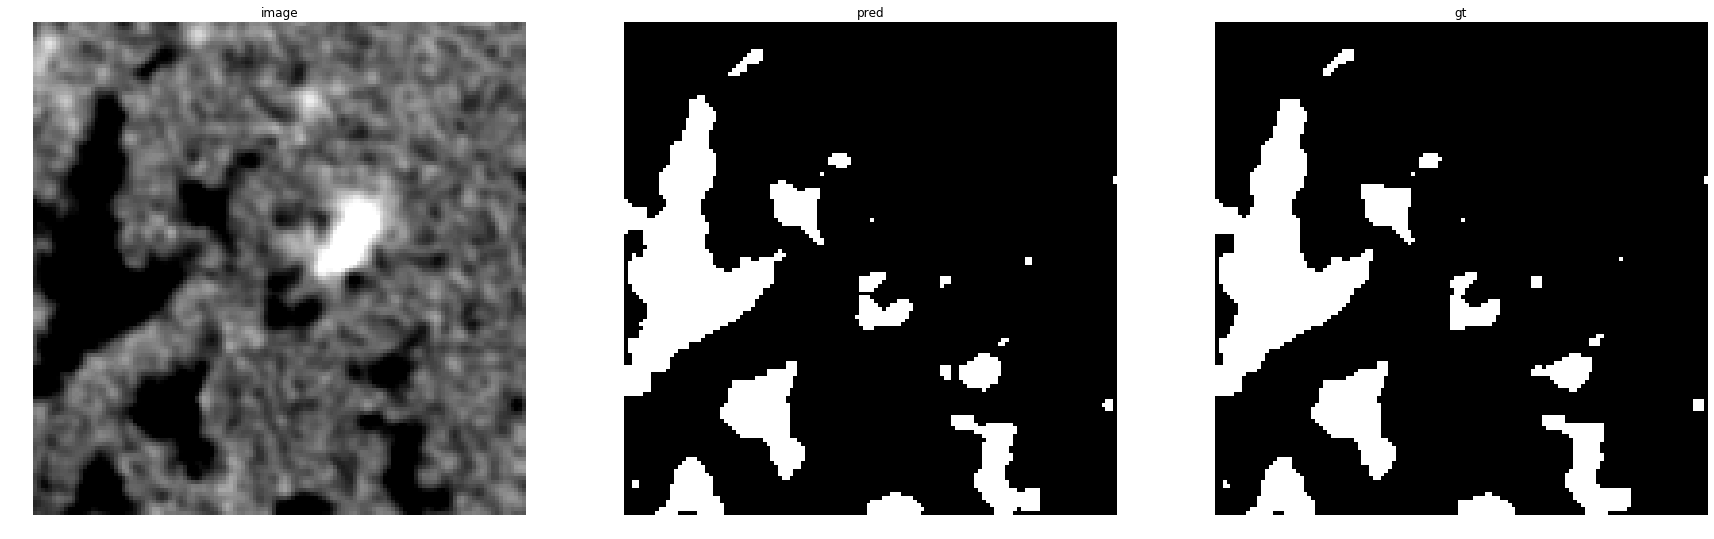

accuracy    : 0.99224853515625
precision   : 0.9861166203887346
recall      : 0.9643134212567882
f1          : 0.9750931555206902
pr_auc      : 0.9981295686975075
iou         : 0.951396861844623


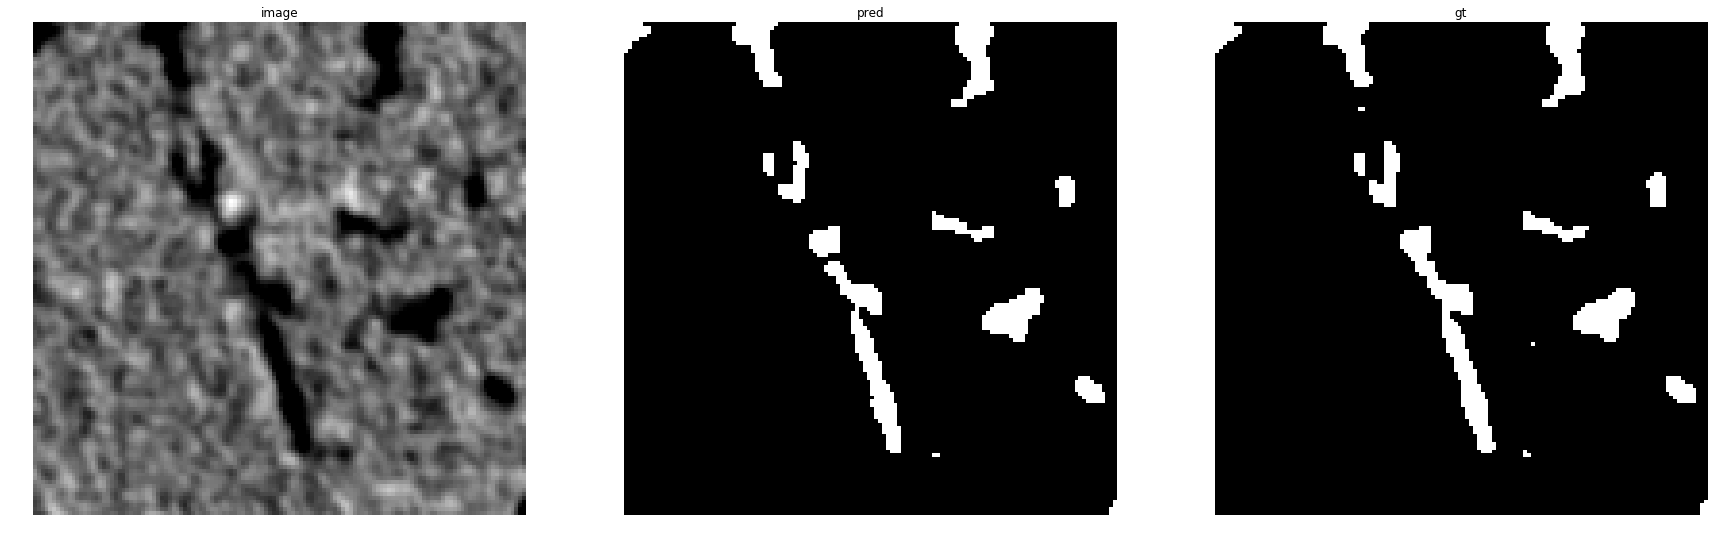

accuracy    : 0.99505615234375
precision   : 0.996832101372756
recall      : 0.923679060665362
f1          : 0.9588623666835957
pr_auc      : 0.9963977118961156
iou         : 0.9209756097560976


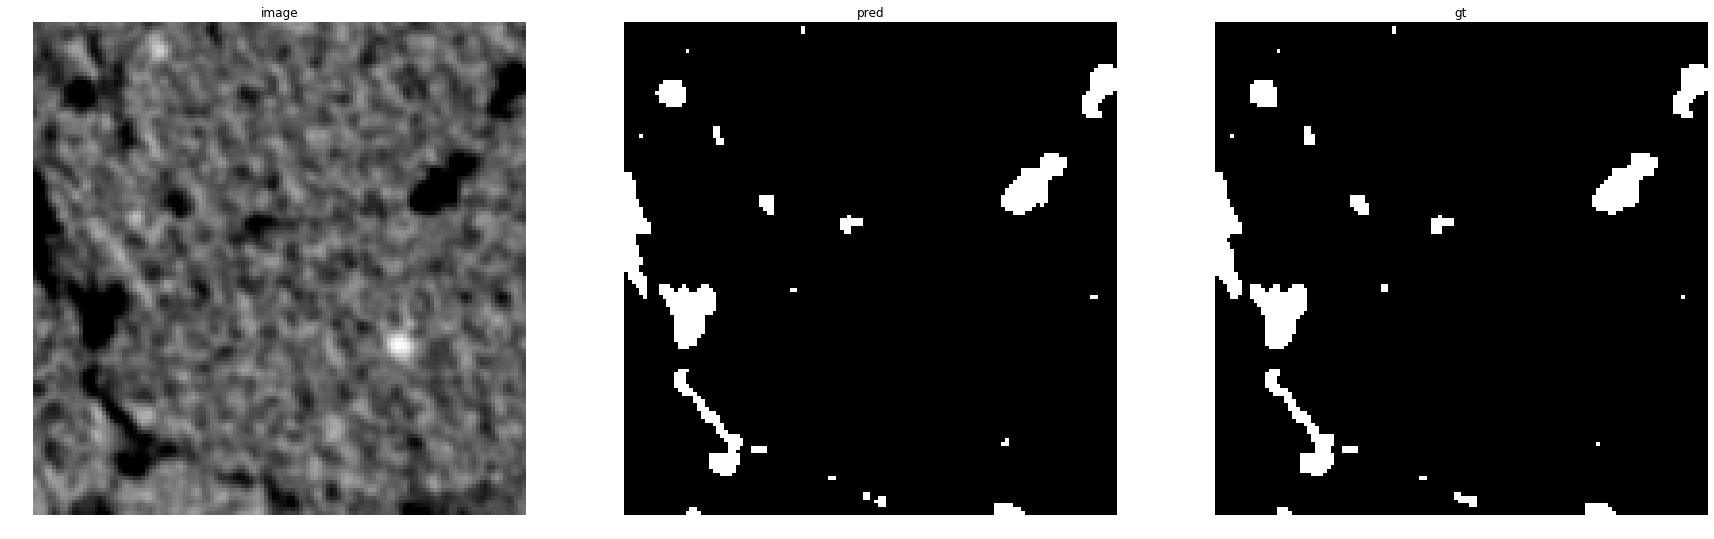

accuracy    : 0.99603271484375
precision   : 0.9921773142112125
recall      : 0.9280487804878049
f1          : 0.959042218021424
pr_auc      : 0.9933510964612313
iou         : 0.9213075060532687


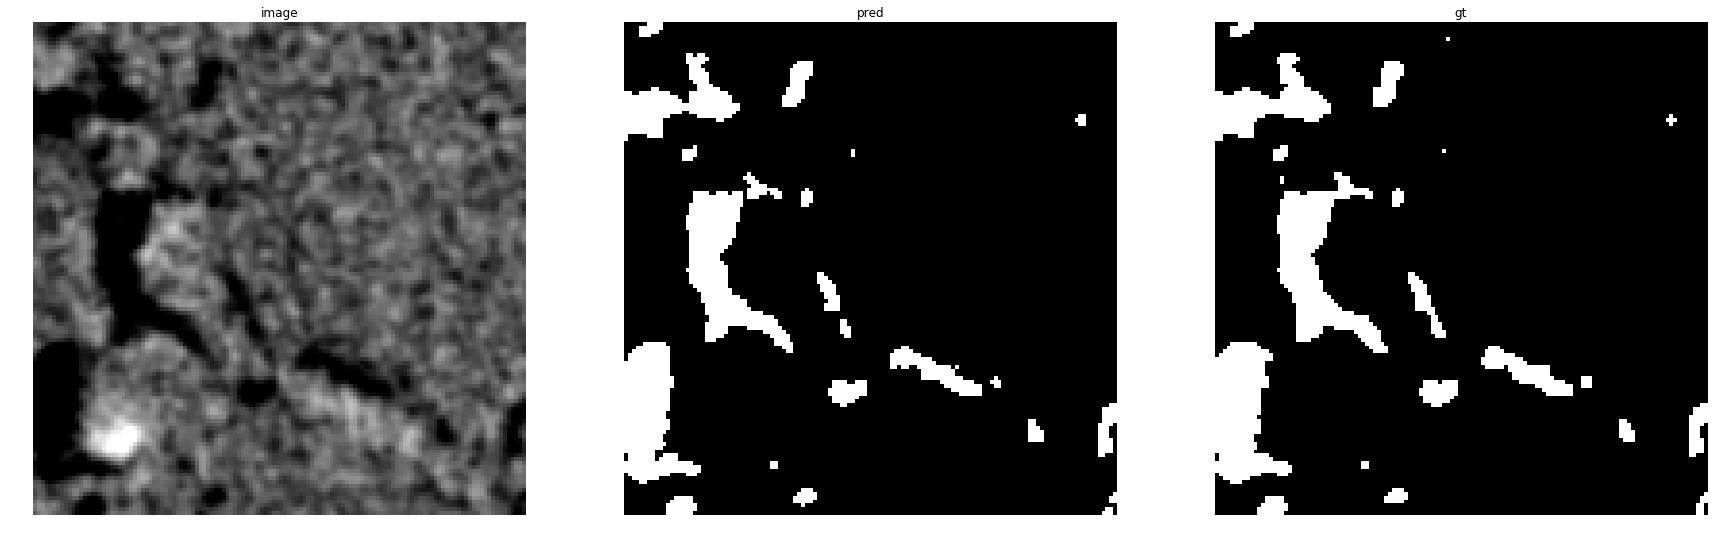

accuracy    : 0.99200439453125
precision   : 0.9909855769230769
recall      : 0.9342776203966006
f1          : 0.9617964421114027
pr_auc      : 0.9955966653733507
iou         : 0.9264044943820224


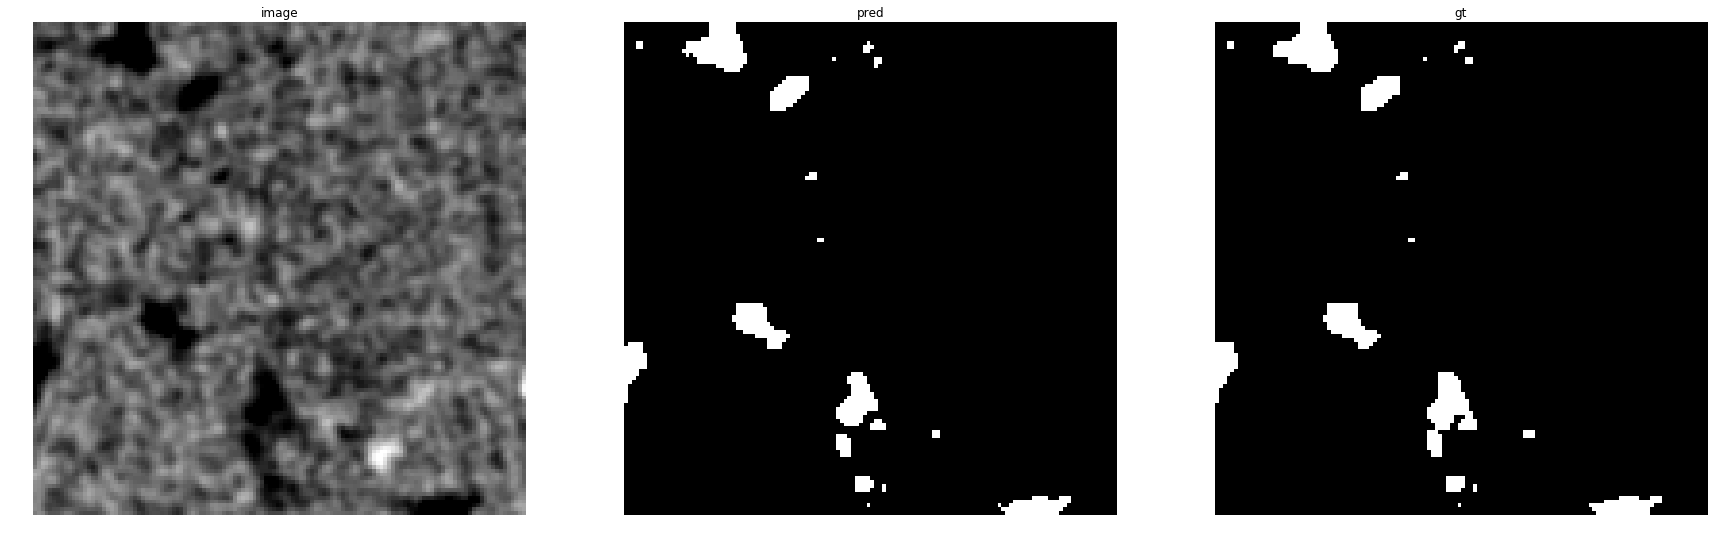

accuracy    : 0.99676513671875
precision   : 0.9914965986394558
recall      : 0.9239302694136292
f1          : 0.9565217391304349
pr_auc      : 0.9905741675272557
iou         : 0.9166666666666666
Urna_22


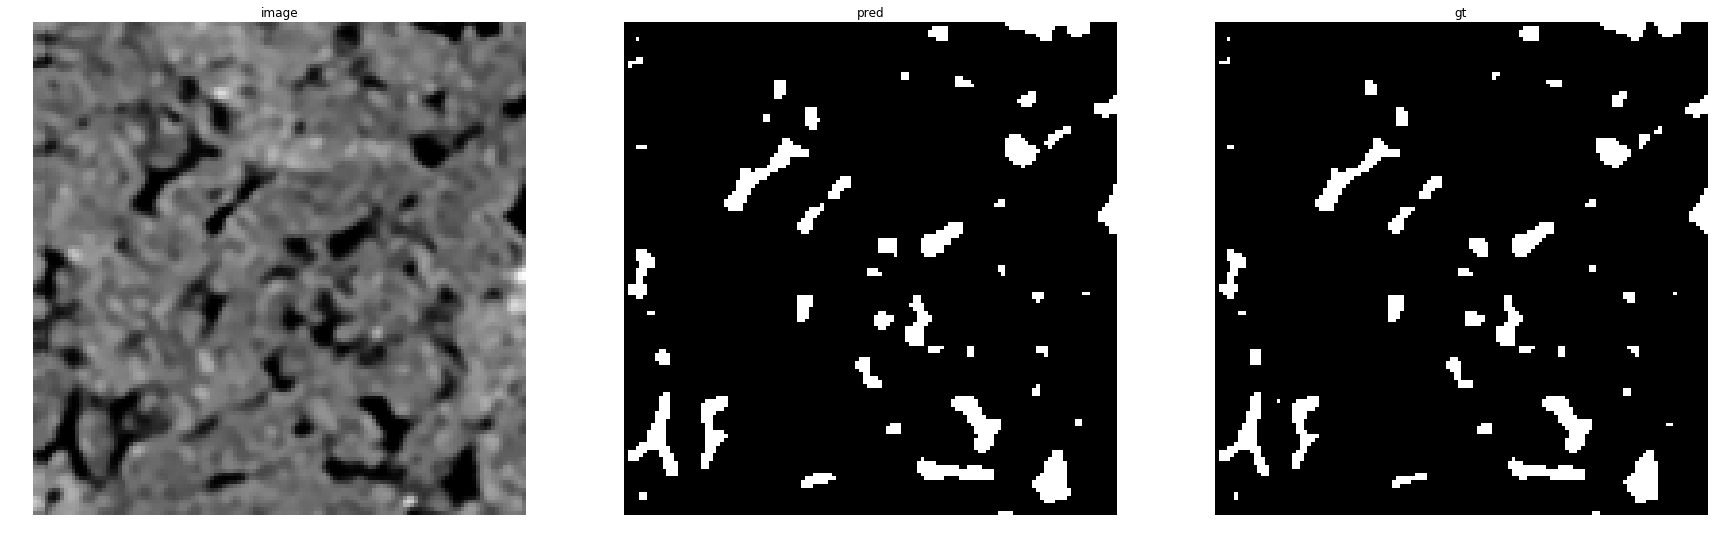

accuracy    : 0.99267578125
precision   : 0.9117889530090684
recall      : 0.9883824843610366
f1          : 0.9485420240137221
pr_auc      : 0.9948533090188042
iou         : 0.9021207177814029


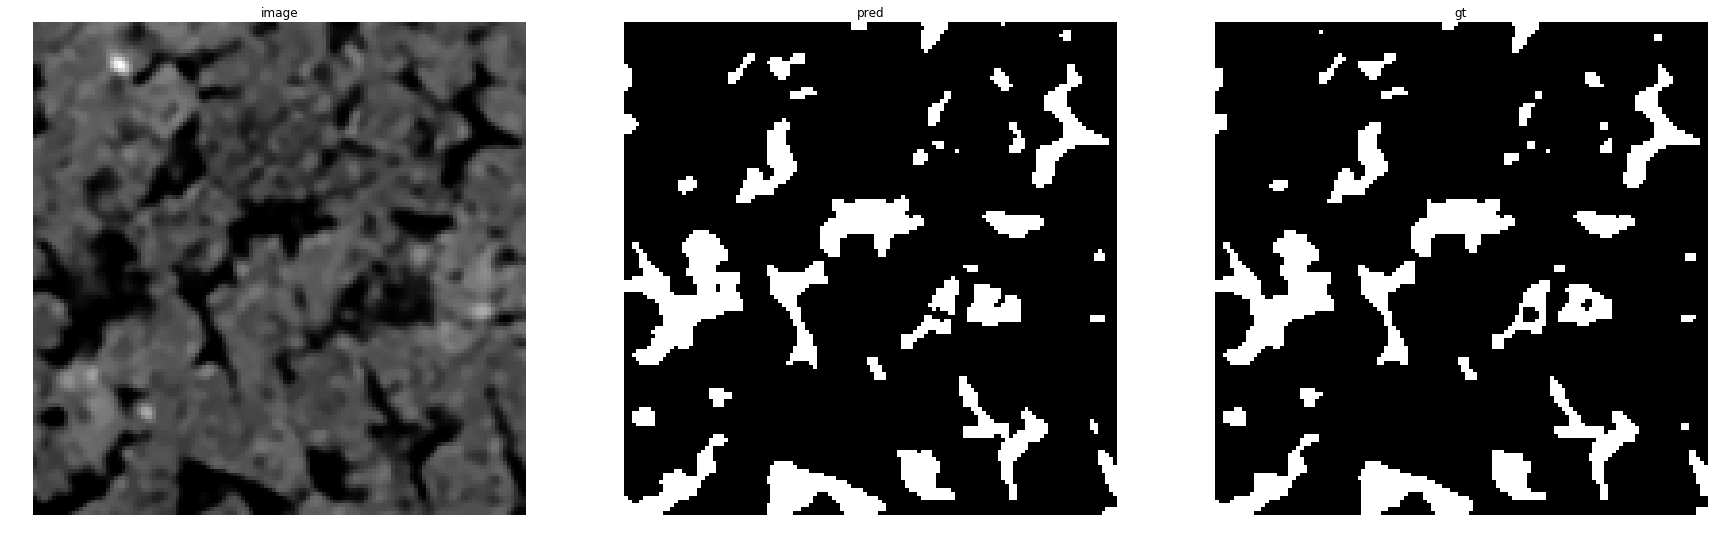

accuracy    : 0.986328125
precision   : 0.927831094049904
recall      : 0.9853240929474113
f1          : 0.955713720838276
pr_auc      : 0.9964549711204119
iou         : 0.9151836425596365


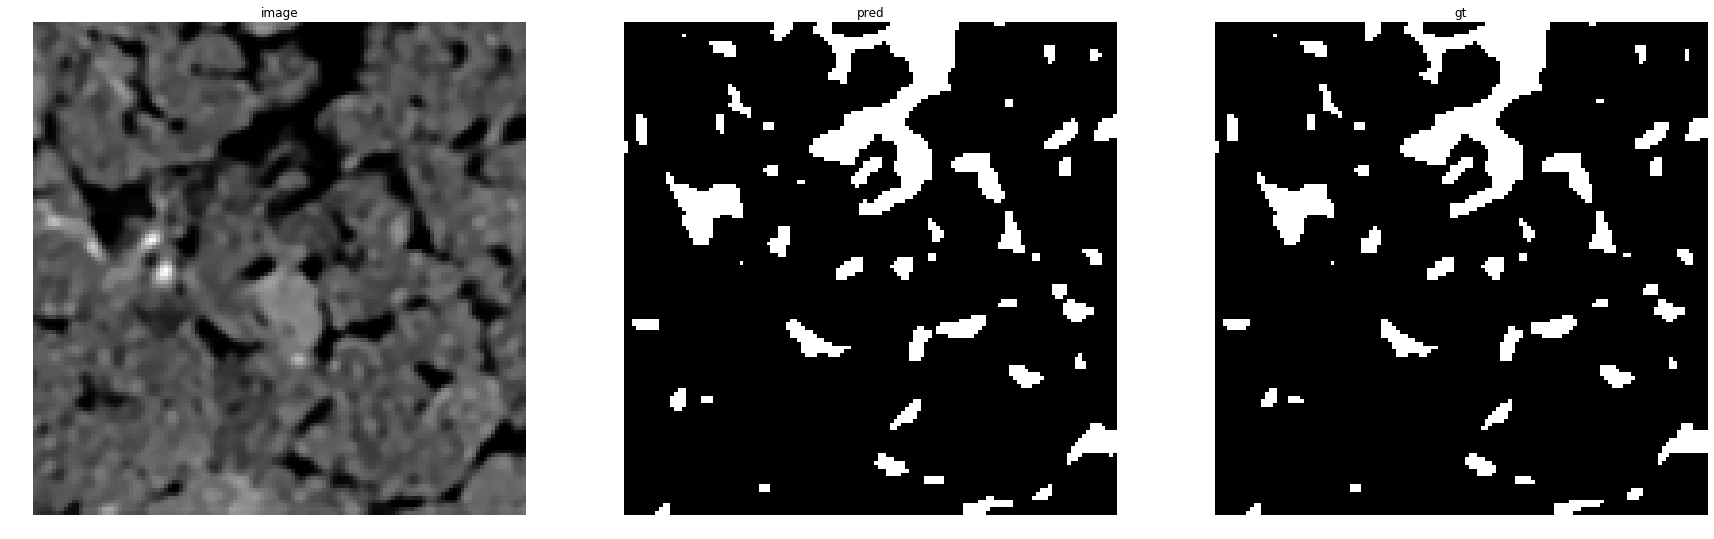

accuracy    : 0.9915771484375
precision   : 0.9399098647971958
recall      : 0.9905013192612138
f1          : 0.9645426515930113
pr_auc      : 0.9974820980321699
iou         : 0.9315136476426799


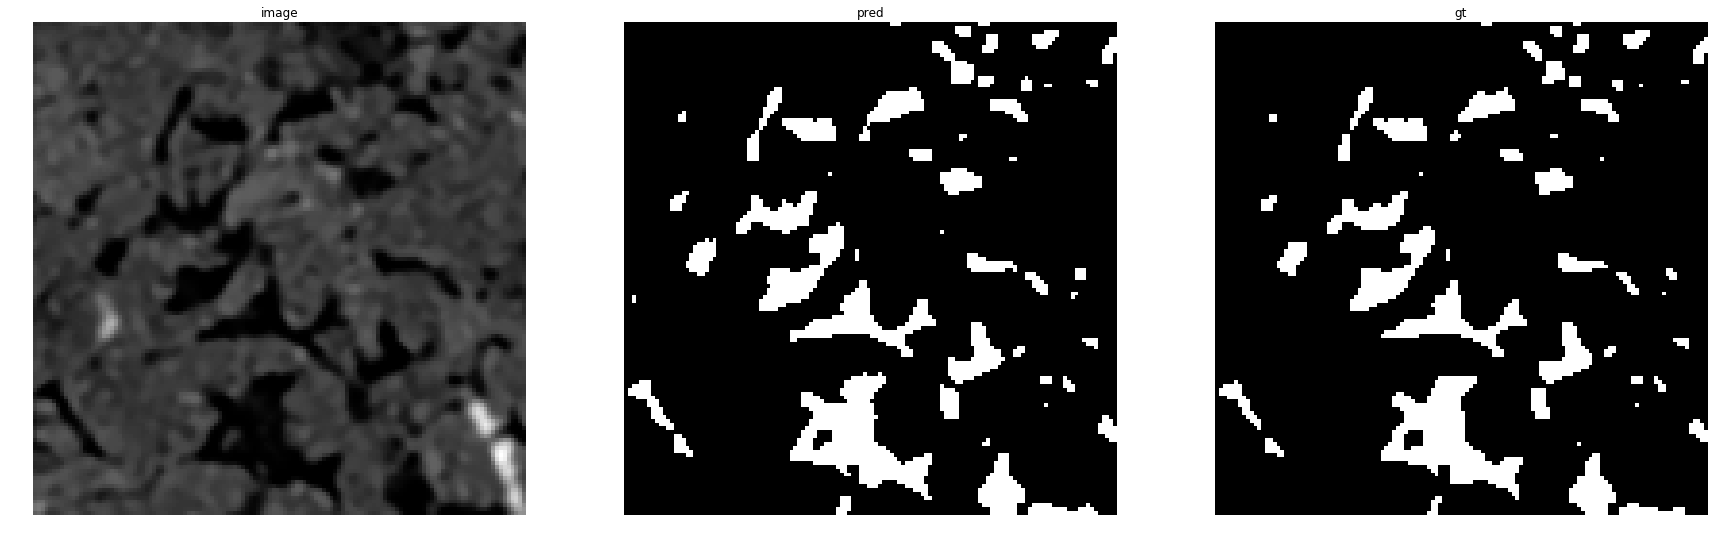

accuracy    : 0.98858642578125
precision   : 0.916394208313872
recall      : 0.9959390862944163
f1          : 0.9545122841157868
pr_auc      : 0.9976387459632278
iou         : 0.9129827826896231


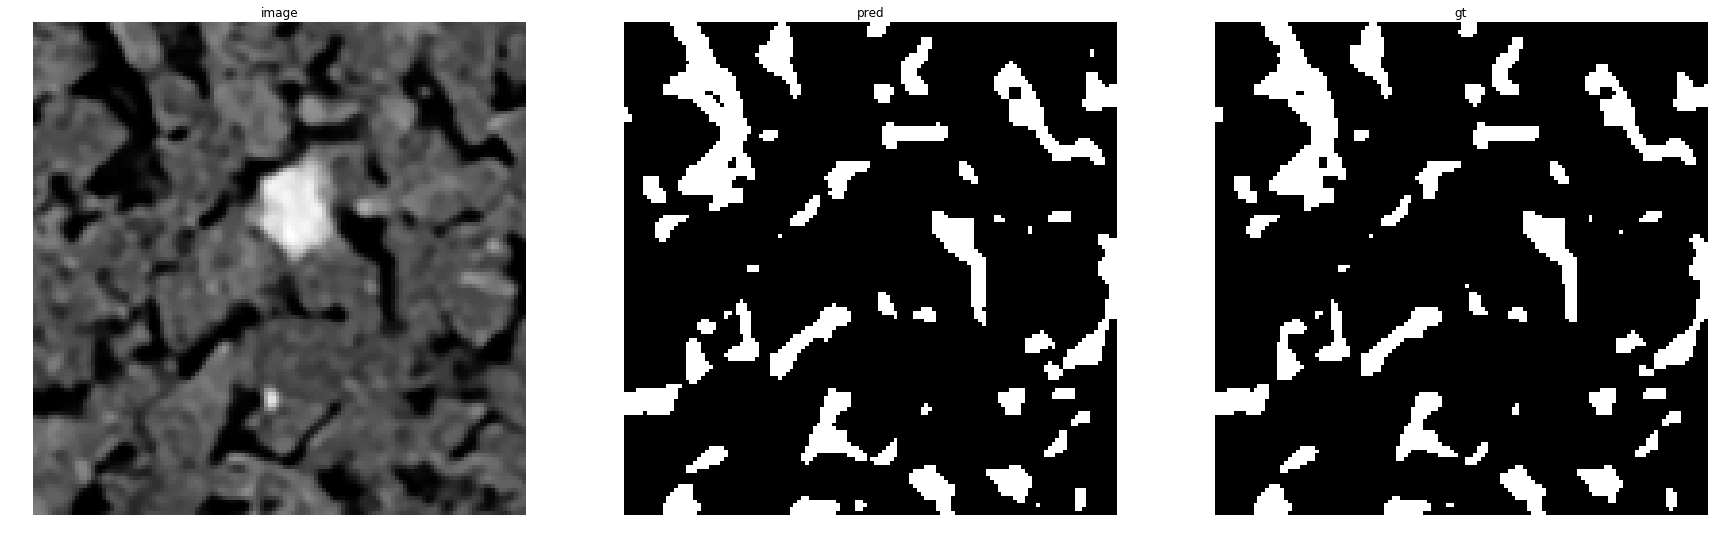

accuracy    : 0.9879150390625
precision   : 0.9350890207715133
recall      : 0.9909591194968553
f1          : 0.9622137404580153
pr_auc      : 0.9968736589475802
iou         : 0.9271791099668996


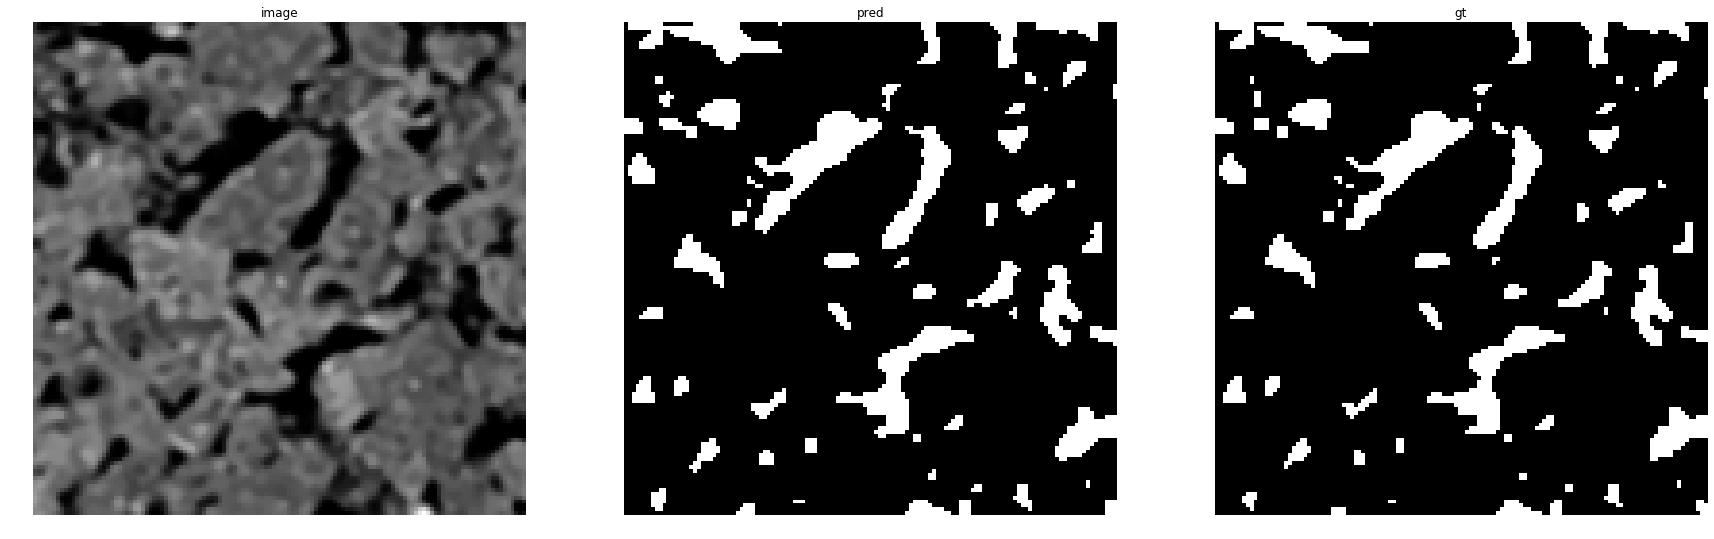

accuracy    : 0.98944091796875
precision   : 0.9315307457479285
recall      : 0.9925650557620818
f1          : 0.9610798650168729
pr_auc      : 0.9967191818277872
iou         : 0.9250757903854483


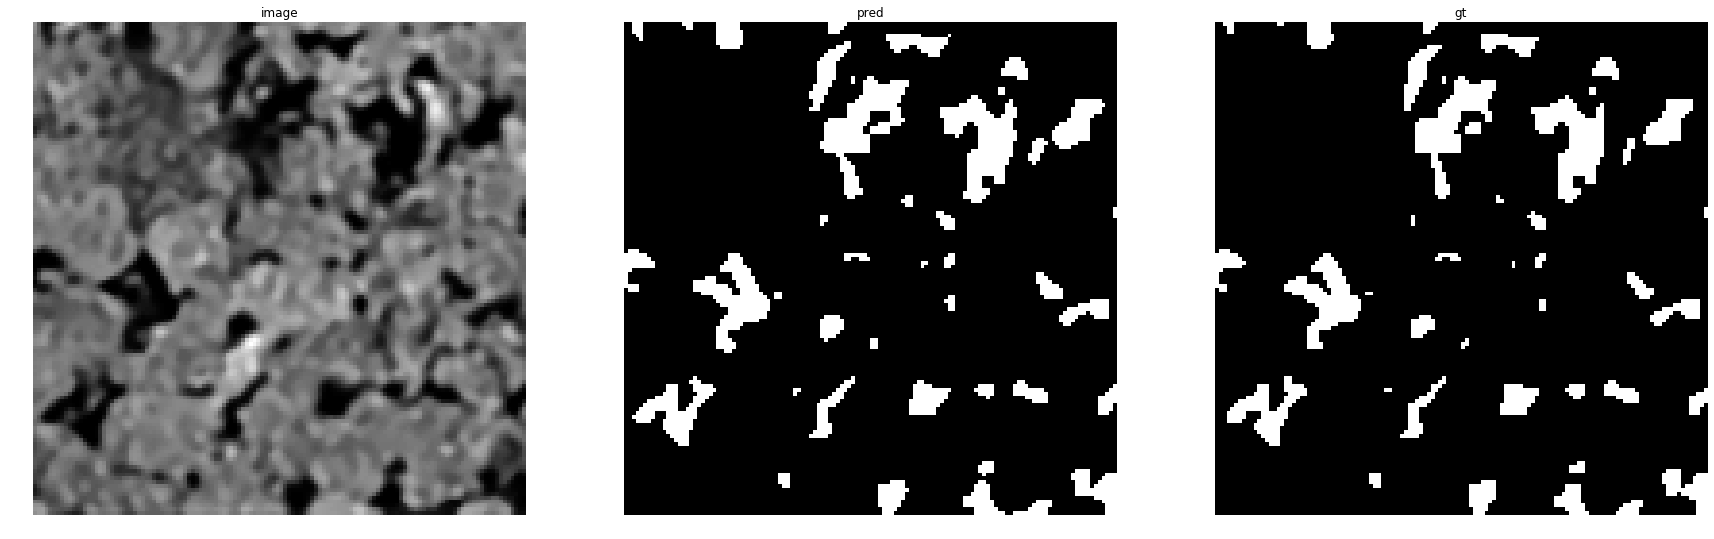

accuracy    : 0.989501953125
precision   : 0.9170081967213115
recall      : 0.9944444444444445
f1          : 0.9541577825159915
pr_auc      : 0.9973569755515295
iou         : 0.9123343527013251


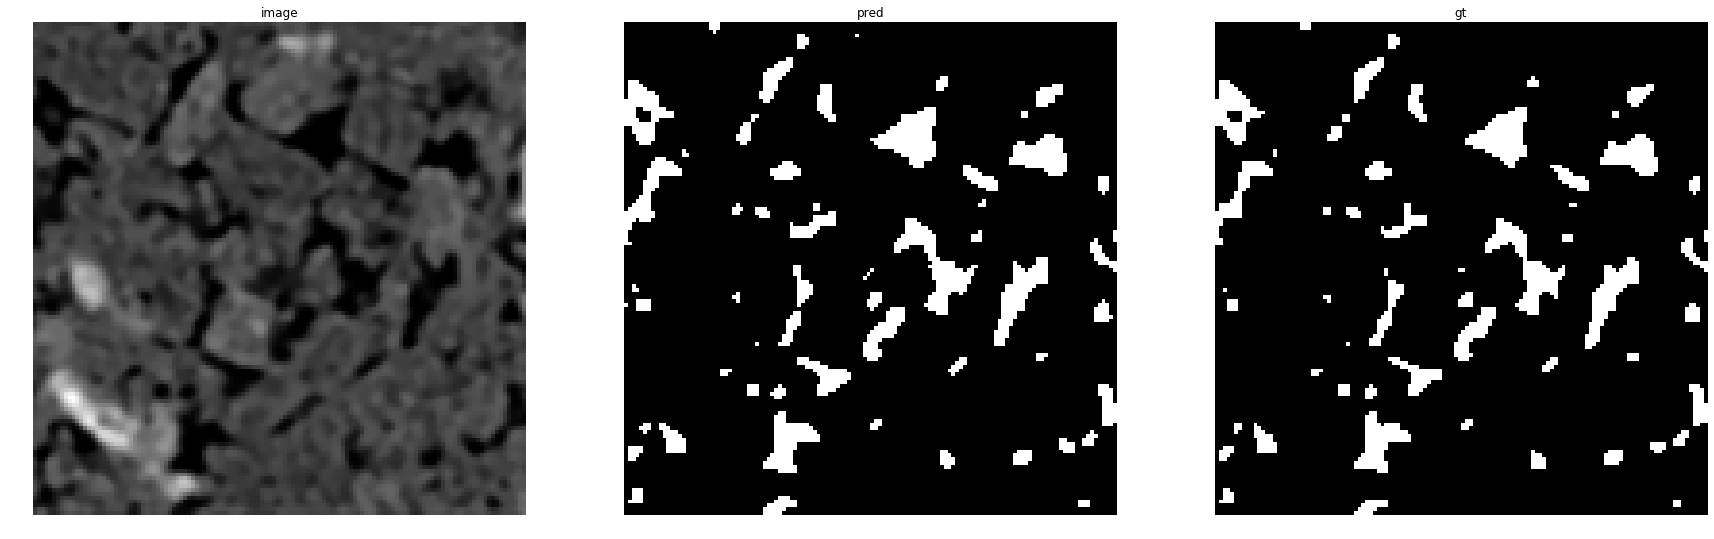

accuracy    : 0.989013671875
precision   : 0.9102040816326531
recall      : 0.9836168872085697
f1          : 0.945487583282859
pr_auc      : 0.9953125646980463
iou         : 0.8966111430212521


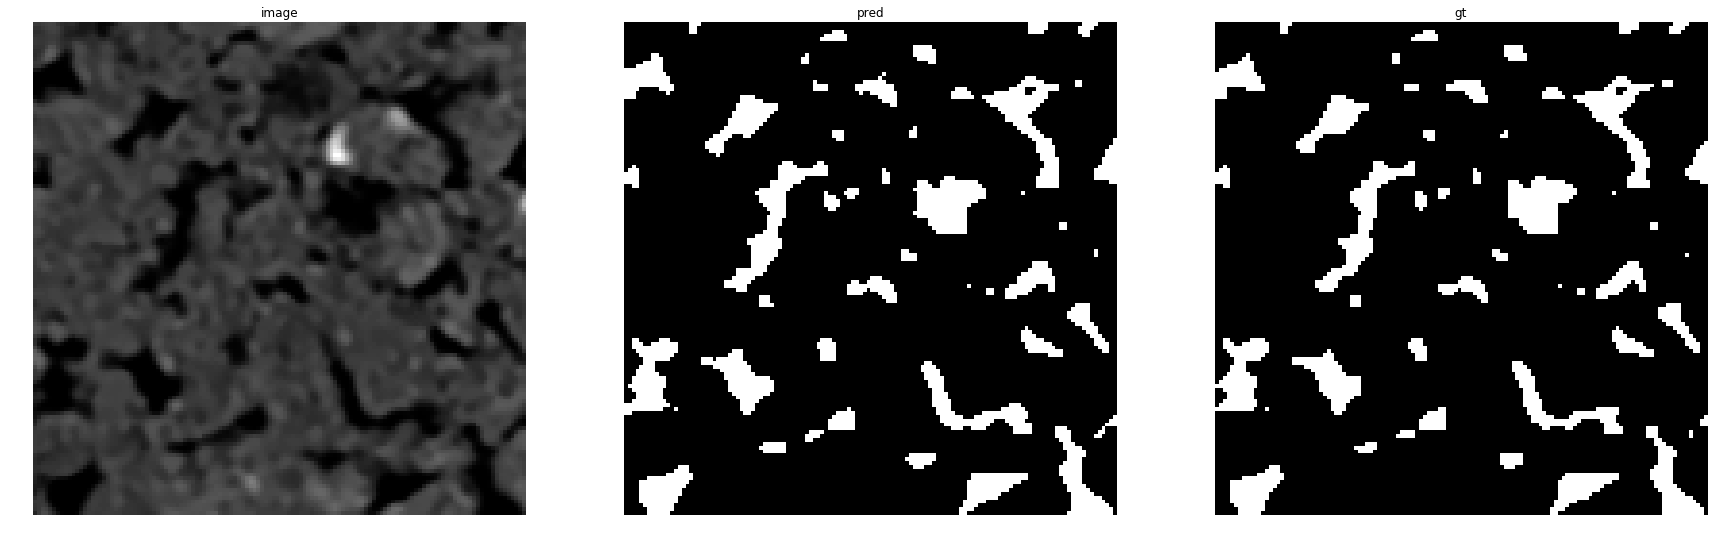

accuracy    : 0.99017333984375
precision   : 0.9385026737967914
recall      : 0.9891968060122123
f1          : 0.9631831694488909
pr_auc      : 0.9969984229154657
iou         : 0.9289810322011469


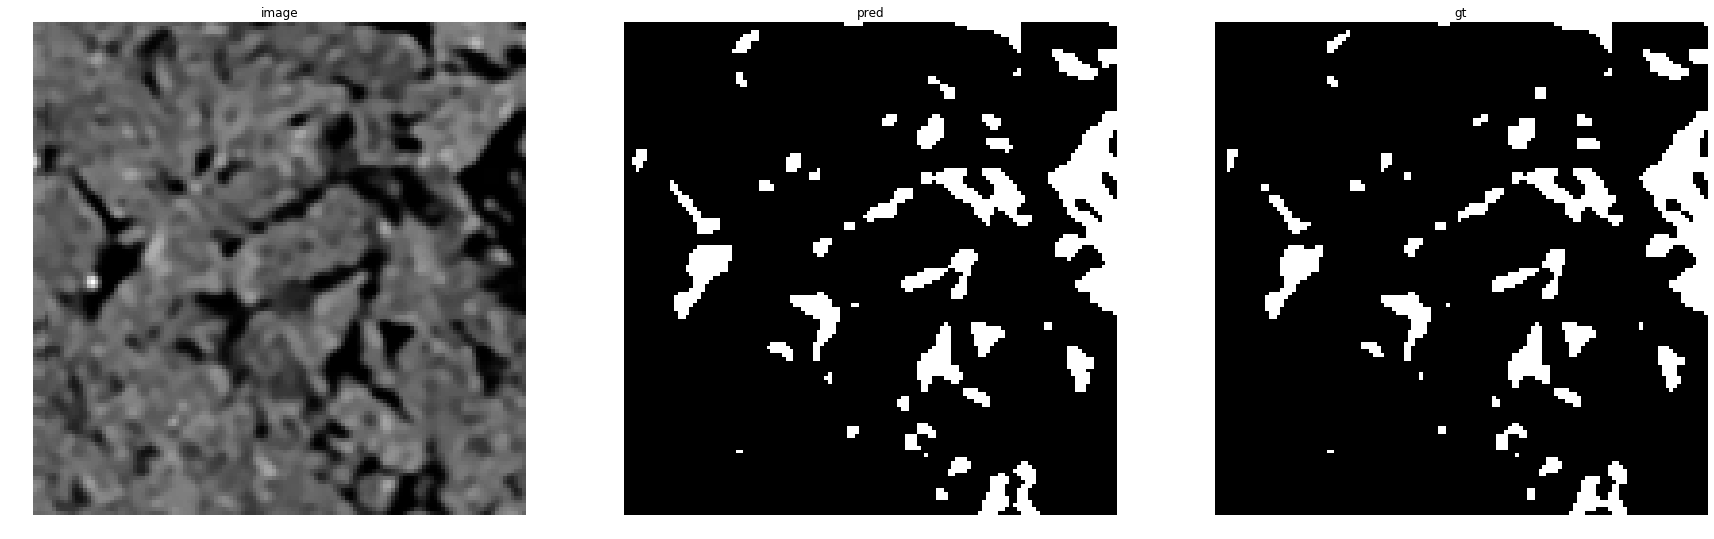

accuracy    : 0.989013671875
precision   : 0.911064055055585
recall      : 0.9930755914598961
f1          : 0.9503036996134733
pr_auc      : 0.9970040091942527
iou         : 0.9053129931614939
Urna_30


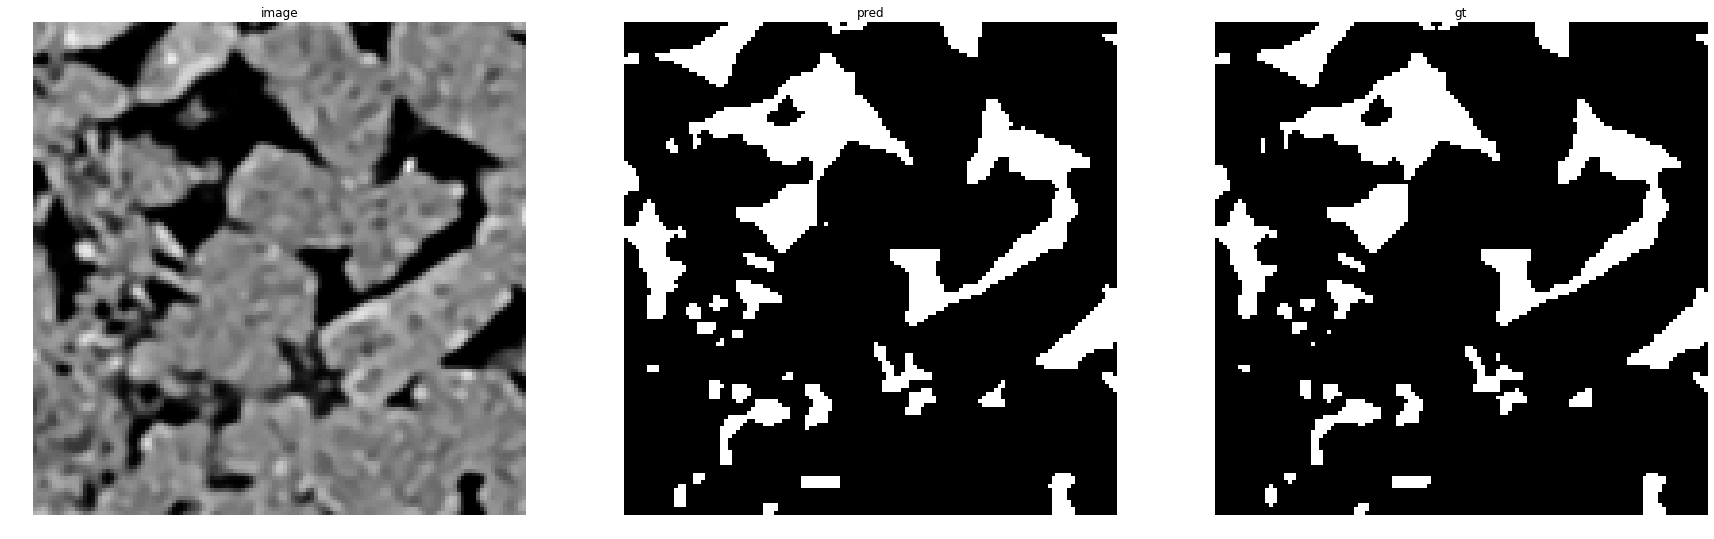

accuracy    : 0.987548828125
precision   : 0.9434881455017863
recall      : 0.989778534923339
f1          : 0.9660791486531426
pr_auc      : 0.9975021057665359
iou         : 0.9343840463171438


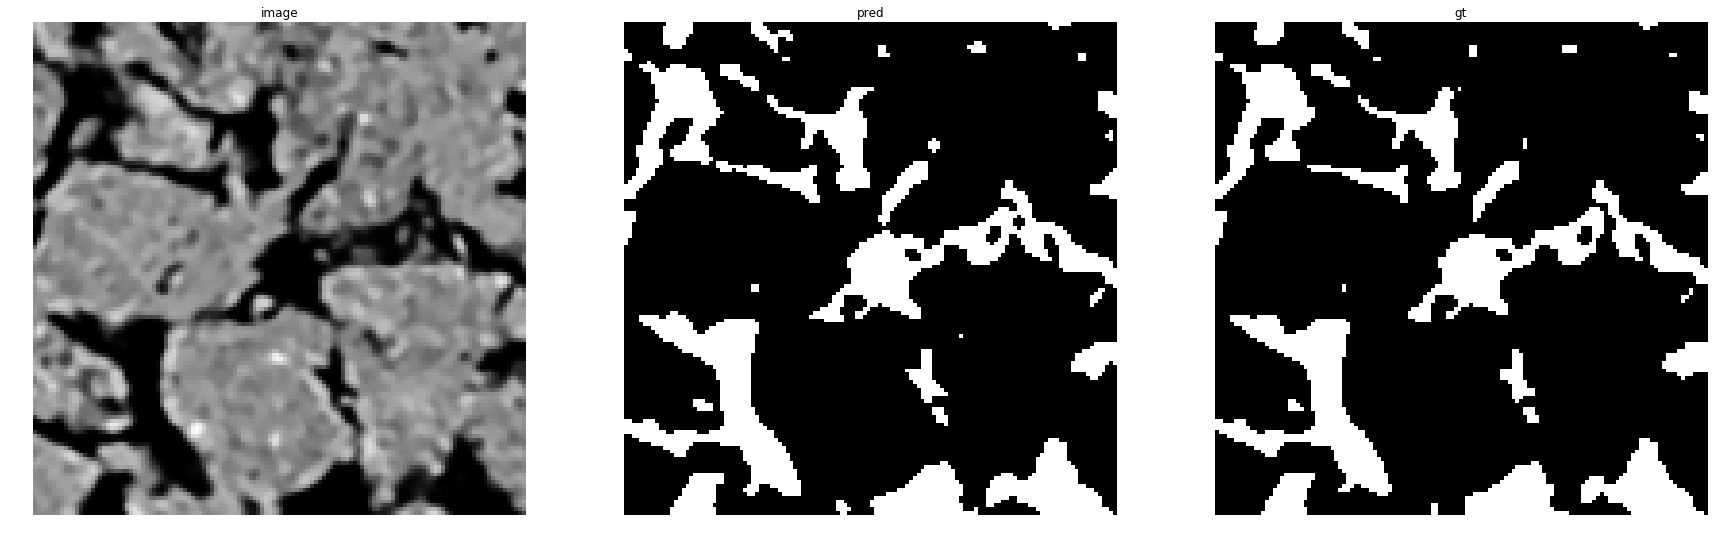

accuracy    : 0.98382568359375
precision   : 0.9305064782096584
recall      : 0.9909062402006898
f1          : 0.9597570235383447
pr_auc      : 0.9970231993159094
iou         : 0.9226277372262773


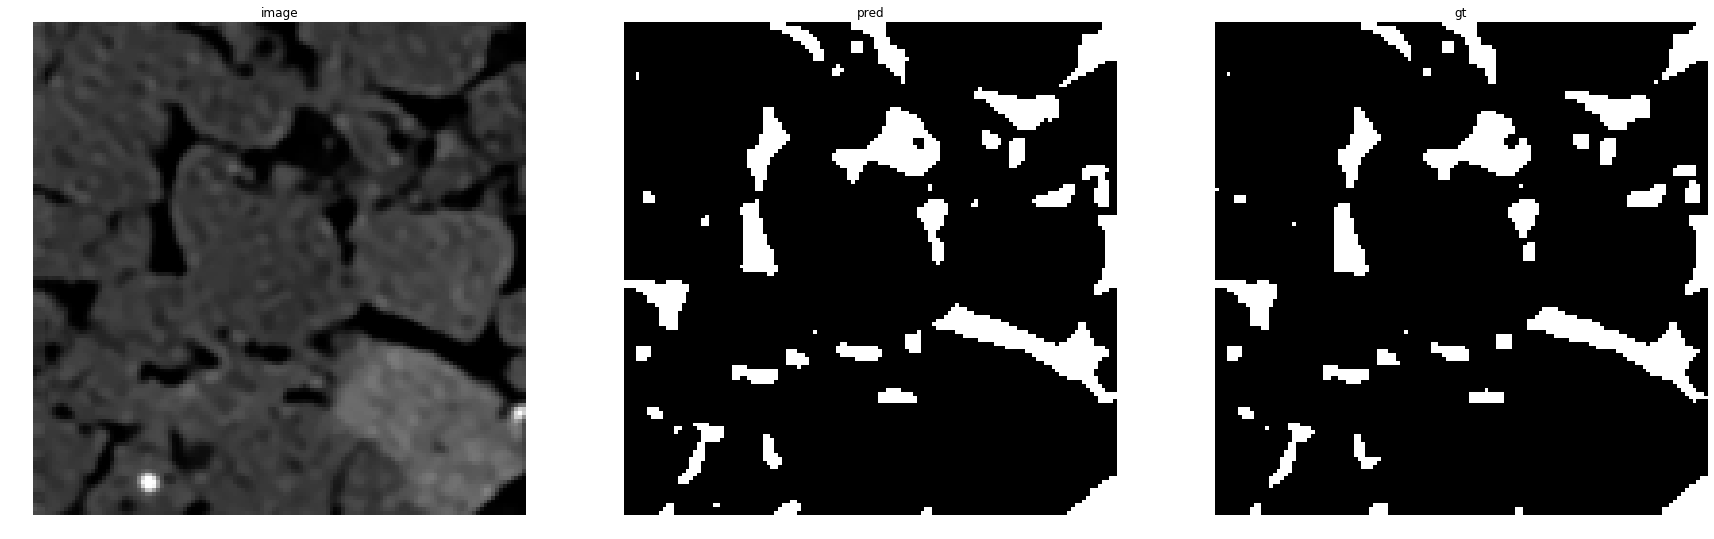

accuracy    : 0.9898681640625
precision   : 0.9266732283464567
recall      : 0.9910526315789474
f1          : 0.9577822990844355
pr_auc      : 0.9969186504629954
iou         : 0.9189848706686189


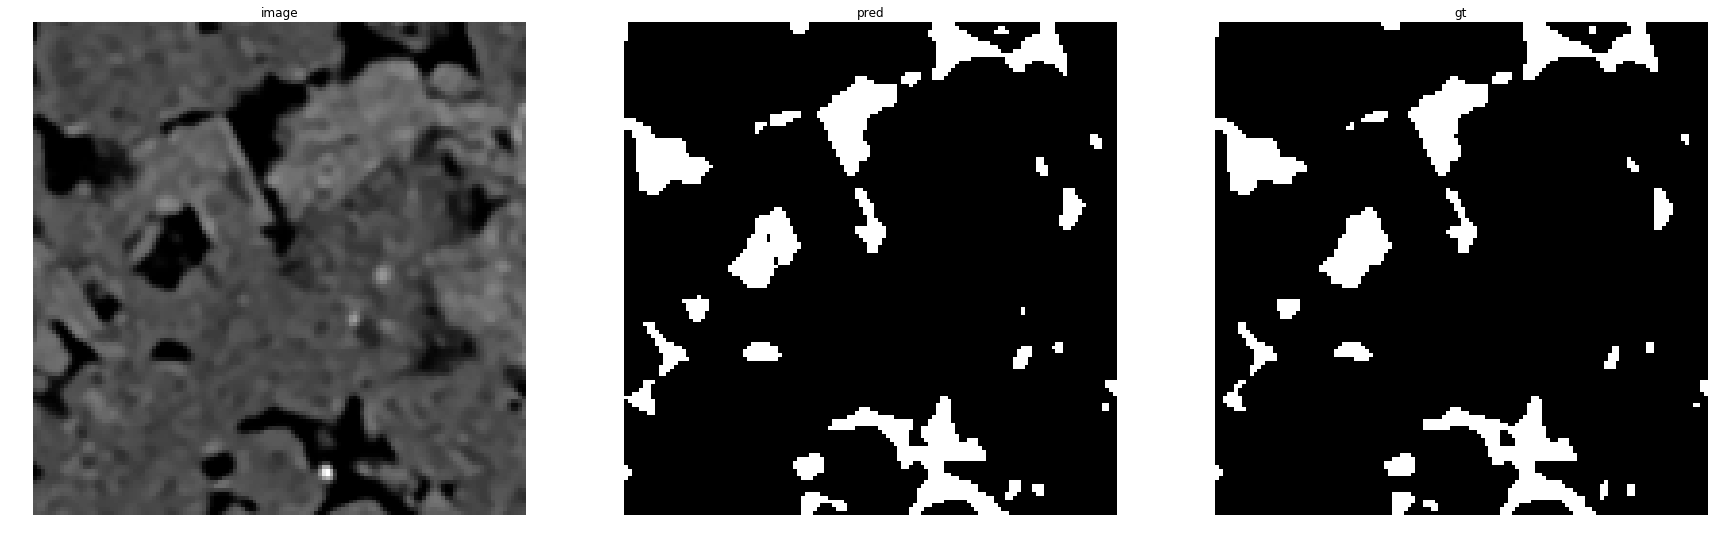

accuracy    : 0.98968505859375
precision   : 0.926250644662197
recall      : 0.9857299670691547
f1          : 0.9550651422494018
pr_auc      : 0.9964308013212684
iou         : 0.9139949109414758


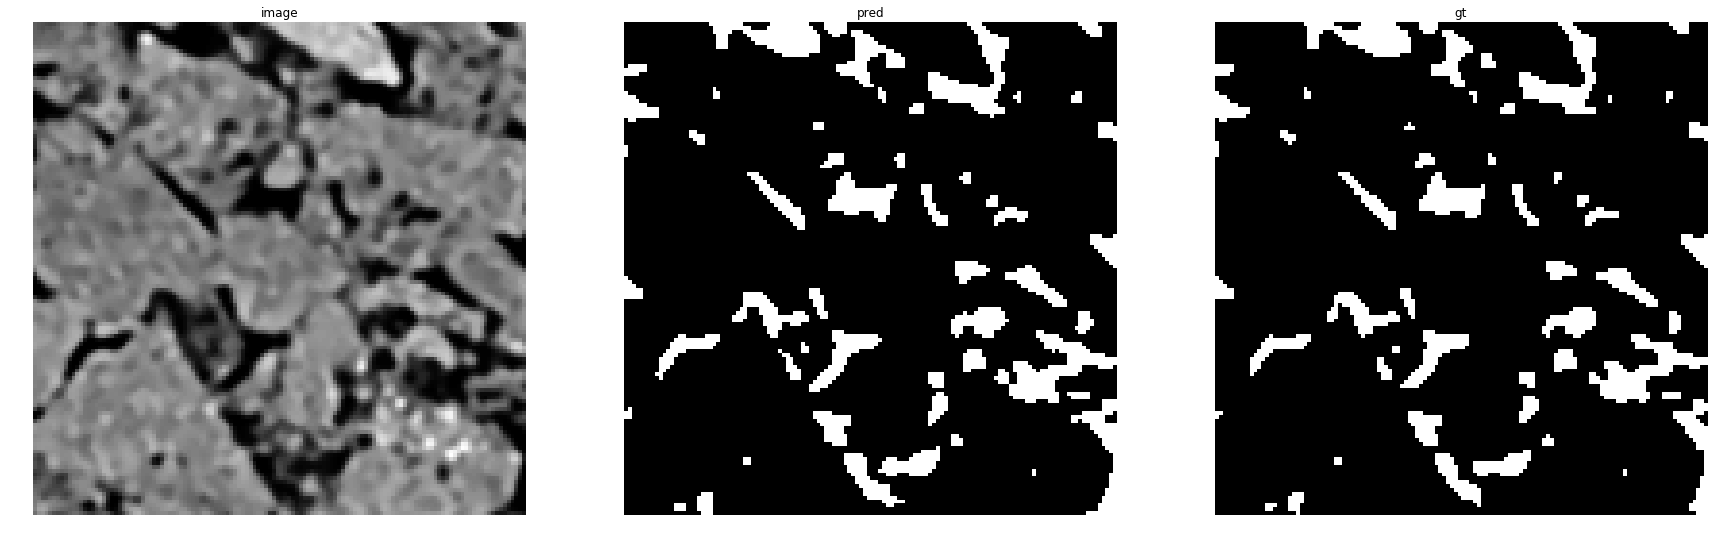

accuracy    : 0.98699951171875
precision   : 0.9077916090364223
recall      : 0.9934409687184662
f1          : 0.9486870633582268
pr_auc      : 0.9952858116938831
iou         : 0.9023831347387717


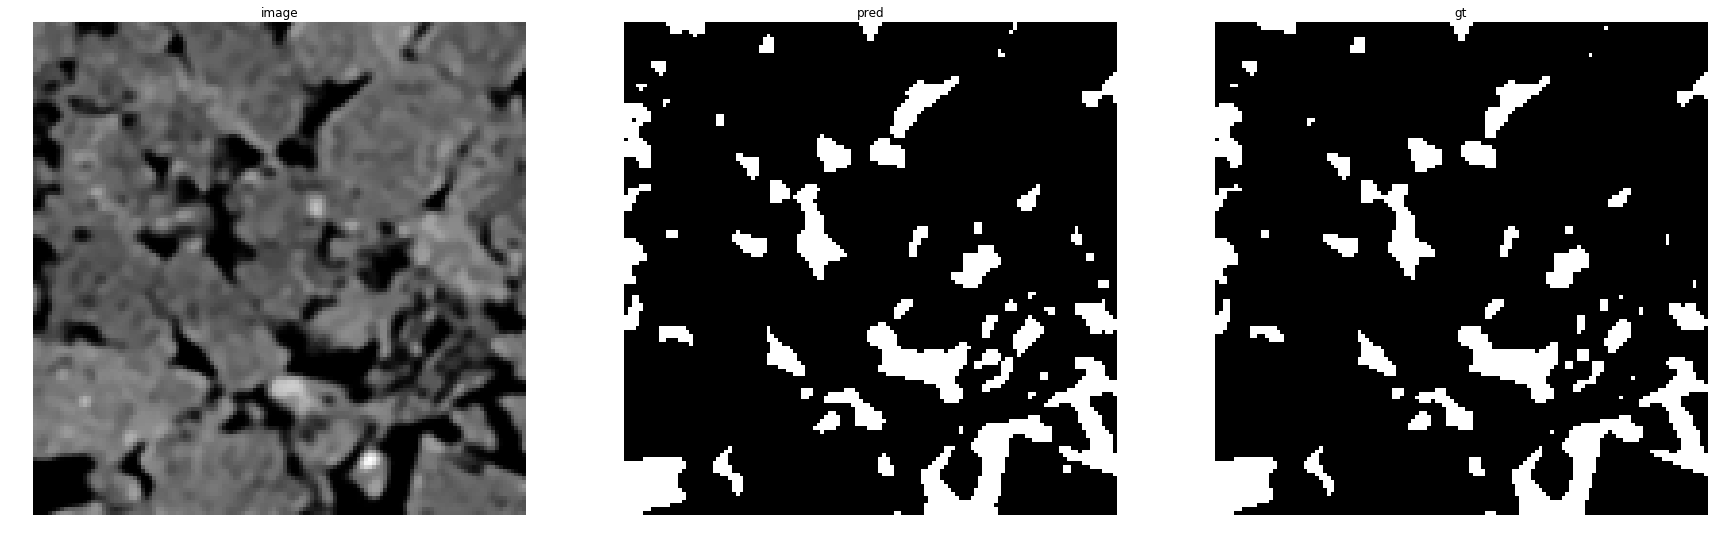

accuracy    : 0.98504638671875
precision   : 0.907369287772746
recall      : 0.9910071942446043
f1          : 0.9473457984096281
pr_auc      : 0.995850220575945
iou         : 0.8999591670069416


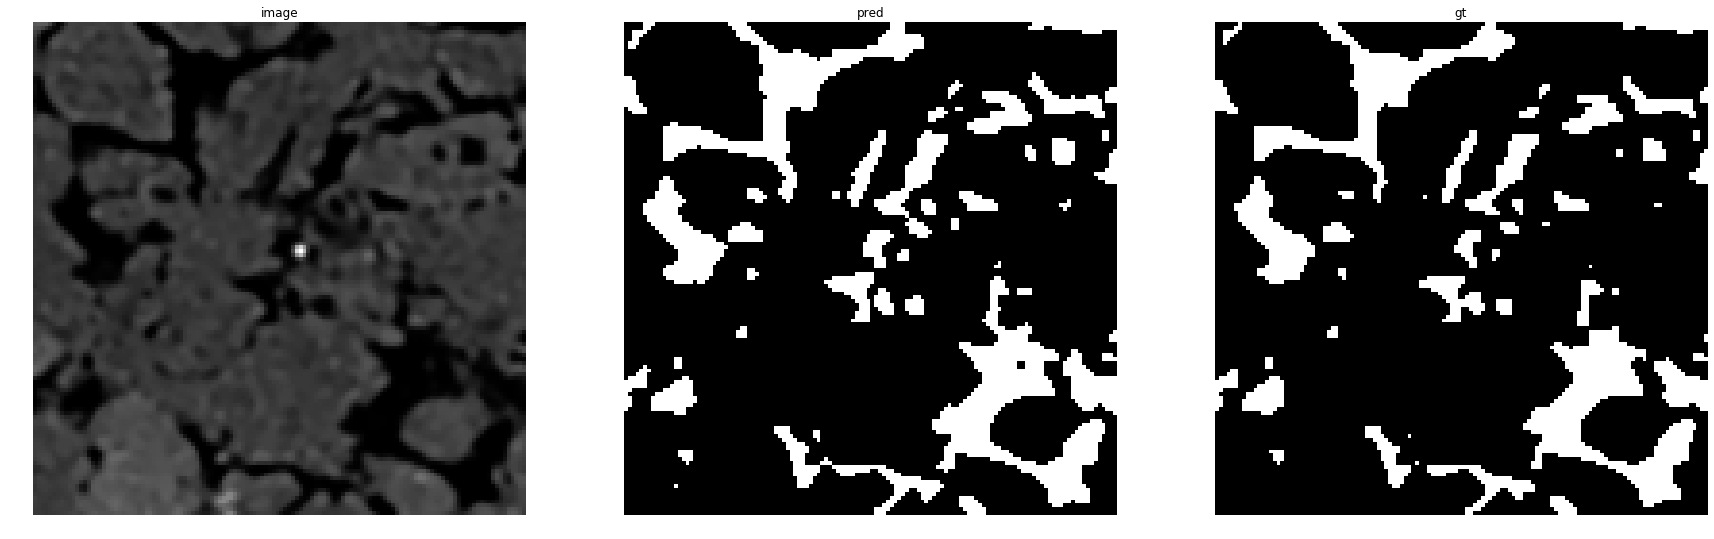

accuracy    : 0.9781494140625
precision   : 0.8951788491446345
recall      : 0.9927561228009658
f1          : 0.9414458619561661
pr_auc      : 0.9961223677992708
iou         : 0.8893695920889988


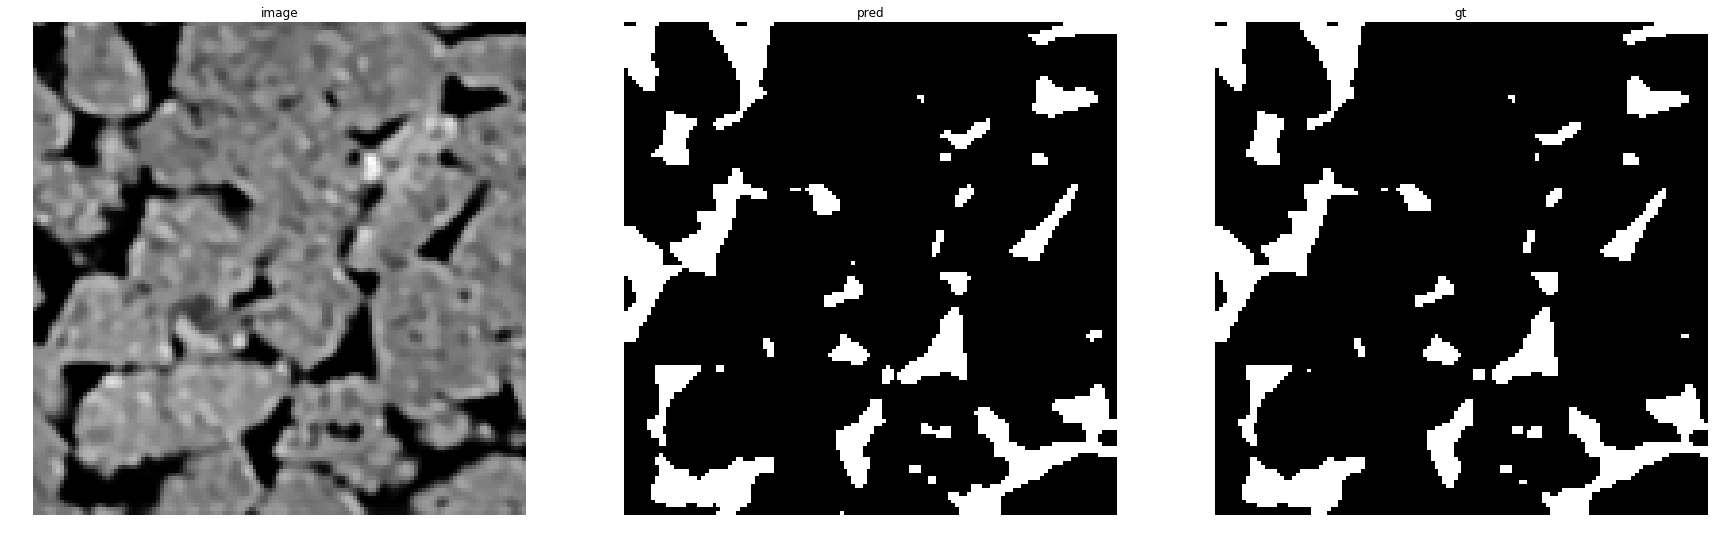

accuracy    : 0.98956298828125
precision   : 0.9400444115470022
recall      : 0.9964692036092585
f1          : 0.9674347743286993
pr_auc      : 0.9983635772890616
iou         : 0.9369236444116562


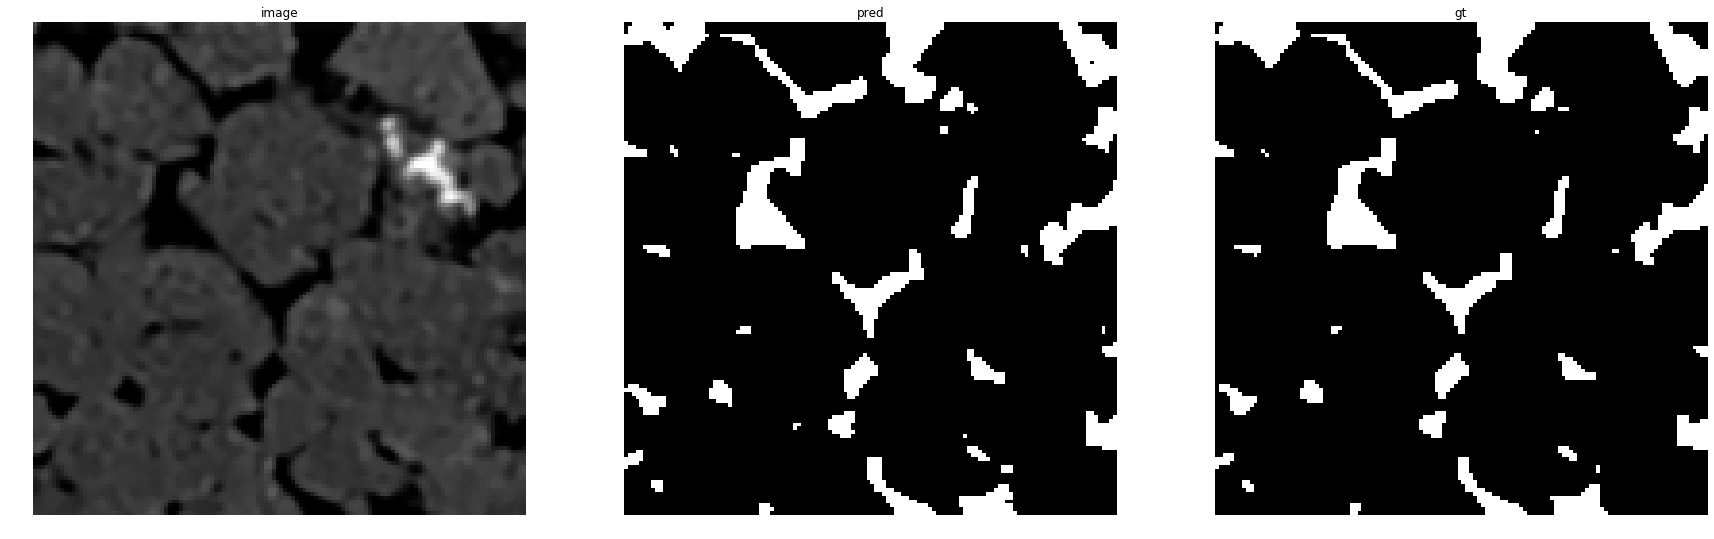

accuracy    : 0.9912109375
precision   : 0.9373420919656392
recall      : 0.9893333333333333
f1          : 0.9626362221069019
pr_auc      : 0.9973527237304953
iou         : 0.9279639819909955


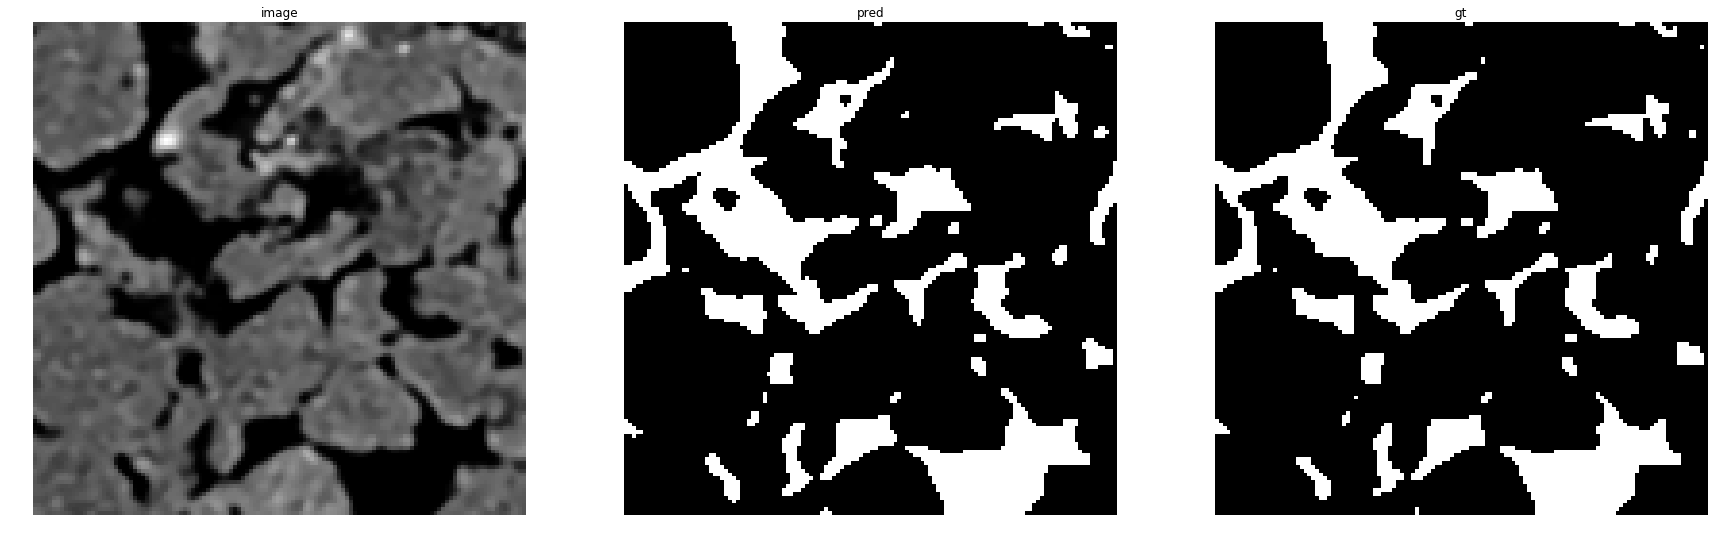

accuracy    : 0.98577880859375
precision   : 0.9425981873111783
recall      : 0.9930555555555556
f1          : 0.9671692264337045
pr_auc      : 0.9982824335754882
iou         : 0.9364256480218281
Urna_34


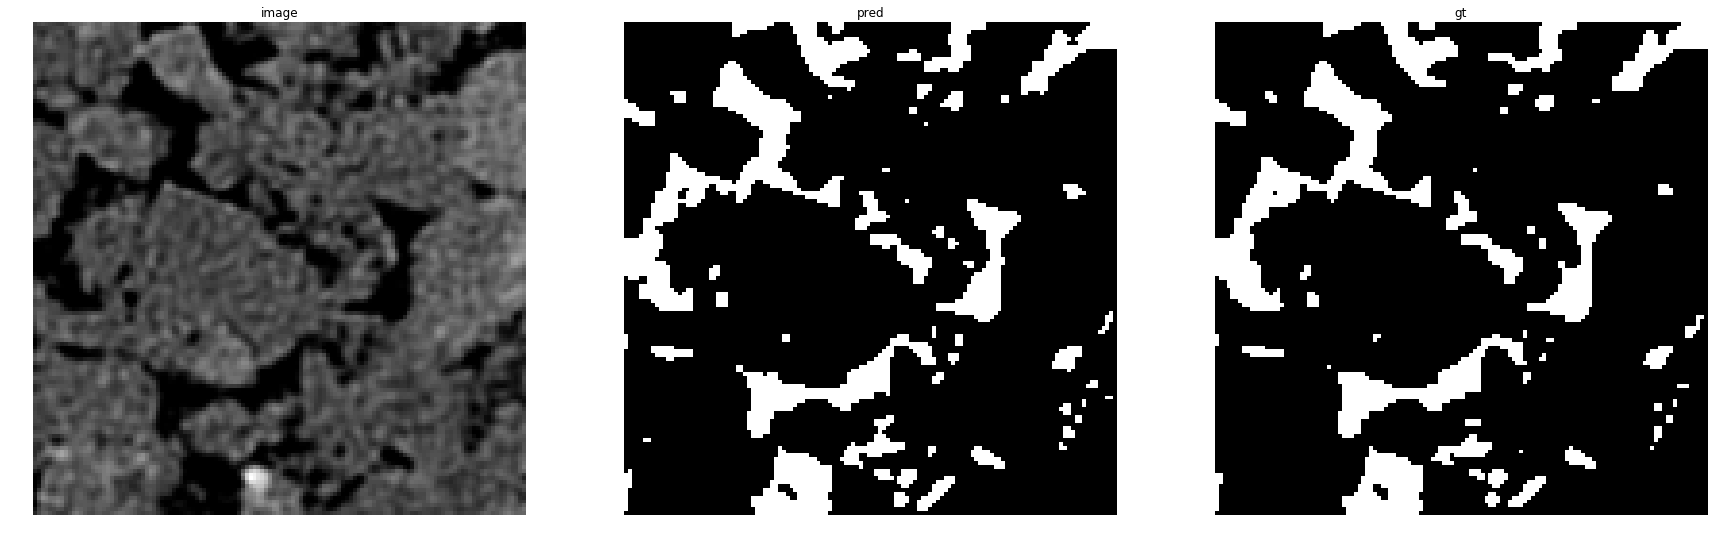

accuracy    : 0.983642578125
precision   : 0.9344978165938864
recall      : 0.9668674698795181
f1          : 0.9504071058475203
pr_auc      : 0.9928975666204458
iou         : 0.9055007052186178


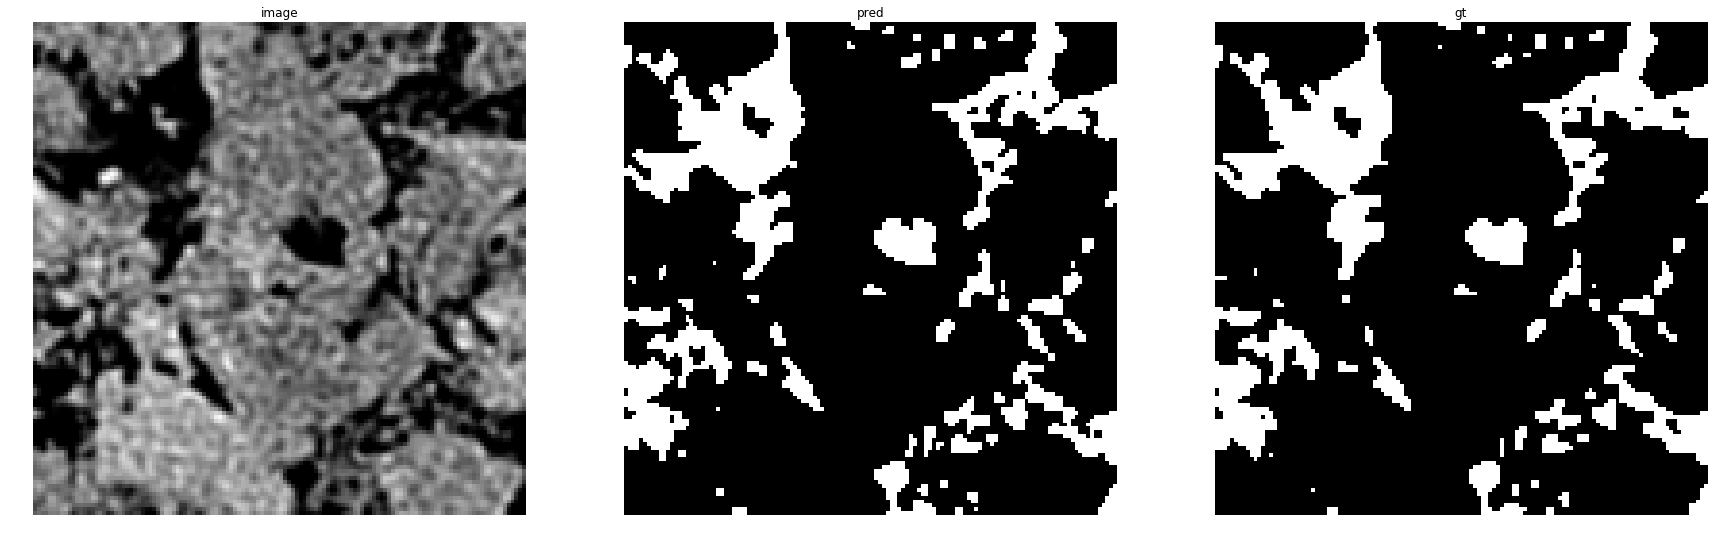

accuracy    : 0.9754638671875
precision   : 0.9277645659928656
recall      : 0.9515243902439025
f1          : 0.9394942805538832
pr_auc      : 0.989112929406425
iou         : 0.885892705080897


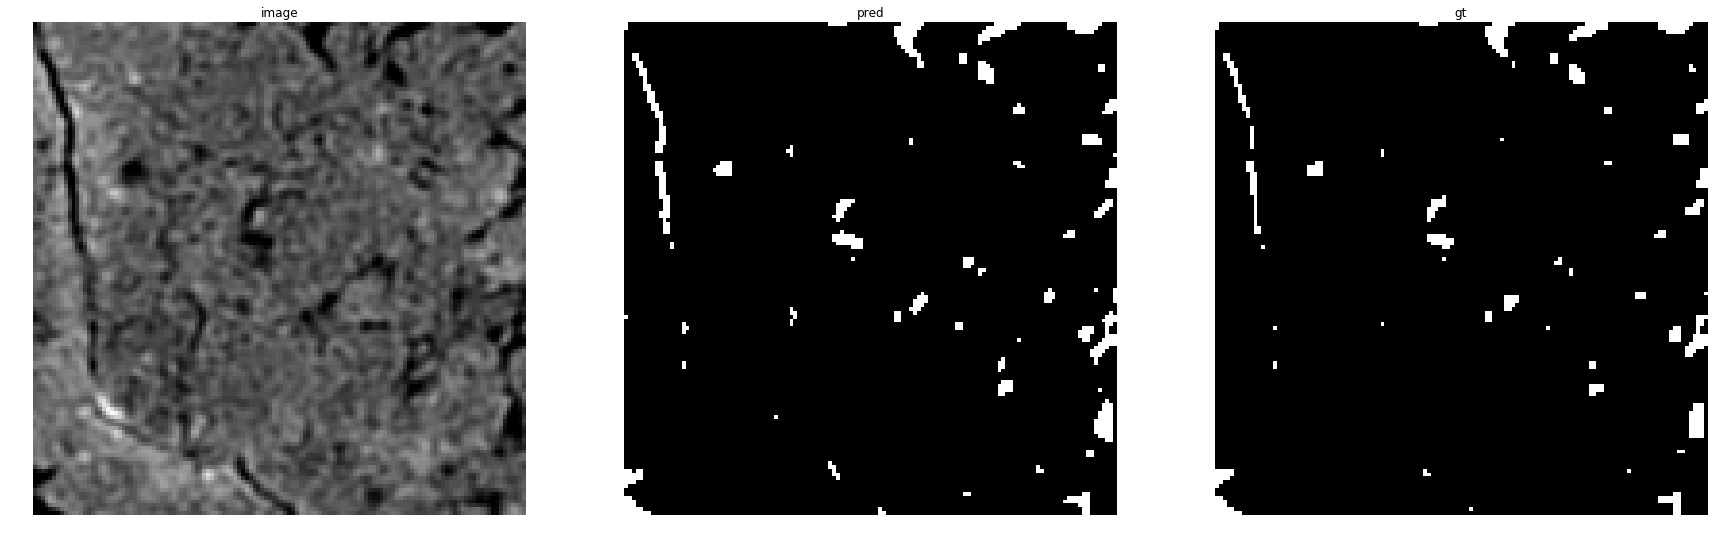

accuracy    : 0.99127197265625
precision   : 0.7833876221498371
recall      : 0.9796334012219959
f1          : 0.8705882352941177
pr_auc      : 0.9829214985551976
iou         : 0.7708333333333334


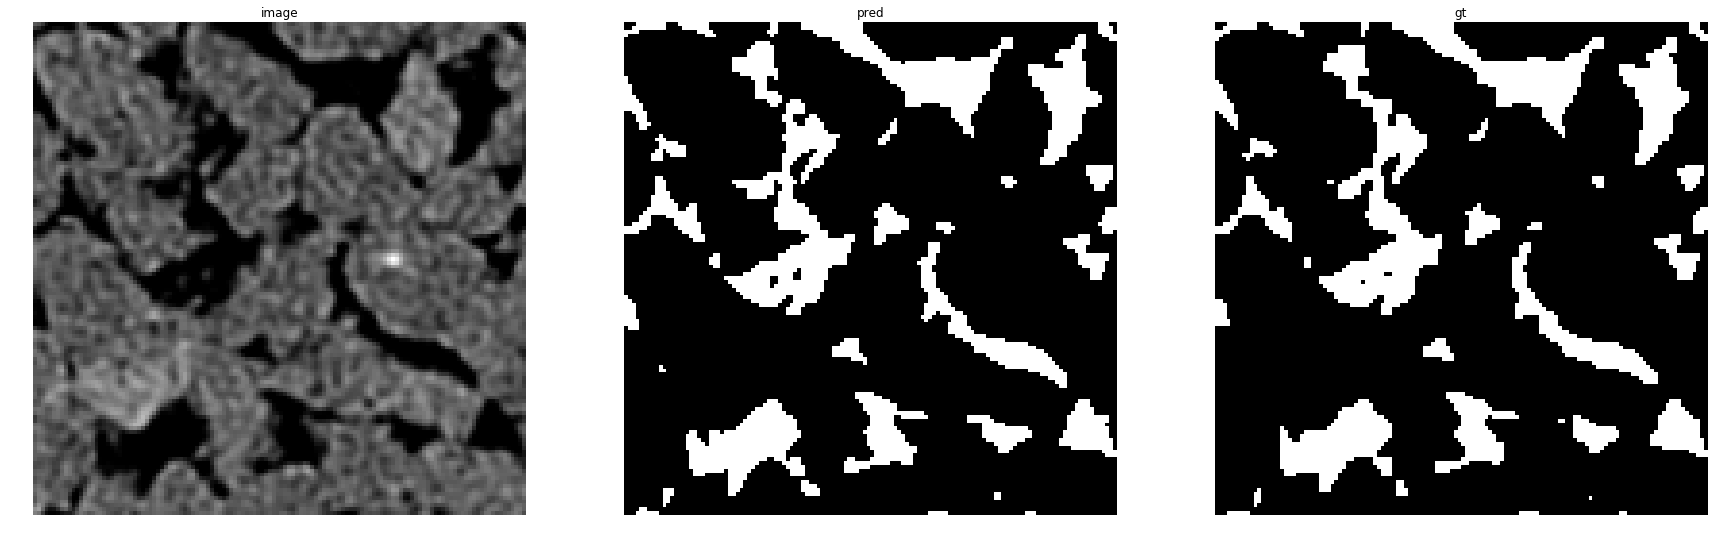

accuracy    : 0.982421875
precision   : 0.9414147709566844
recall      : 0.9679589875040051
f1          : 0.9545023696682464
pr_auc      : 0.9939531875825571
iou         : 0.9129646418857661


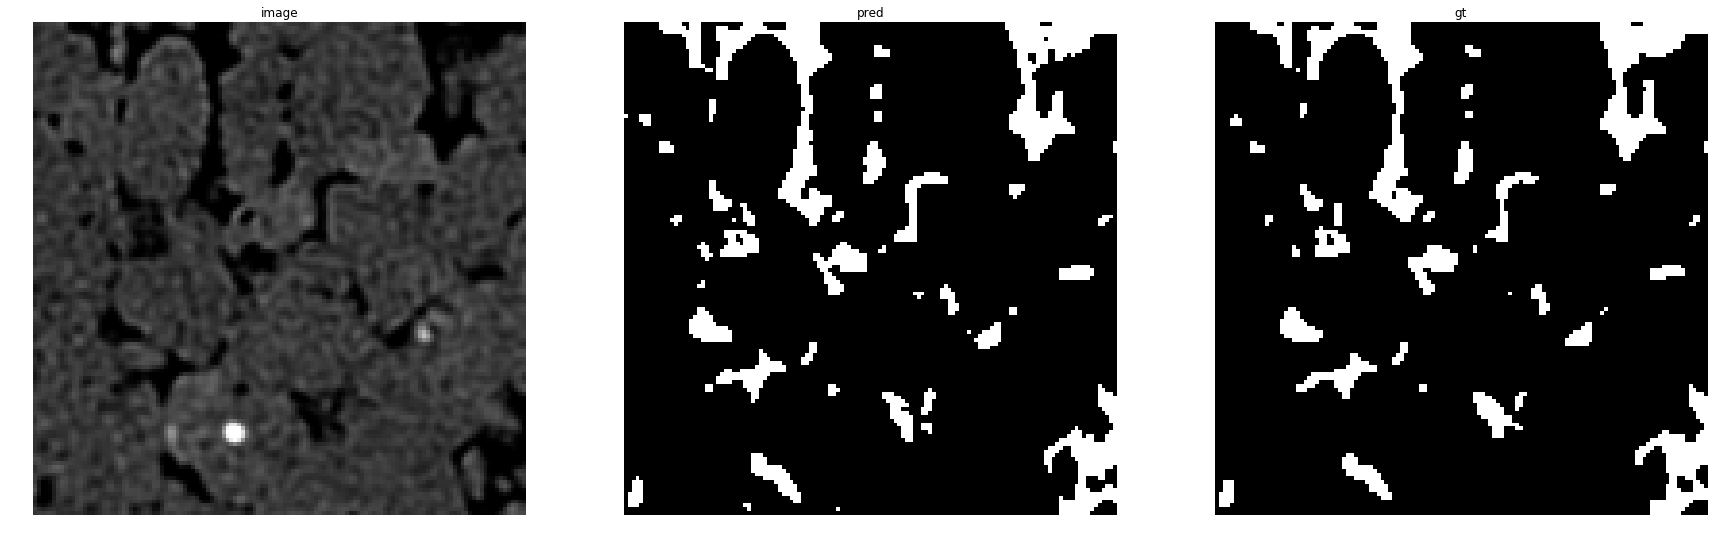

accuracy    : 0.986083984375
precision   : 0.9188361408882083
recall      : 0.9630818619582665
f1          : 0.9404388714733543
pr_auc      : 0.9903286643972824
iou         : 0.8875739644970414


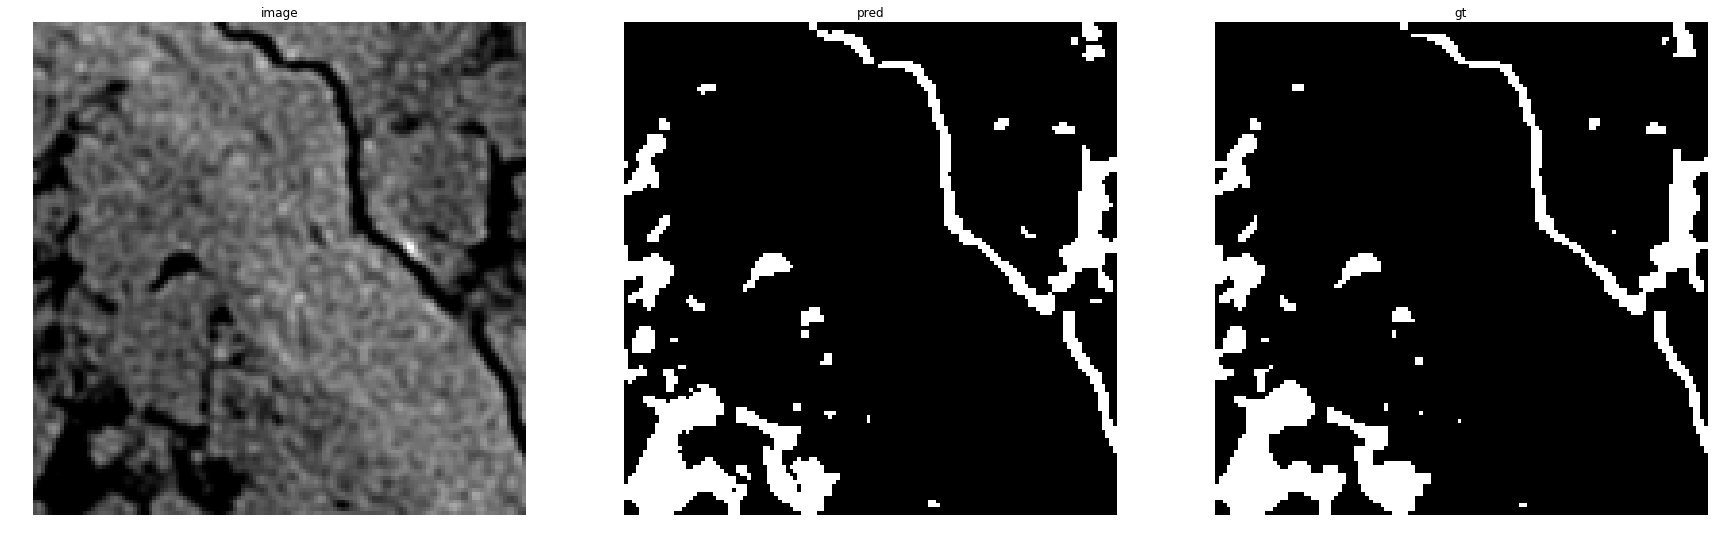

accuracy    : 0.986572265625
precision   : 0.9371624938635248
recall      : 0.9540229885057471
f1          : 0.9455175829618623
pr_auc      : 0.9904124687881112
iou         : 0.8966651009863785


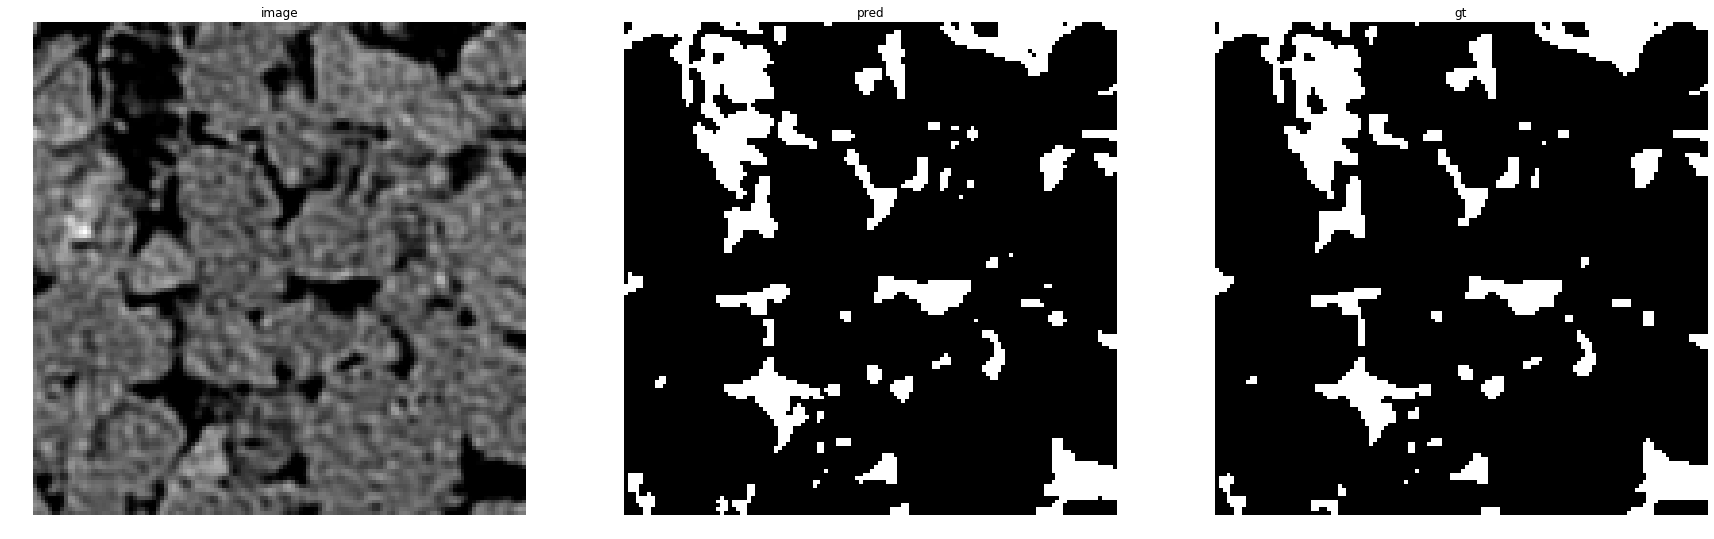

accuracy    : 0.98291015625
precision   : 0.9248807631160573
recall      : 0.9623655913978495
f1          : 0.9432509120389136
pr_auc      : 0.992091993446822
iou         : 0.8925968546221711


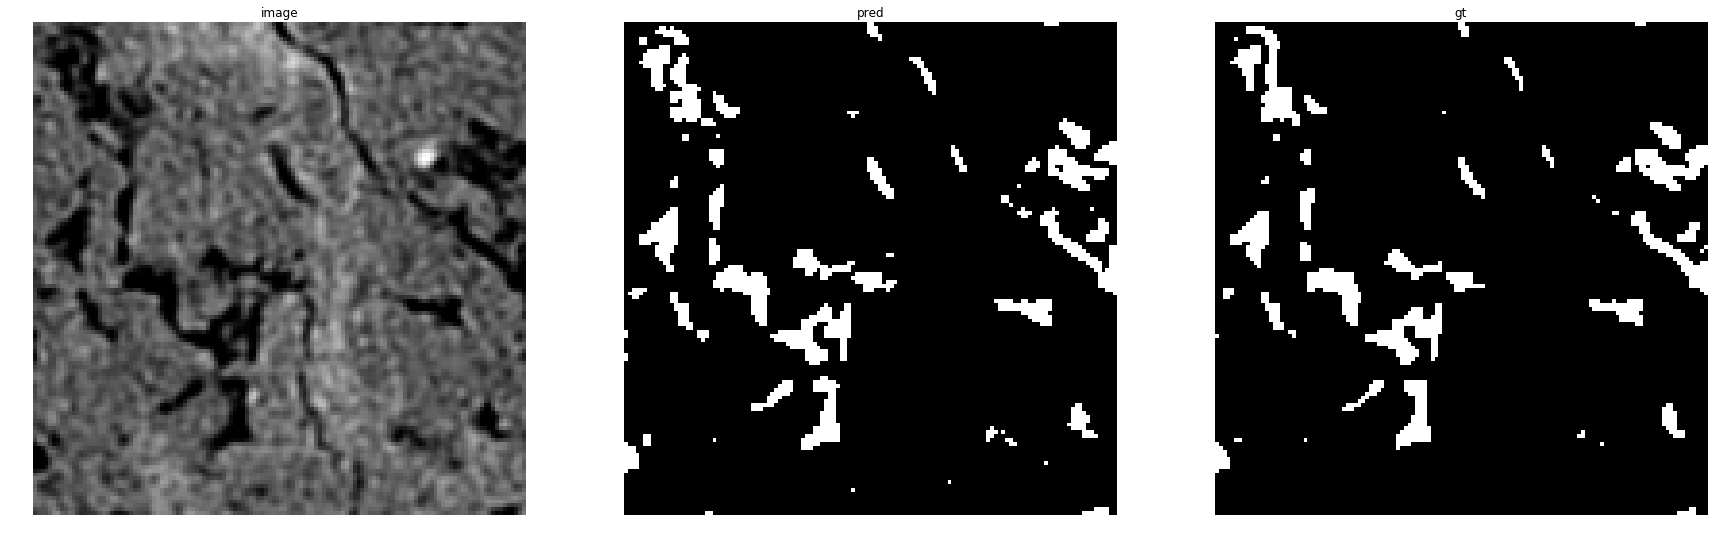

accuracy    : 0.98272705078125
precision   : 0.8483379501385041
recall      : 0.9503491078355314
f1          : 0.8964507866813025
pr_auc      : 0.9789657261942326
iou         : 0.8123342175066313


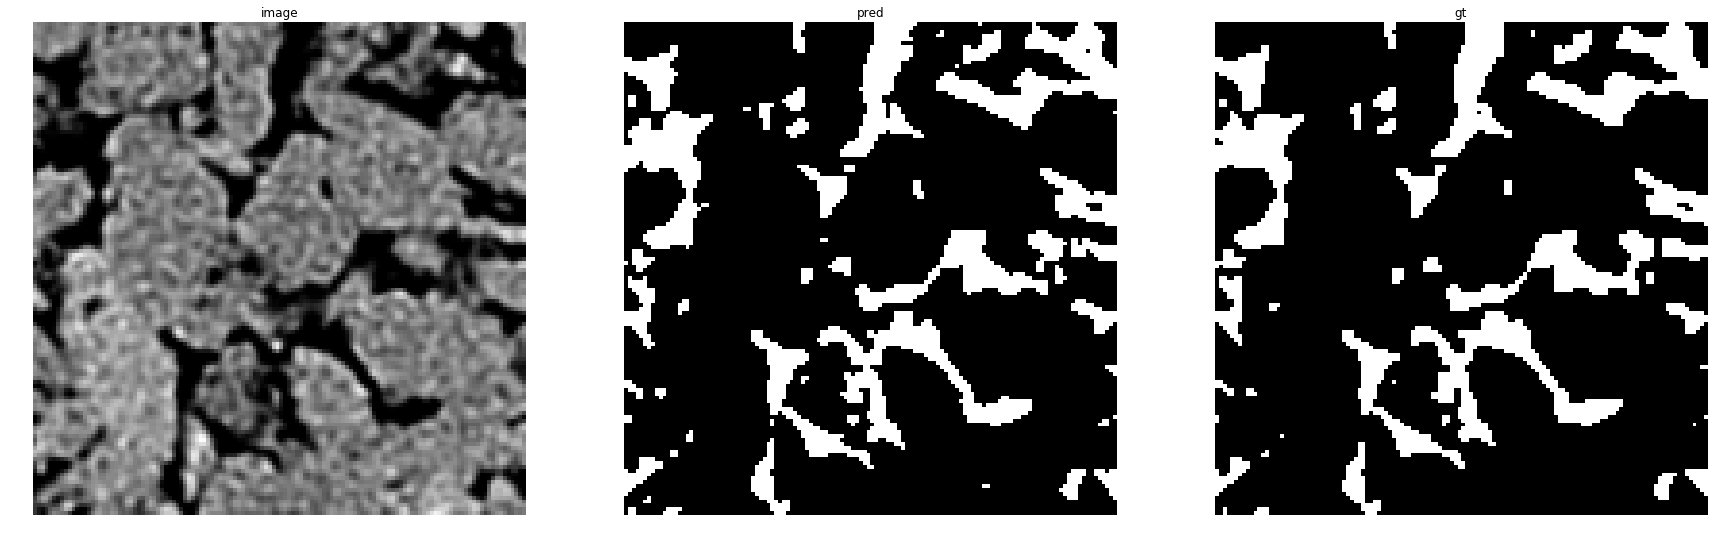

accuracy    : 0.98052978515625
precision   : 0.9343110296364192
recall      : 0.9671094244149273
f1          : 0.9504273504273505
pr_auc      : 0.9931298439473187
iou         : 0.9055374592833876


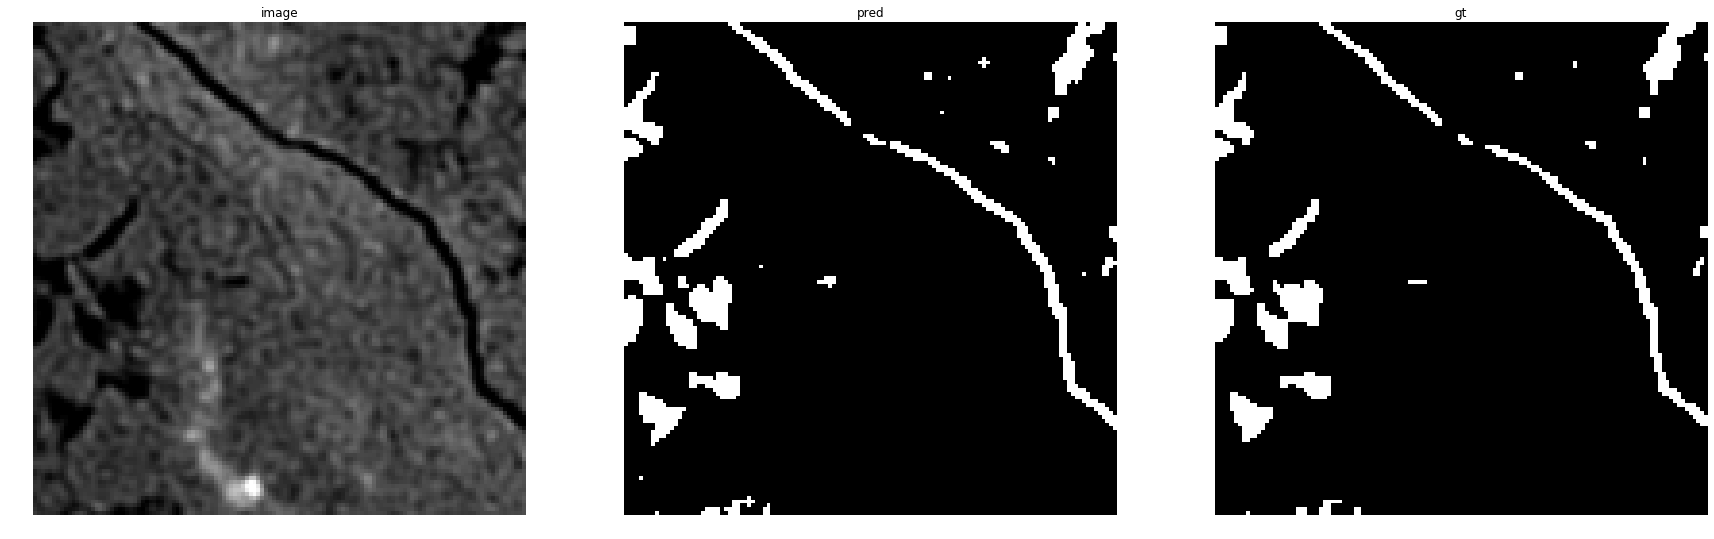

accuracy    : 0.990966796875
precision   : 0.8975853455453788
recall      : 0.9773345421577516
f1          : 0.935763888888889
pr_auc      : 0.9906613276639534
iou         : 0.8792822185970636


In [19]:
model.eval()
for stack_name, dataloader_test in dataloaders_test.items():
    cnt = to_plot
    
    stack_name = os.path.split(stack_name)[-1]
    dir_path = os.path.join(os.path.abspath('.'), 'samples', stack_name)
    if stack_name not in os.listdir(os.path.join('.', 'samples')):
        os.mkdir(dir_path)
    print(stack_name)
    for samples, masks in dataloader_test:

        preds = model(torch.from_numpy(samples).to(device)).cpu().data.numpy()

        for sample, mask, pred in list(zip(samples, masks, preds))[:cnt]:
            img_path = os.path.join('.', 'samples', stack_name, '{}.png'.format(cnt))
            plot_sample(sample[0], mask, pred, threshold, metrics, fig_path=None)
            cnt -= 1
            
        if cnt == 0:
            break

## Make prediction for particular stack

In [15]:
stack_name = 'SPE_carb10_58_box3'

In [16]:
stack = Stack.read_from_source('../../data/{}'.format(stack_name))

509it [00:00, 1101.65it/s]
100%|██████████| 509/509 [00:02<00:00, 193.32it/s]


In [18]:
train_conf['device'] = device

In [19]:
predicted_stack_1 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 128, 1), 
    bs=32, num_workers=8, device=device,
    threshold=None)

8144it [00:00, 210416.68it/s]
8144it [00:40, 201.41it/s]
100%|██████████| 8144/8144 [00:02<00:00, 3434.37it/s]


In [20]:
predicted_stack_2 = stack.apply(
    model, 
    model_config,
    patch_sizes=(1, 128, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

8144it [00:00, 219295.93it/s]
8144it [00:43, 185.62it/s]
100%|██████████| 8144/8144 [00:00<00:00, 11396.77it/s]


In [21]:
predicted_stack_3 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 1, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

8144it [00:00, 230410.87it/s]
8144it [00:43, 188.14it/s]
100%|██████████| 8144/8144 [00:00<00:00, 12357.03it/s]


In [22]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_1.preds, 
    mode='stack',
    threshold=0.5)

0.8947296279006338

In [23]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_2.preds, 
    mode='stack',
    threshold=0.5)

0.8939635017778225

In [24]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_3.preds, 
    mode='stack',
    threshold=0.5)

0.8931584910513268

In [25]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    (predicted_stack_1.preds + predicted_stack_2.preds + predicted_stack_3.preds) / 3, 
    mode='stack',
    threshold=0.5)

0.9153119478388299

In [27]:
average_stack = Stack(predicted_stack_1.features, 
                      predicted_stack_1.targets, 
                      (predicted_stack_1.preds + predicted_stack_2.preds + predicted_stack_3.preds) / 3)

In [31]:
for k, v in metrics.items():
    print('{:12}: {:.6f}'.format(k, 
                                 v(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
                                    predicted_stack_1.preds, 
                                    mode='stack')))

accuracy    : 0.989709
precision   : 0.947774
recall      : 0.941130
f1          : 0.944440
pr_auc      : 0.991501
iou         : 0.894730


In [28]:
for ps, d in zip([(128, 128, 1), (128, 1, 128), (1, 128, 128)], ['z', 'y', 'x']):
    predicted_stack = stack.apply(
        model, 
        model_config=model_config,
        patch_sizes=ps, 
        bs=32, num_workers=8, device=device,
        threshold=None)
    predicted_stack.dump('../segmented_stacks/{}_{}'.format(stack_name, d), 
                         features=False, 
                         targets=True, 
                         preds=True)

8144it [00:00, 72365.38it/s]
8144it [00:44, 184.62it/s]
100%|██████████| 509/509 [00:03<00:00, 151.62it/s]
8144it [00:00, 200209.90it/s]
8144it [00:42, 190.34it/s]
100%|██████████| 509/509 [00:03<00:00, 136.05it/s]
8144it [00:00, 231673.55it/s]
8144it [00:43, 189.23it/s]
100%|██████████| 509/509 [00:03<00:00, 150.18it/s]


In [29]:
average_stack.dump('../segmented_stacks/{}_average'.format(stack_name), 
                   features=False, 
                   targets=True, 
                   preds=True)

100%|██████████| 509/509 [00:03<00:00, 150.61it/s]


## Validate dependence between metrics and distance to patch center

In [21]:
from visualization_utils import output_to_binary

In [25]:
import torch

In [36]:
import pandas as pd

In [62]:
df_agg = None

for i, (img, gt) in tqdm(enumerate(dataloaders_test['../../data/carbRNF'])):
    pred = model(torch.from_numpy(img)).cpu().data.numpy()
    binary = output_to_binary(pred, threshold=0.5, mode='batch')
    
    h, w = binary.shape[1:]
    x = np.arange(h).reshape(-1, 1)
    x = x.repeat(w, axis=1)
    y = np.arange(w).reshape(1, -1)
    y = y.repeat(h, axis=0)
    r = np.sqrt(np.square(x - (h - 1) / 2) + np.square(y - (w - 1) / 2))
    r = r.reshape(1, *r.shape).repeat(binary.shape[0], axis=0).flatten()
    tp = ((binary == 1) & (gt == 1)).astype(np.float32).flatten()
    fp = ((binary == 1) & (gt == 0)).astype(np.float32).flatten()
    fn = ((binary == 0) & (gt == 1)).astype(np.float32).flatten()
    
    df = pd.DataFrame(data={'r': r, 'tp': tp, 'fp': fp, 'fn': fn})
    df['r'] = df['r'].astype('int')
    df['count'] = 1
    if df_agg is None:
        df_agg = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        
        portion = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        df_agg = df_agg + portion
    
#     if i > 20:
#         break



0it [00:00, ?it/s]

1it [00:02,  2.39s/it]

2it [00:04,  2.30s/it]

3it [00:06,  2.14s/it]

4it [00:08,  2.04s/it]

5it [00:10,  2.03s/it]

6it [00:12,  2.03s/it]

7it [00:13,  1.95s/it]

8it [00:15,  1.91s/it]

9it [00:17,  1.93s/it]

10it [00:19,  1.87s/it]

11it [00:21,  1.84s/it]

12it [00:22,  1.81s/it]

13it [00:24,  1.80s/it]

14it [00:26,  1.78s/it]

15it [00:28,  1.77s/it]

16it [00:29,  1.77s/it]

17it [00:31,  1.77s/it]

18it [00:33,  1.76s/it]

19it [00:35,  1.76s/it]

20it [00:36,  1.75s/it]

21it [00:38,  1.76s/it]

22it [00:40,  1.76s/it]

23it [00:42,  1.76s/it]

24it [00:43,  1.77s/it]

25it [00:45,  1.80s/it]

26it [00:47,  1.78s/it]

27it [00:49,  1.77s/it]

28it [00:51,  1.77s/it]

29it [00:52,  1.77s/it]

30it [00:54,  1.76s/it]

31it [00:56,  1.76s/it]

32it [00:58,  1.76s/it]

33it [00:59,  1.76s/it]

34it [01:01,  1.76s/it]

35it [01:03,  1.75s/it]

36it [01:05,  1.76s/it]

37it [01:06,  1.76s/it]

38it [01:08,  1.76s/it]

39it [01:10,  1.76s/it]

40it [01:12,

In [63]:
df_agg

count      tp     fp     fn
r                              
0     256    20.0    4.0    0.0
1     512    44.0   12.0    0.0
2    1280   130.0   16.0    6.0
3    1280   124.0    4.0   14.0
4    1792   154.0    6.0    8.0
5    2048   156.0   30.0   20.0
6    2816   220.0   22.0   34.0
7    3328   330.0   24.0   38.0
8    3072   324.0   24.0   28.0
9    3840   336.0   22.0   38.0
10   4352   430.0   34.0   36.0
11   4096   456.0   62.0   42.0
12   5888   678.0   38.0   54.0
13   4864   540.0   46.0   54.0
14   6400   632.0   54.0   40.0
15   6144   544.0   56.0   50.0
16   6400   594.0   56.0   68.0
17   6912   700.0   72.0   60.0
18   6656   702.0   78.0   40.0
19   8960   912.0   68.0   82.0
20   8448   924.0   70.0   60.0
21   8448   942.0   74.0   90.0
22   8704   932.0   76.0  102.0
23   8960   912.0   88.0   86.0
24  11008  1068.0  110.0   88.0
25   9728   924.0   84.0   98.0
26  10496  1048.0  114.0  122.0
27  11520  1142.0  126.0  100.0
28  11008  1070.0  110.0   82.0
29  11776  1062.0  114.0   78.0
..    ...     ...    ...    ...
60  24320  2366.0  180.0  178.0
61  26368  2554.0  190.0  196.0
62  25344  2414.0  166.0  274.0
63  25600  2440.0  152.0  232.0
64  19712  1902.0  150.0  222.0
65  20224  2022.0  138.0  200.0
66  17408  1678.0  138.0  194.0
67  16128  1538.0  126.0  192.0
68  14592  1438.0  116.0  166.0
69  12288  1254.0  104.0  132.0
70  14592  1588.0  110.0  162.0
71  11008  1142.0   94.0  160.0
72  11520  1368.0   82.0  134.0
73  10240  1200.0   86.0  132.0
74   8960   994.0   54.0  112.0
75   9472  1044.0   66.0   96.0
76   7168   770.0   36.0   80.0
77   7936   846.0   48.0  102.0
78   6400   666.0   44.0   66.0
79   6400   680.0   40.0   86.0
80   5632   584.0   42.0   84.0
81   3840   364.0   30.0   46.0
82   5376   518.0   26.0   64.0
83   3072   346.0   10.0   52.0
84   4352   484.0   28.0   42.0
85   1792   186.0    6.0   16.0
86   2304   192.0   10.0   22.0
87   1536   140.0    4.0   16.0
88    768    84.0    2.0    4.0
89    768    76.0    6.0   14.0

[90 rows x 4 columns]

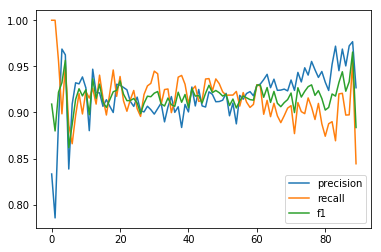

In [65]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision, label='precision')
plt.plot(df_agg.index, recall, label='recall')
plt.plot(df_agg.index, 2 * precision * recall / (precision + recall), label='f1')
plt.legend(loc='best')
plt.show()

In [76]:
(2 * precision * recall / (precision + recall)).mean()

0.9169255

In [74]:
np.mean(results['test_metrics']['../../data/carb96558']['f1'])

0.9757604510306116

In [75]:
np.mean(results['test_metrics']['../../data/carbRNF']['f1'])

0.9172696807633565

In [77]:
np.mean(results['test_metrics']['../../data/carbRNF']['iou'])

0.8471886630965806

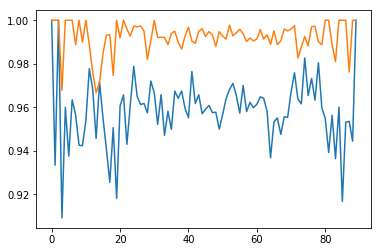

In [60]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision)
plt.plot(df_agg.index, recall)
plt.show()

In [14]:
for x, y in dataloader_train:
    break

In [15]:
x.shape

(32, 1, 128, 128)

In [16]:
x[0].mean()

0.011243731

In [19]:
x[0].std()

0.79318494

In [22]:
a = data_train[0]['features']

In [24]:
a.shape

(128, 128, 1)

In [25]:
from stack_segmentation.io import image_process_basic

In [27]:
b = image_process_basic(a)

In [29]:
b.mean()

0.24210383

In [33]:
c = np.squeeze(b)[np.newaxis, np.newaxis, :, :]

In [36]:
import torch

In [55]:
p = model(torch.from_numpy(c).to(device))

In [56]:
d = p.cpu().data.numpy()[0]

In [57]:
from visualization_utils import output_to_binary

In [62]:
e = output_to_binary(d, threshold=0.5)

In [63]:
e.shape

(128, 128)

In [64]:
e

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

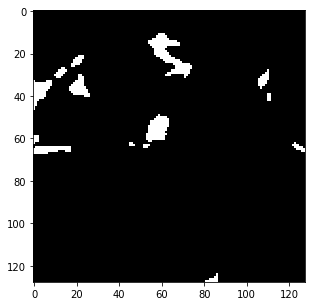

In [65]:
plt.figure(figsize=(5, 5))
plt.imshow(e, cmap='gray')
plt.show()